<a href="https://colab.research.google.com/github/EmanoneL/SHIFT/blob/main/My_gates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Гапотеза 1:

Применена модель CatBoostClassifier с 50, 100 и 200 количеством итераций.
Лучший результат 150 итераций - 103 score на лидерборде. Недостаток - долгое обучение.

Гипотеза 2:

Новый признак: выходной или праздничный день.

Гипотеза 3:
Новый признак: врем первого посещения за день, время последнего посещения за день и разница между ними

Гипотеза 4:
Четный или нечетный день недели

Гипотеза 5:
Новый признак: часть дня: утро, обед, день, вечер, ночь

Гипотеза 6:
Новый признак: последний ли это день месяца

Гипотеза 7:
Через какой турникет заходил в последний раз

Гипотеза 8:
Количество посещений

Гипотеза 9:
Наиболее часто посещаемый турникет

Гипотеза 10:
Высокий результат на валидационной, но слабый на тестовой выборках. Переобучение. Модель упрощена. Результат - score 24. В этот же момент в чате в телеграме я увидела сообщение о том, что у людей с высоким скором около 50+ признаков, так что принято решение оставить гипермараметры модели без изменений и добавить как можно больше признаков за оставшееся время. В итоге модель переобучилась снова и выдавала совсем неадекватные результаты

Итог: лучший скор показала модель CatBoostClaccidier с количеством итераций 100 и без каких либо признаков. Скор конкетно этого ноутбука - 86

# Импорт библиотек


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
#import sklearn; sklearn.show_versions()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool

# Чтение обучающего и тестового датасетов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = r'/content/drive/MyDrive/SHIFT/Stazhirovka/Курс 2025 год/data/' # Все исходные файлы в одной папке data

In [ ]:
train = pd.read_csv(data_path + 'train.csv', index_col=0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35172 entries, 0 to 37516
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  35172 non-null  int64 
 1   ts       35172 non-null  object
 2   gate_id  35172 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


Мы собрали логи вида: ID пользователя, время, № турникета. Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить “таблетку”. Все это фиксируется - кто, в какую дату, в какое время, какой турникет.

In [ ]:
train.head(10)

user_id                   ts  gate_id
0        18  2022-07-29 09:08:54        7
1        18  2022-07-29 09:09:54        9
3        18  2022-07-29 09:10:06        5
4        18  2022-07-29 09:10:08        5
5        18  2022-07-29 09:10:34       10
6        18  2022-07-29 09:32:47       11
7        18  2022-07-29 09:33:12        4
8        18  2022-07-29 09:33:13        4
9         1  2022-07-29 09:33:16        7
10       18  2022-07-29 09:33:23        9

In [ ]:
test = pd.read_csv(data_path + 'test.csv', index_col=0)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6620 entries, 37518 to 44641
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ts       6620 non-null   object
 1   gate_id  6620 non-null   int64 
 2   lost_id  6620 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 206.9+ KB


Случилась техническая ошибка, с нового года ID пользователей перепутаны

ts - дата и время прохода

gate_id - id турникета/ворот/шлагбаума

lost_id - неверный id пользователя

In [ ]:
test.head(10)

ts  gate_id  lost_id
37518  2023-01-03 08:21:00        9        1
37520  2023-01-03 08:21:18        5        1
37521  2023-01-03 08:21:19        5        1
37522  2023-01-03 08:21:39       10        1
37523  2023-01-03 08:32:49       15       19
37524  2023-01-03 08:36:02        9       19
37526  2023-01-03 08:36:14        5       19
37527  2023-01-03 08:36:16        5       19
37528  2023-01-03 08:36:43       10       19
37529  2023-01-03 09:21:29        7       54

# EDA

## Объединение данных

Объединим данные для упрощенной предобработки. Во всей обучающей выборке отсутствует lost_id, так что их будет просто разделить

In [ ]:
all_data = pd.concat([train, test], axis=0)

In [ ]:
all_data

user_id                   ts  gate_id  lost_id
0         18.0  2022-07-29 09:08:54        7      NaN
1         18.0  2022-07-29 09:09:54        9      NaN
3         18.0  2022-07-29 09:10:06        5      NaN
4         18.0  2022-07-29 09:10:08        5      NaN
5         18.0  2022-07-29 09:10:34       10      NaN
...        ...                  ...      ...      ...
44637      NaN  2023-02-24 17:08:57       10     15.0
44638      NaN  2023-02-24 19:43:36       11     15.0
44639      NaN  2023-02-24 19:44:00        4     15.0
44640      NaN  2023-02-24 19:44:01        4     15.0
44641      NaN  2023-02-24 19:44:09        9     15.0

[41792 rows x 4 columns]

In [ ]:
# Доля тест во всей выборке

sum(all_data['lost_id'].notnull()) / all_data['lost_id'].shape[0] # где-то 16% составляет test

0.15840352220520673

## Исследование ts

Преобразуем столбец ts к формату datetime

In [ ]:
all_data['ts'] = pd.to_datetime(all_data['ts'])

In [ ]:
all_data['ts'].describe()

count                            41792
mean     2022-10-22 03:20:12.068242688
min                2022-07-29 09:08:54
25%      2022-08-31 16:31:14.750000128
50%                2022-10-12 11:56:38
75%      2022-12-13 11:56:27.750000128
max                2023-02-24 19:44:09
Name: ts, dtype: object

In [ ]:
test['ts'] = pd.to_datetime(test['ts'])

<Axes: >

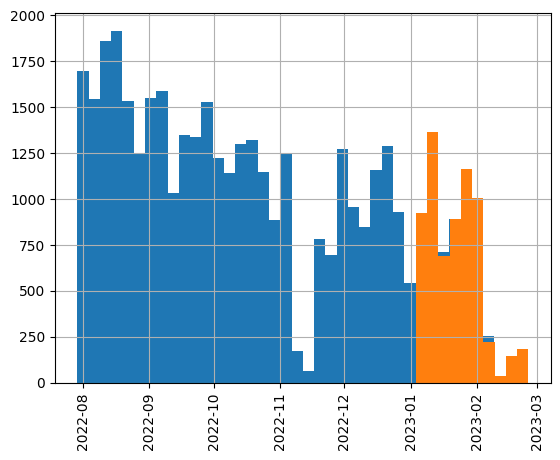

In [ ]:
plt.figure()
plt.xticks(rotation='vertical')
all_data['ts'].hist(bins=40)
test['ts'].hist(bins=10)

Заметим, что на графике есть небольшой нисходящий тренд

Есть сильная просадка в середине ноября и в середине февраля

Периодичность? Праздники? Выходные?

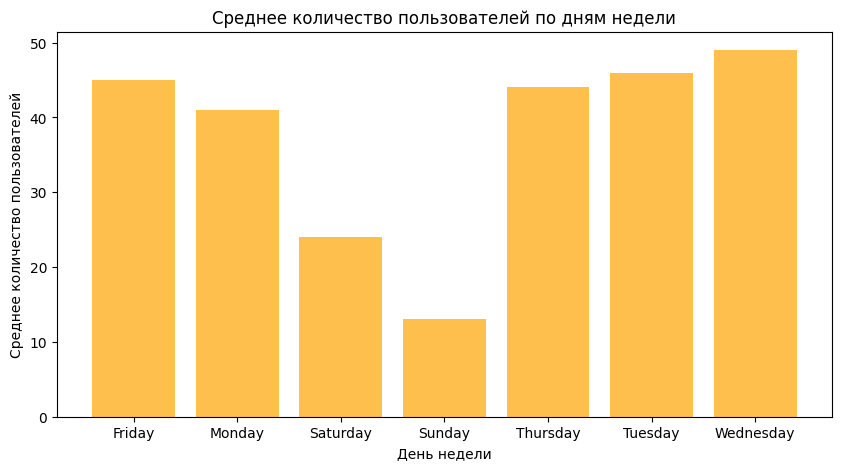

In [ ]:
all_data['day_name'] = all_data['ts'].dt.day_name()
weekday_counts = all_data.groupby('day_name')['user_id'].nunique()

# Строим график
plt.figure(figsize=(10, 5))
plt.bar(weekday_counts.index, weekday_counts.values, color='orange', alpha=0.7)

plt.xlabel("День недели")
plt.ylabel("Среднее количество пользователей")
plt.title("Среднее количество пользователей по дням недели")
plt.show()


Скорее всего saturday и sunday выходные, есть периодичность

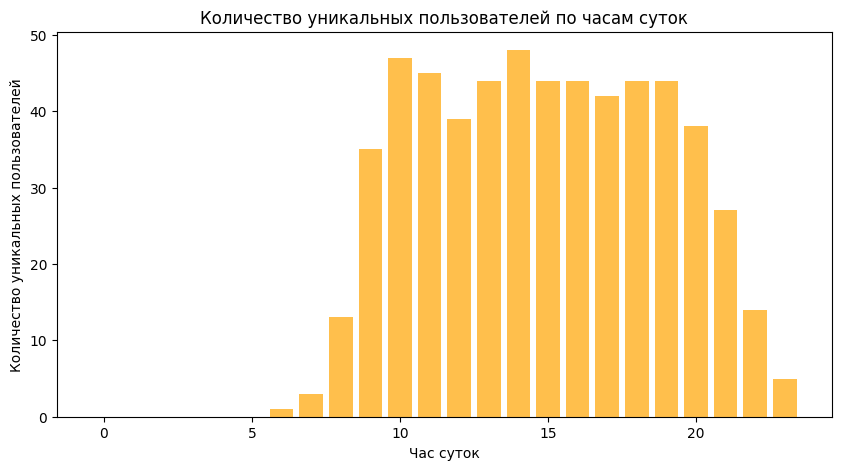

In [ ]:
data_with_hour = all_data.copy()
data_with_hour['hour'] = all_data['ts'].dt.hour
hourly_counts = data_with_hour.groupby('hour')['user_id'].nunique()

# Строим график
plt.figure(figsize=(10, 5))
plt.bar(hourly_counts.index, hourly_counts.values, color='orange', alpha=0.7)

plt.xlabel("Час суток")
plt.ylabel("Количество уникальных пользователей")
plt.title("Количество уникальных пользователей по часам суток")
plt.show()


## Исследование user_id / lost_id

In [ ]:
all_data['lost_id'].value_counts().count() # Всего требуется предсказать правильно 34 id

34

In [ ]:
all_data['lost_id'].value_counts()

lost_id
37.0    694
55.0    458
6.0     432
12.0    362
19.0    336
15.0    298
18.0    298
47.0    278
53.0    277
1.0     253
33.0    245
0.0     224
11.0    210
49.0    208
32.0    199
39.0    185
54.0    183
9.0     181
50.0    157
29.0    141
3.0     139
48.0    139
14.0    117
17.0    111
27.0    103
35.0     95
46.0     56
24.0     54
42.0     50
57.0     50
26.0     37
34.0     33
23.0     12
25.0      5
Name: count, dtype: int64

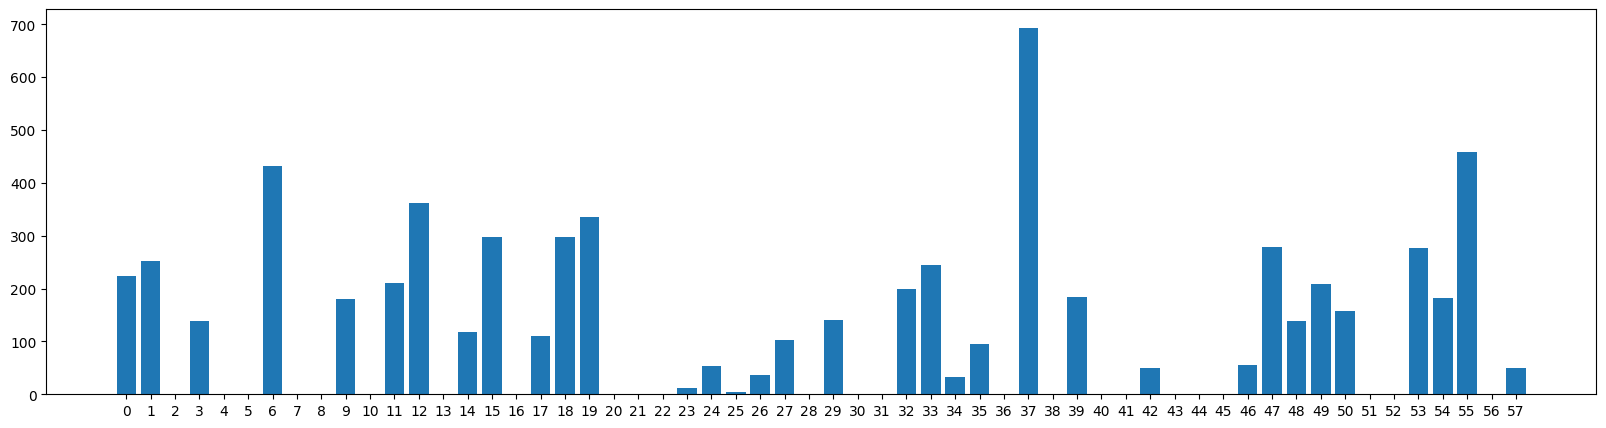

In [ ]:
# Считаем частоту каждого lost_id
counts = all_data['lost_id'].value_counts().sort_index()

# Рисуем столбчатую диаграмму
plt.figure(figsize=(20, 5))
plt.bar(counts.index, counts.values)

# Устанавливаем метки оси X для всех значений
xticks = np.arange(all_data['lost_id'].min(), all_data['lost_id'].max() + 1)
plt.xticks(xticks)
plt.show()


In [ ]:
all_data['user_id'].value_counts()

user_id
37.0    2184
55.0    2166
6.0     1857
12.0    1837
19.0    1661
15.0    1659
18.0    1441
53.0    1279
11.0    1255
47.0    1250
33.0    1184
0.0     1184
1.0     1171
49.0    1129
39.0    1032
32.0    1020
9.0     1015
54.0     977
50.0     965
29.0     924
3.0      894
48.0     712
17.0     648
14.0     617
35.0     549
27.0     523
57.0     482
46.0     475
24.0     386
42.0     340
26.0     279
34.0     267
23.0     247
40.0     242
25.0     238
31.0     181
56.0     129
43.0     117
20.0     112
41.0     110
22.0      87
28.0      64
45.0      57
7.0       48
36.0      45
2.0       39
8.0       27
10.0      17
38.0      13
5.0       10
30.0      10
52.0       5
21.0       5
44.0       4
51.0       2
4.0        1
Name: count, dtype: int64

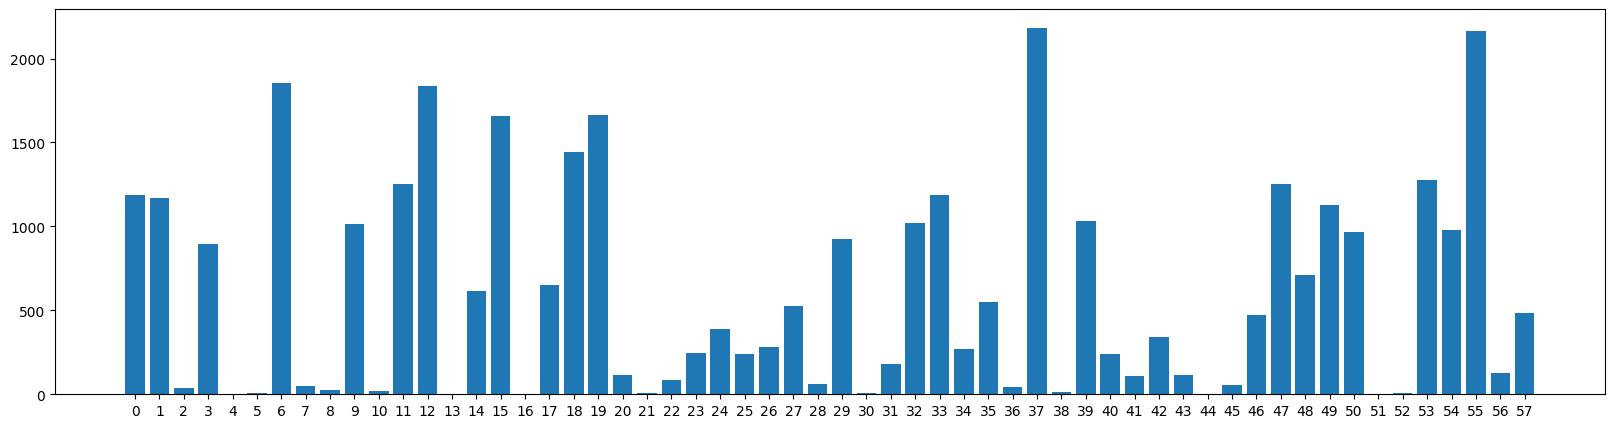

In [ ]:
# Считаем частоту каждого lost_id
counts = all_data['user_id'].value_counts().sort_index()

# Рисуем столбчатую диаграмму
plt.figure(figsize=(20, 5))
plt.bar(counts.index, counts.values)

# Устанавливаем метки оси X для всех значений
xticks = np.arange(all_data['lost_id'].min(), all_data['lost_id'].max() + 1)
plt.xticks(xticks)
plt.show()

По данному графику можно предположить, какие предсказанные user_id будут иметь большую ценность, так как встречаются достаточно редко

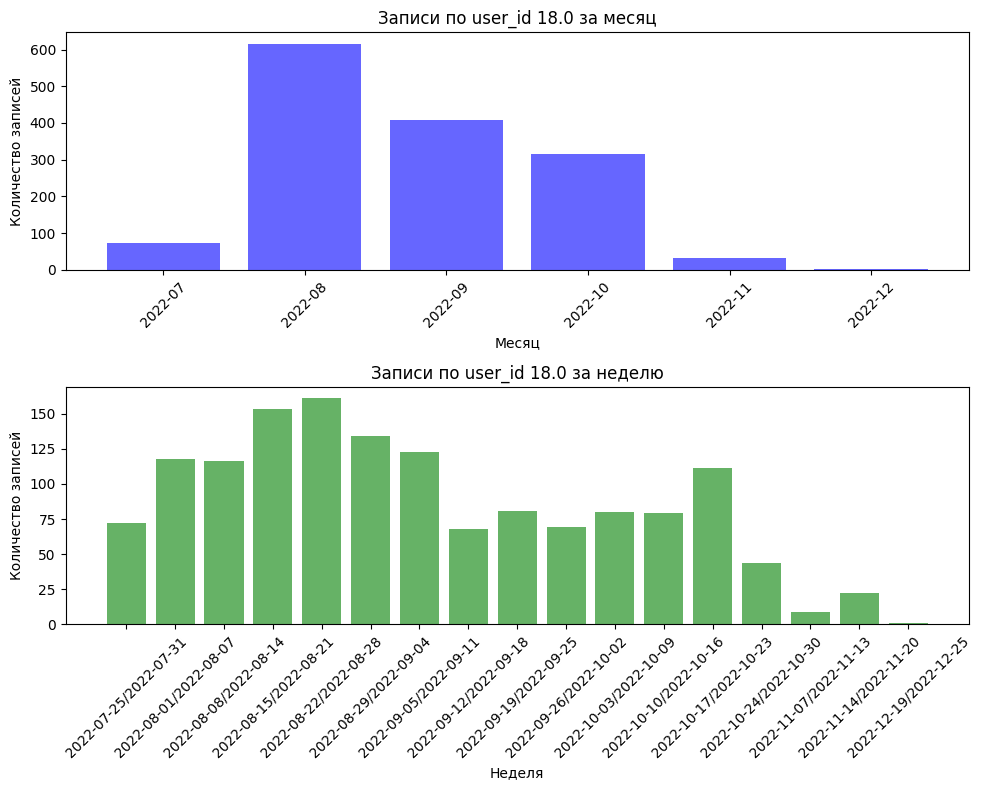

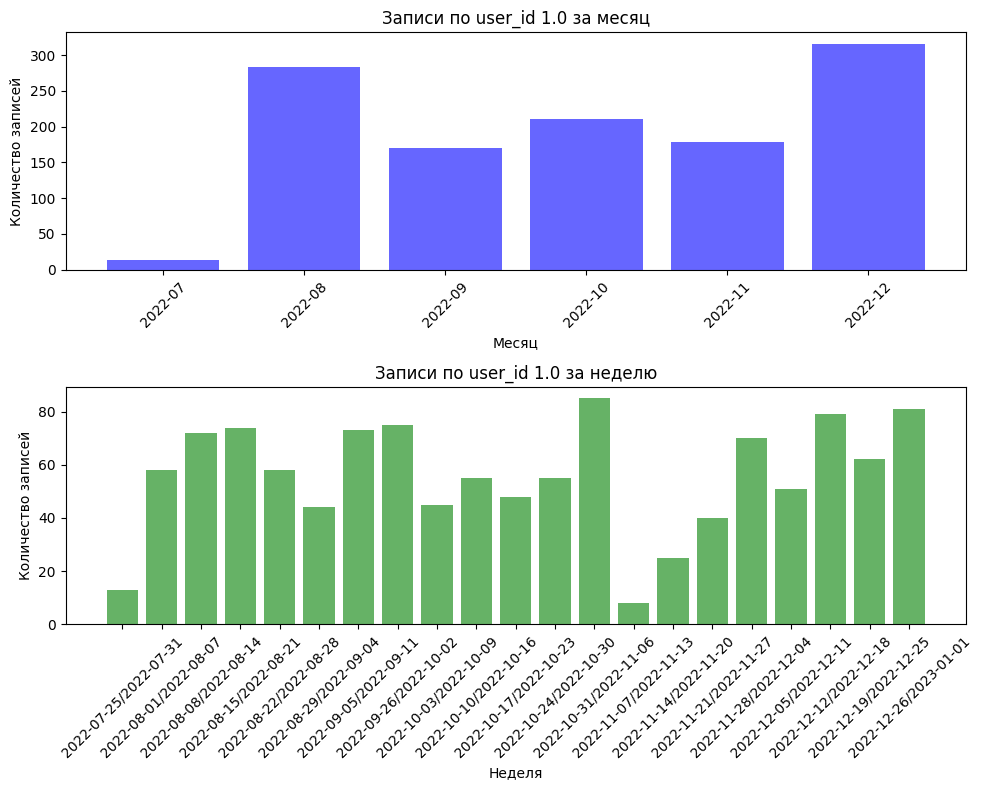

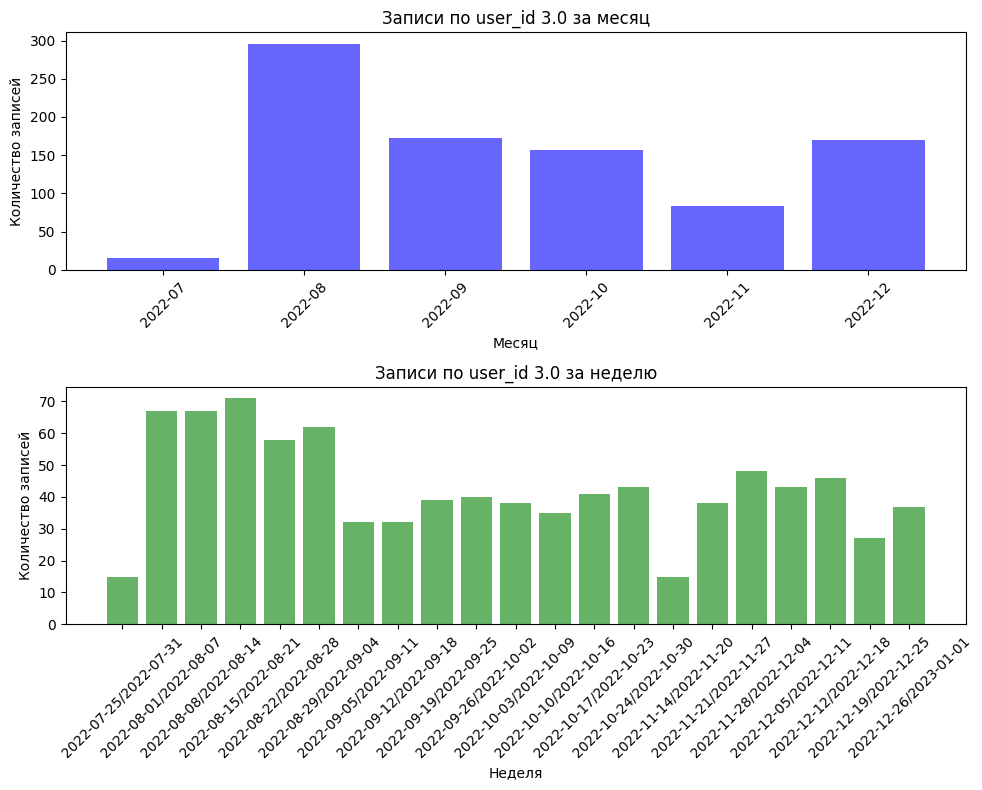

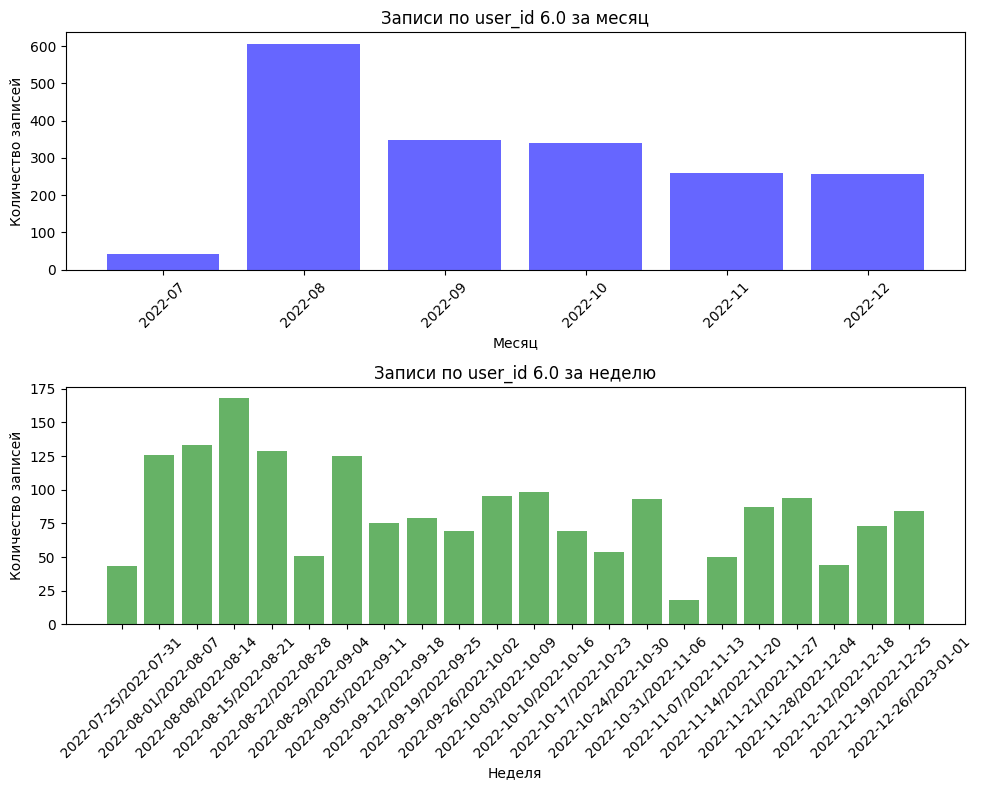

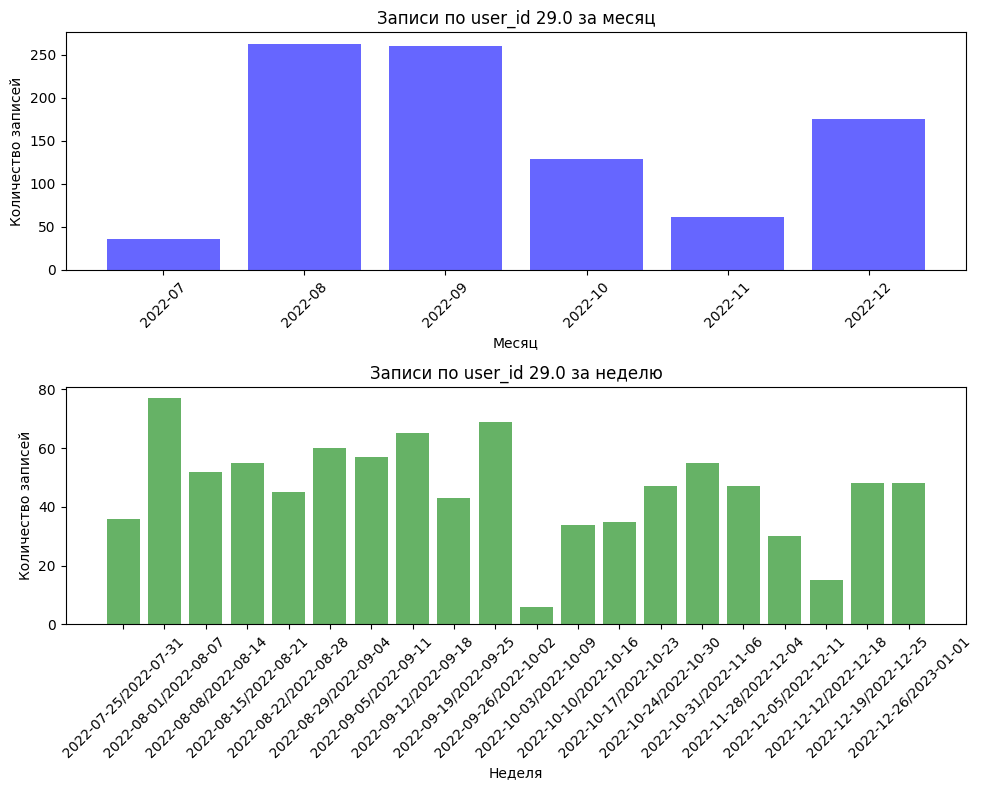

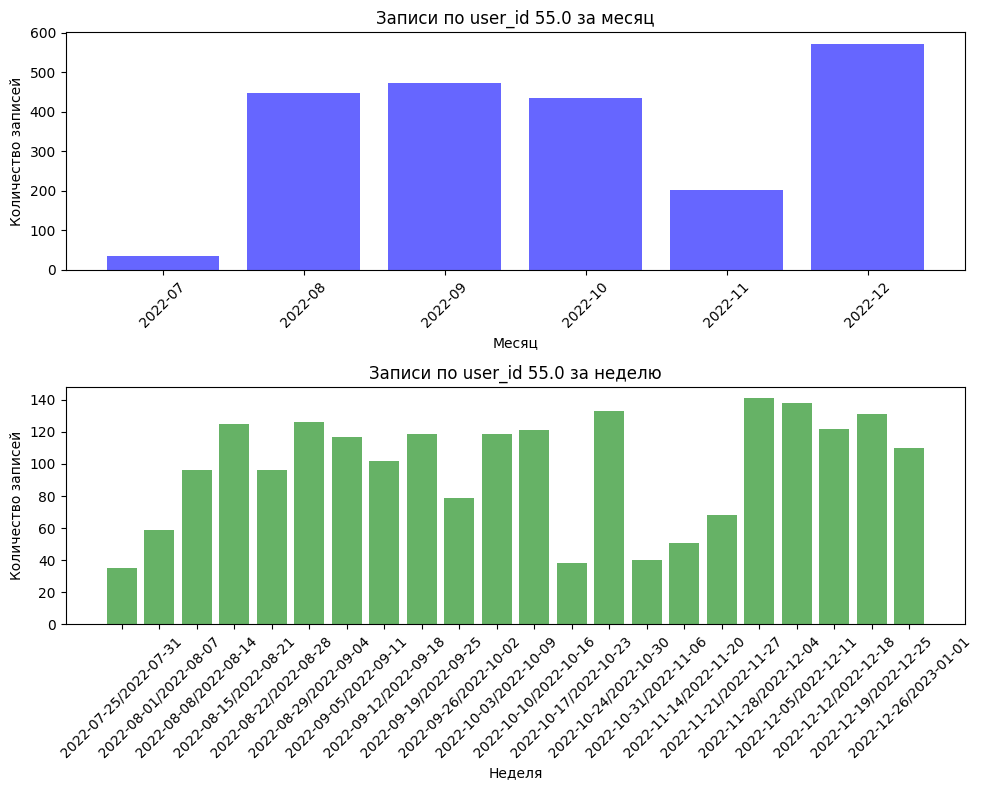

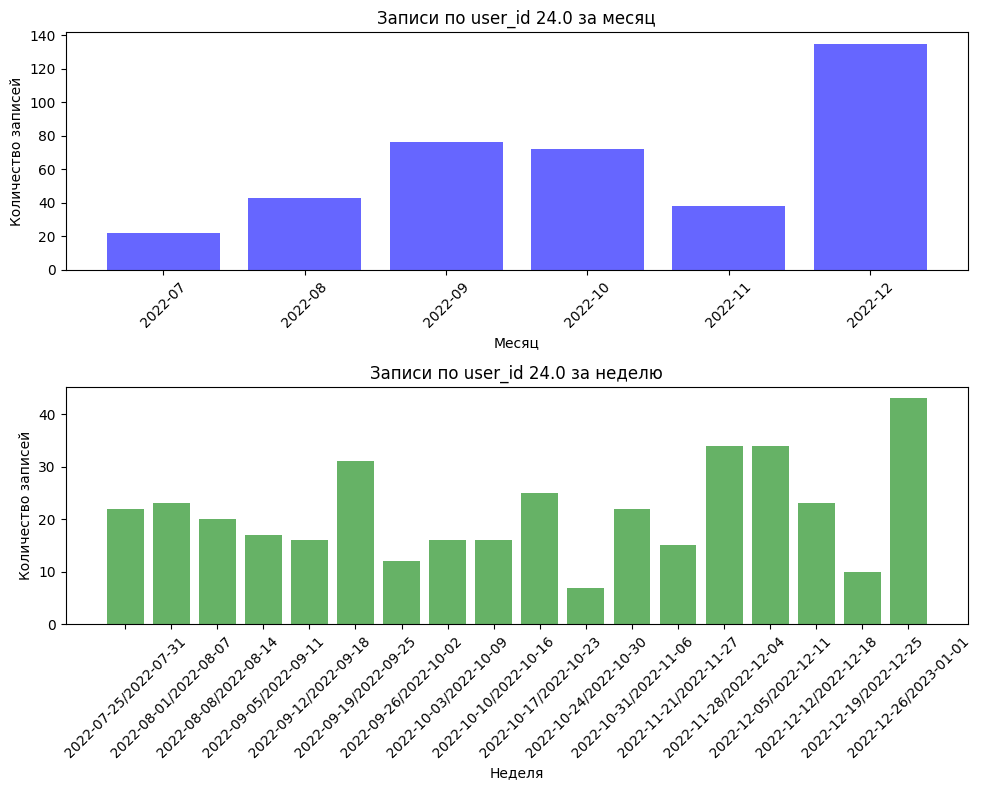

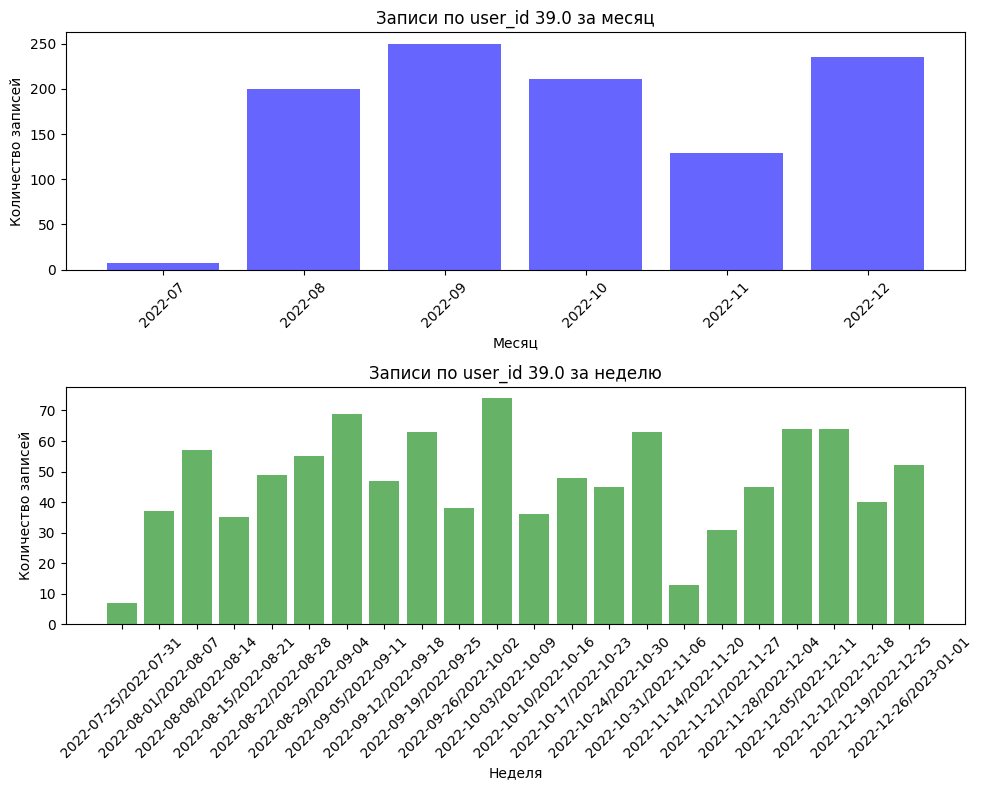

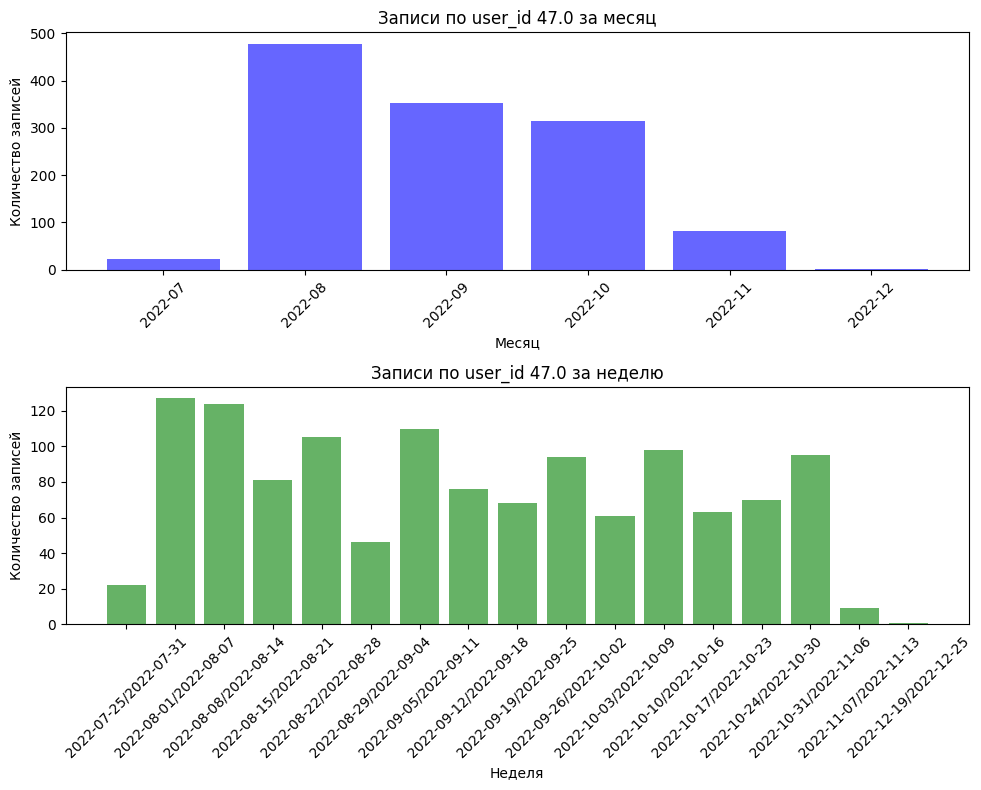

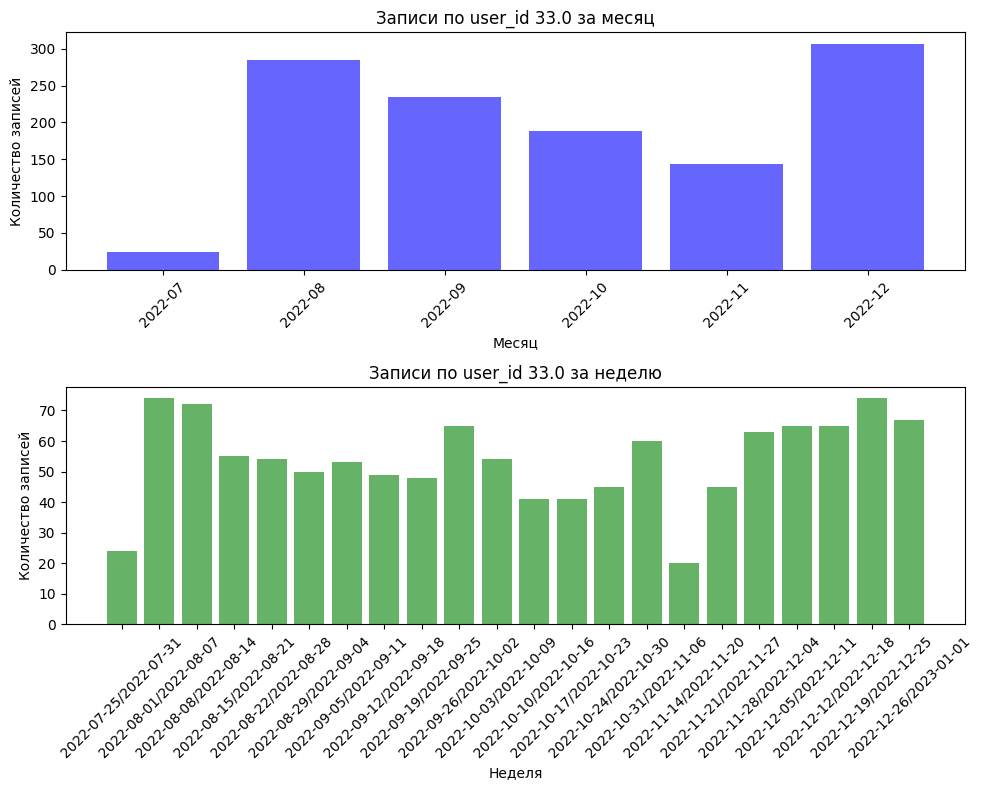

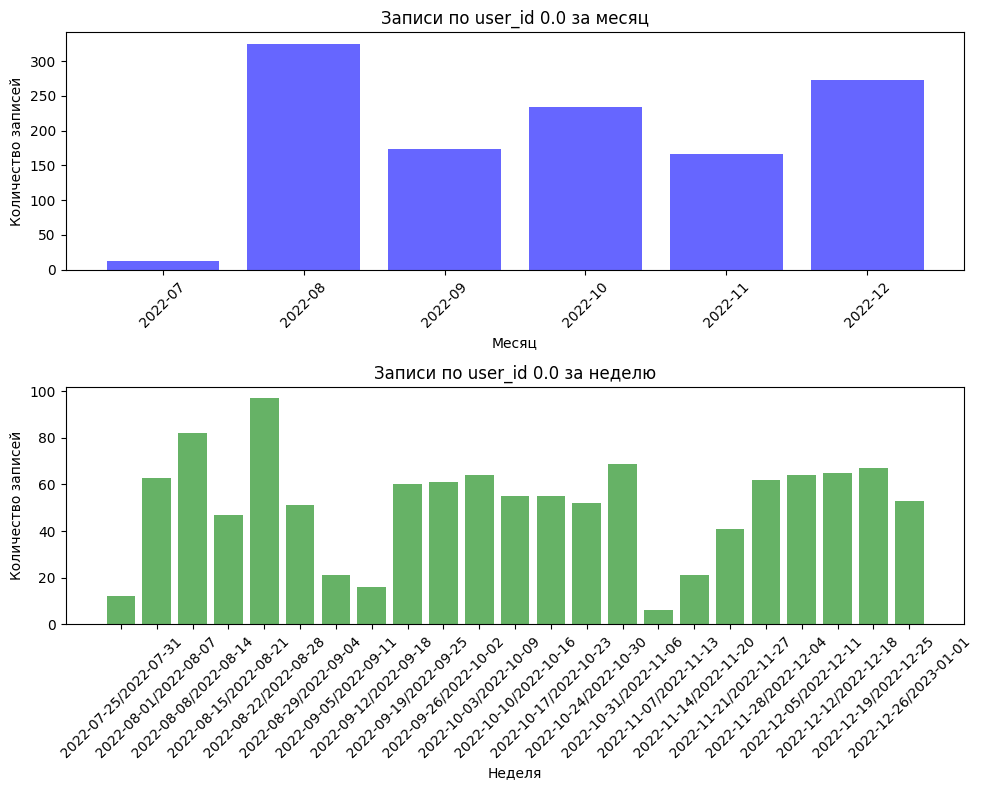

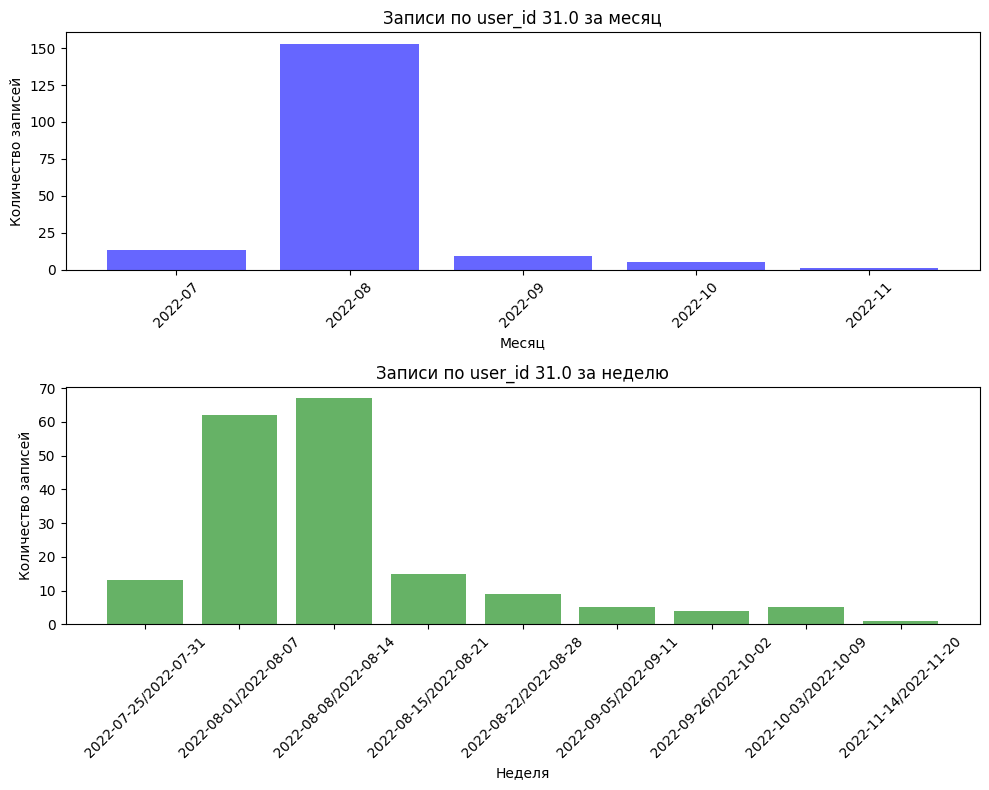

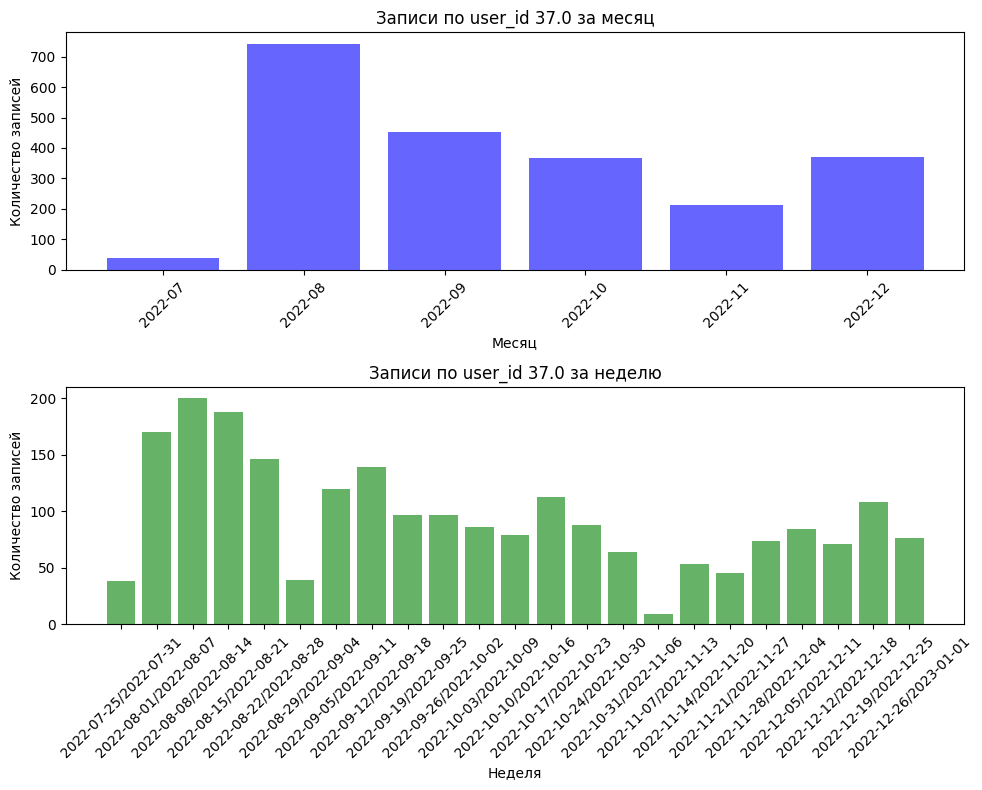

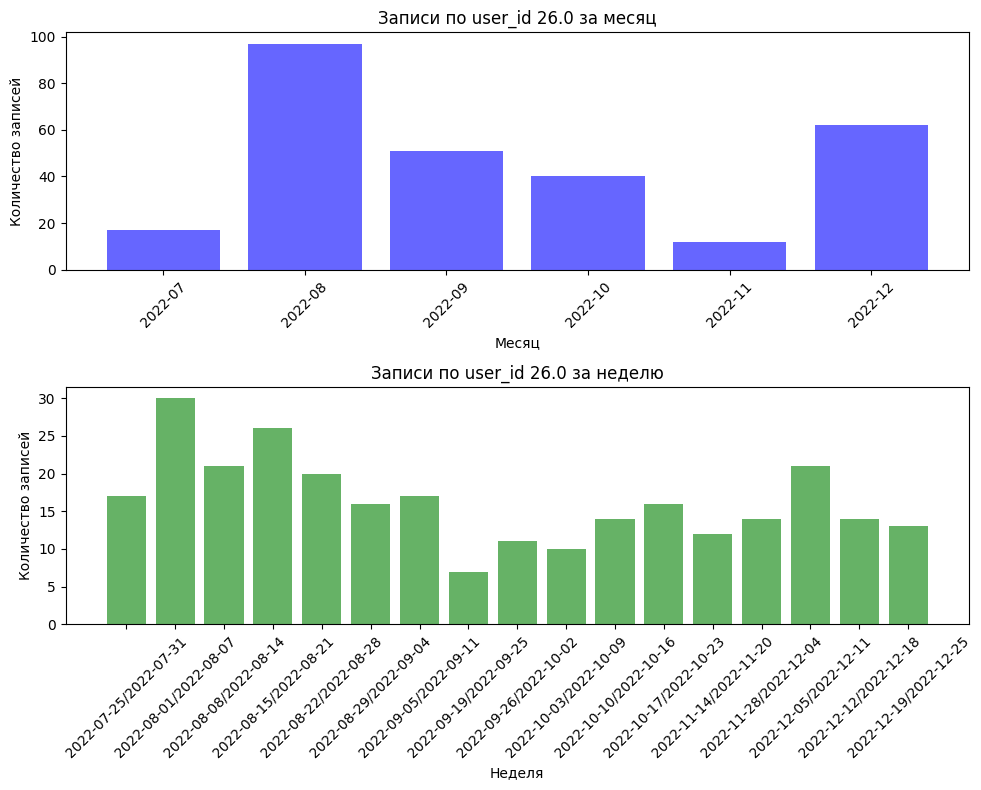

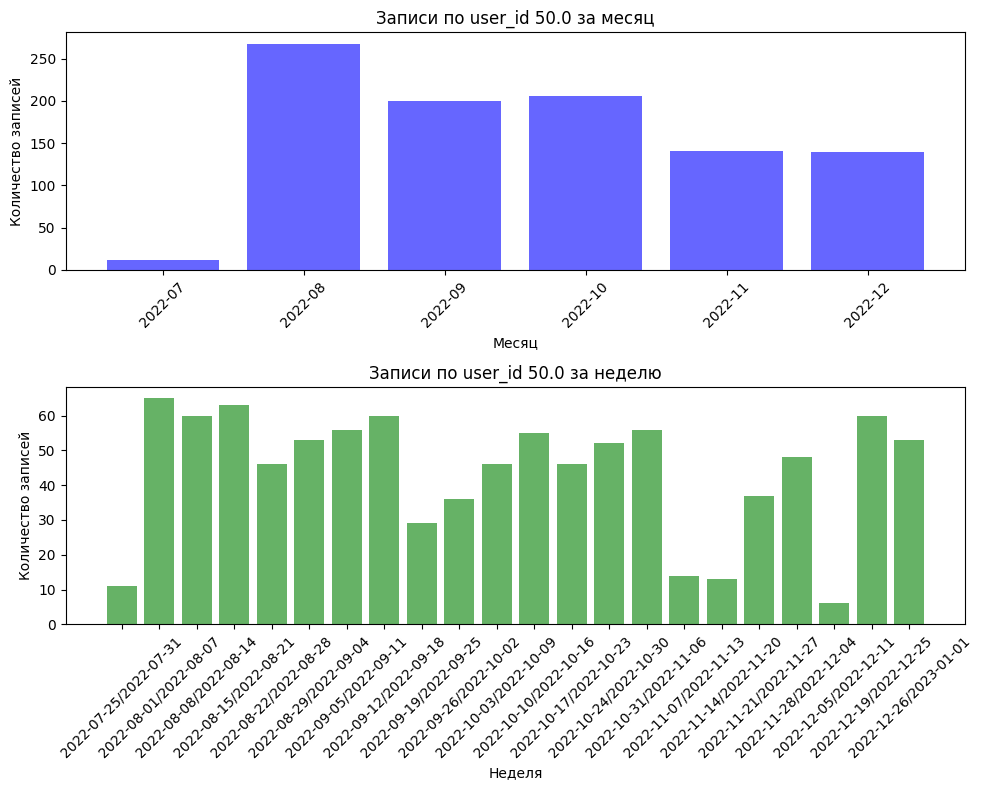

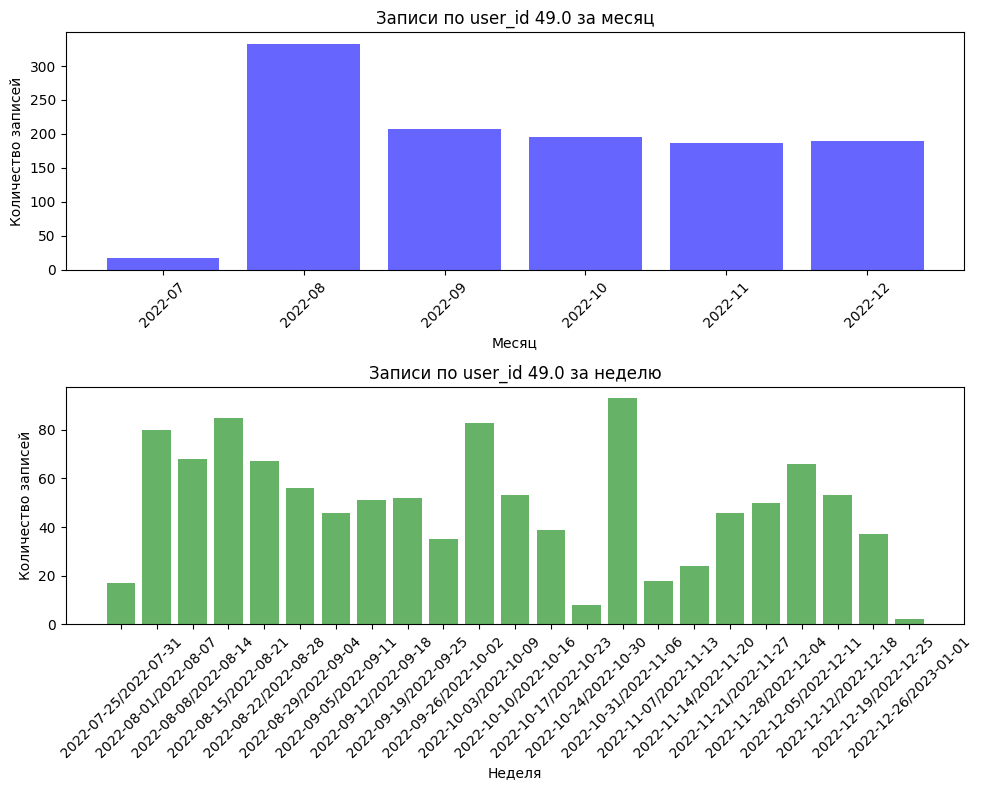

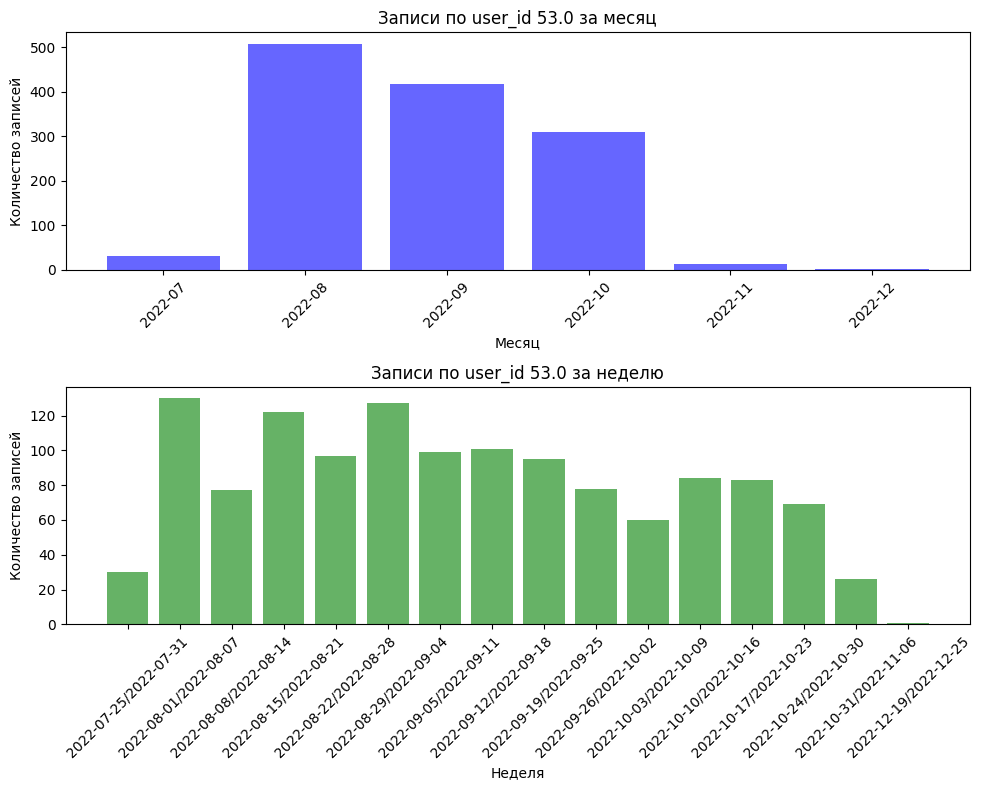

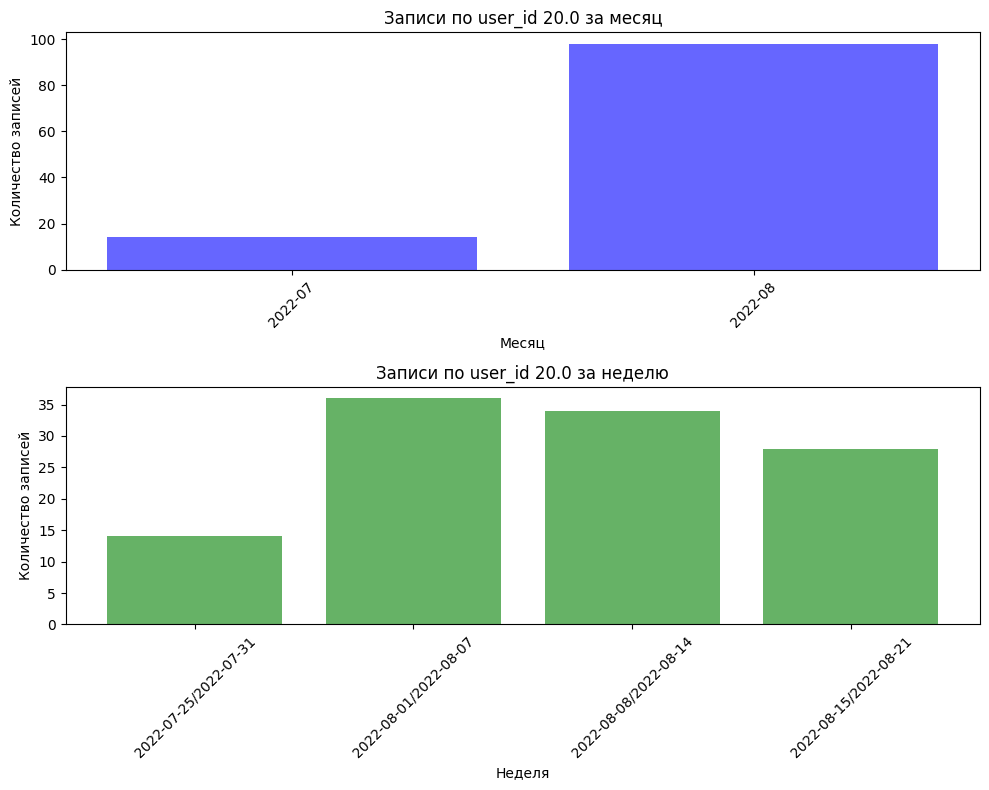

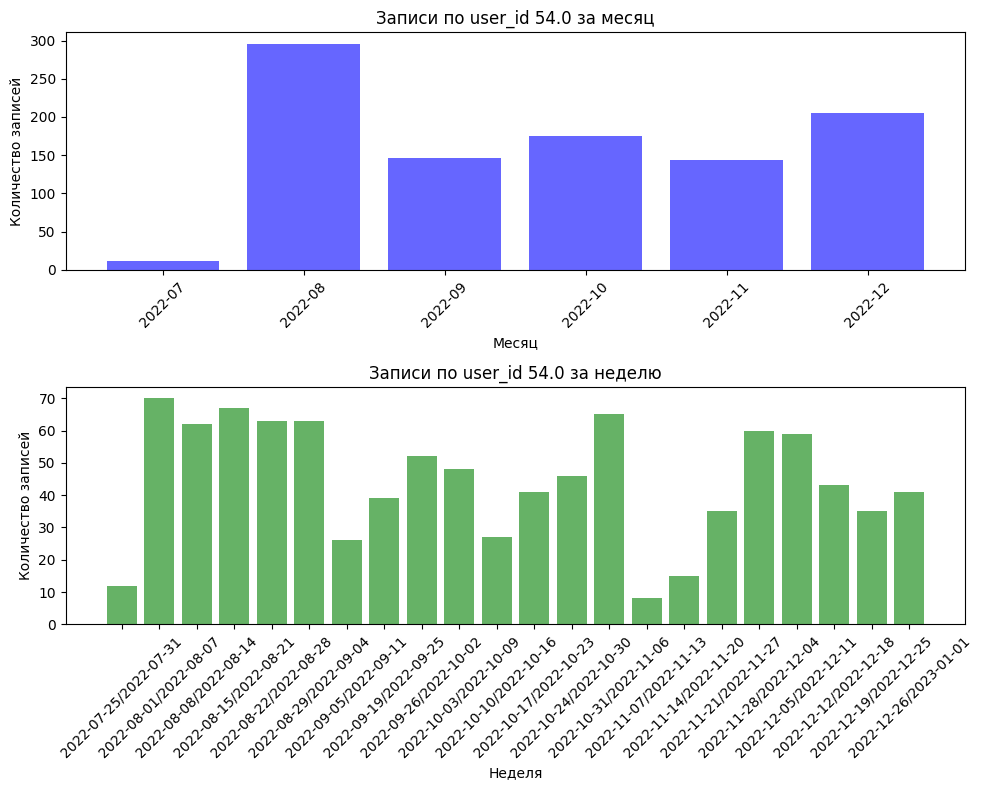

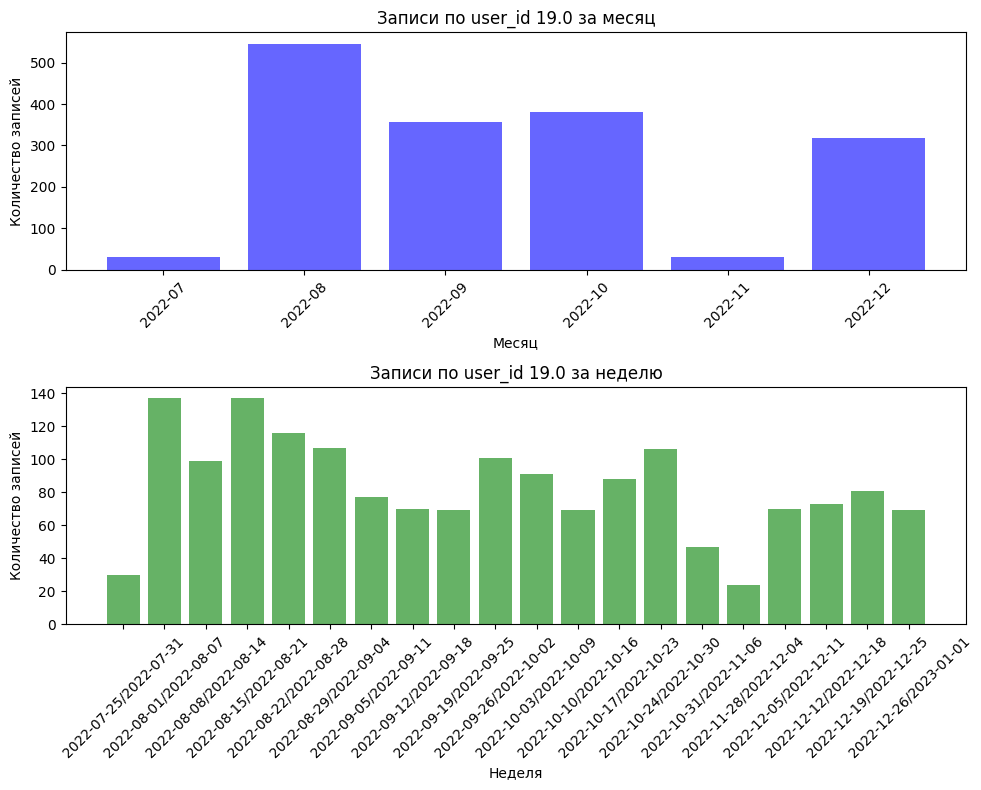

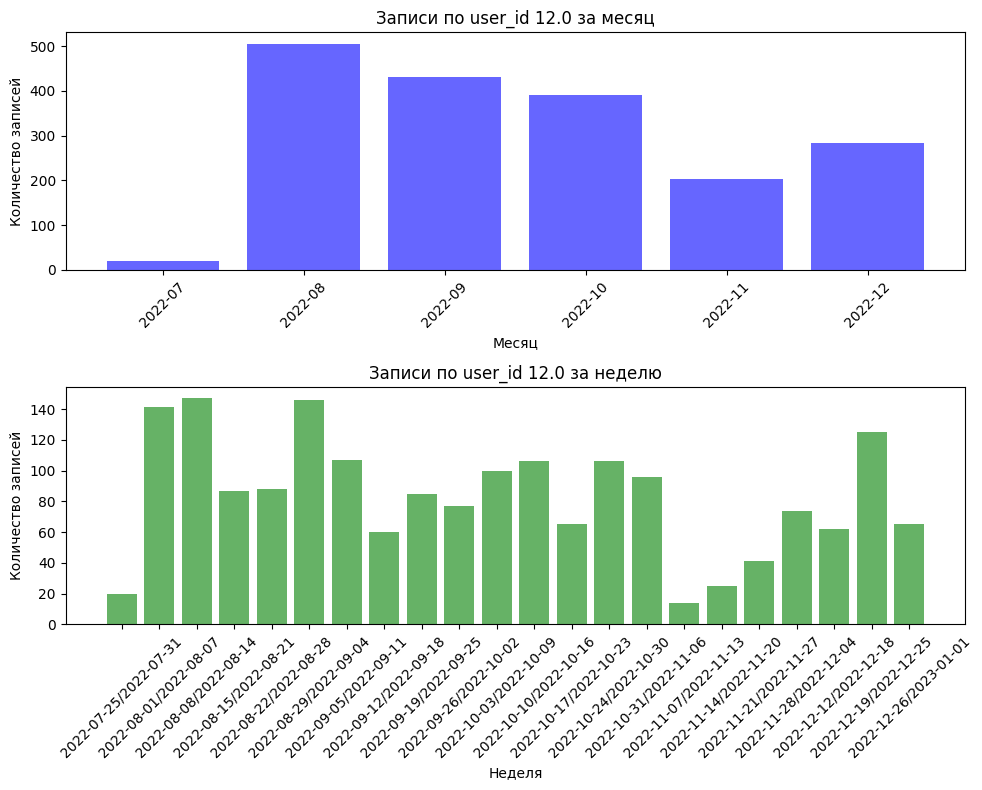

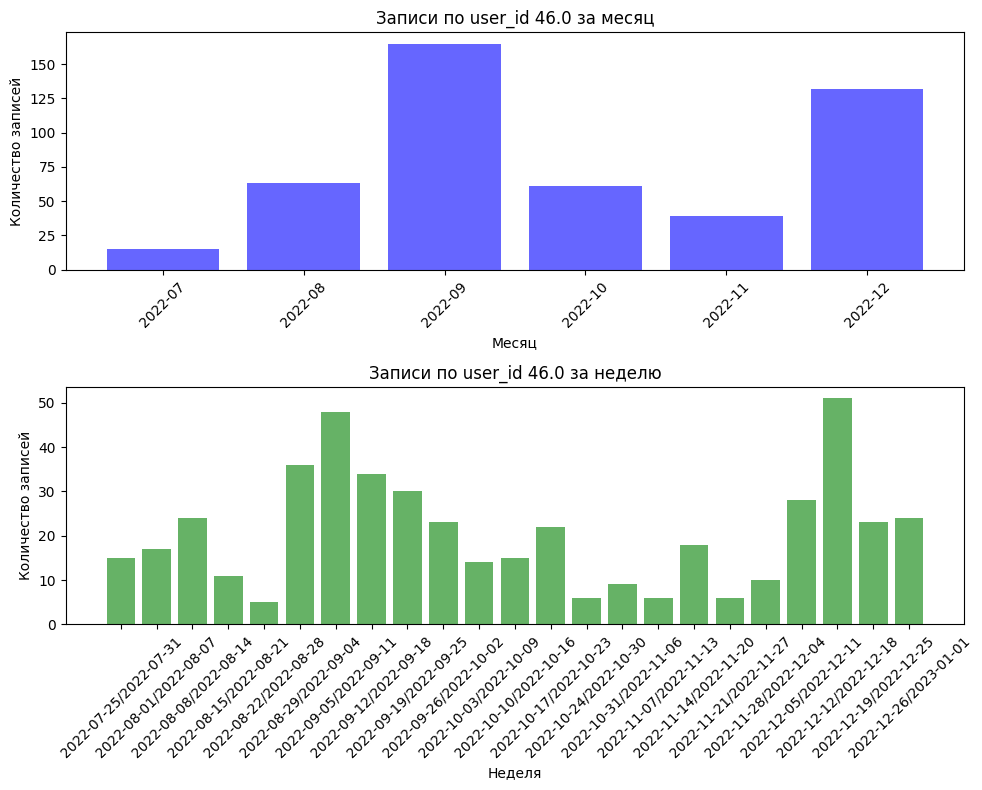

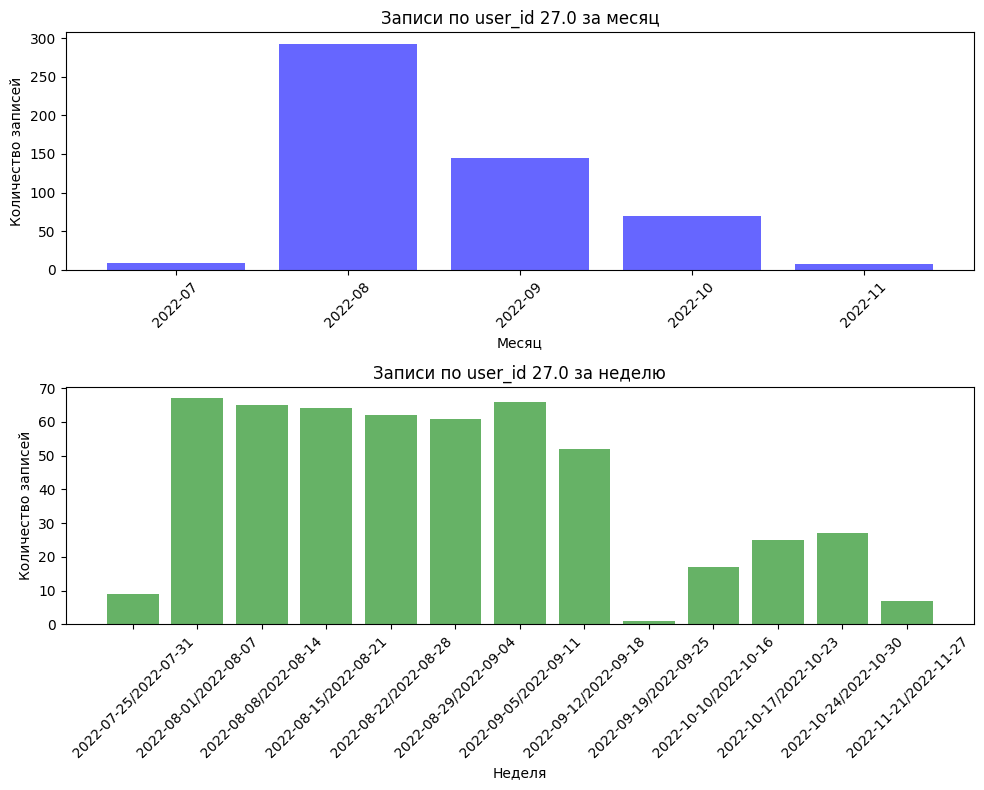

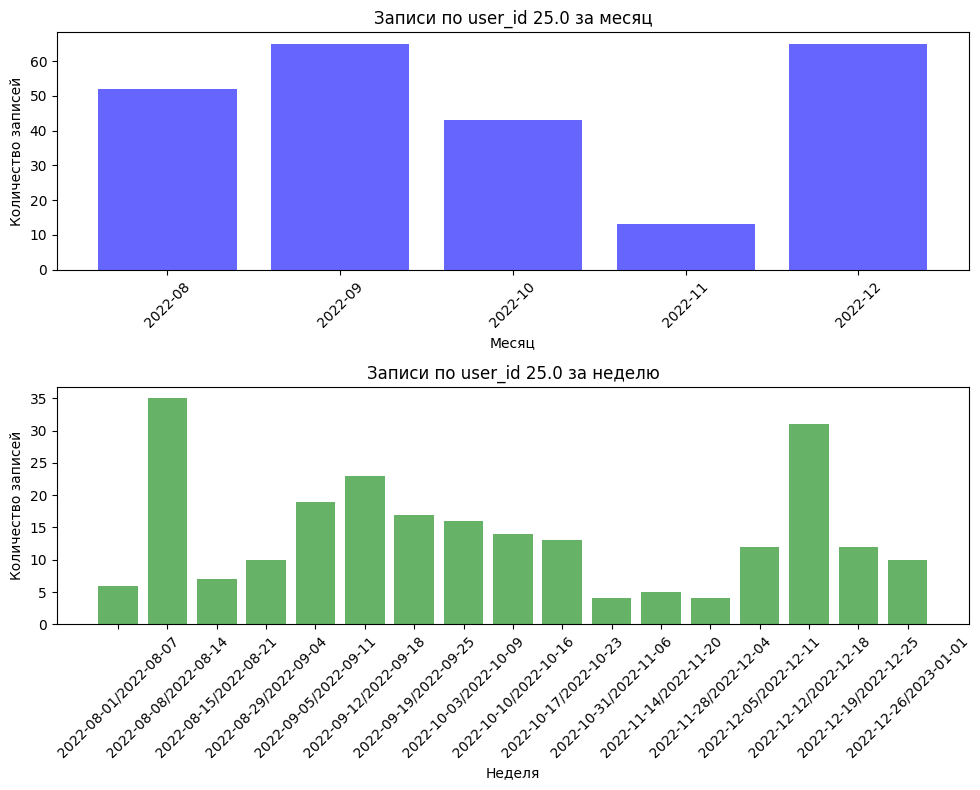

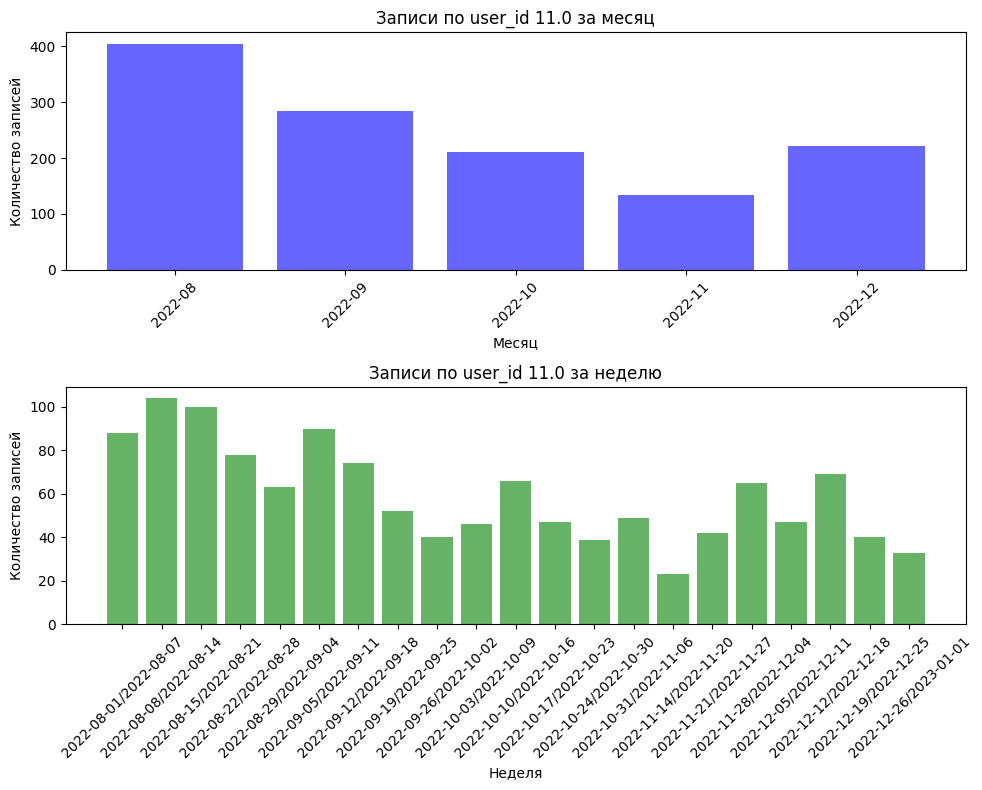

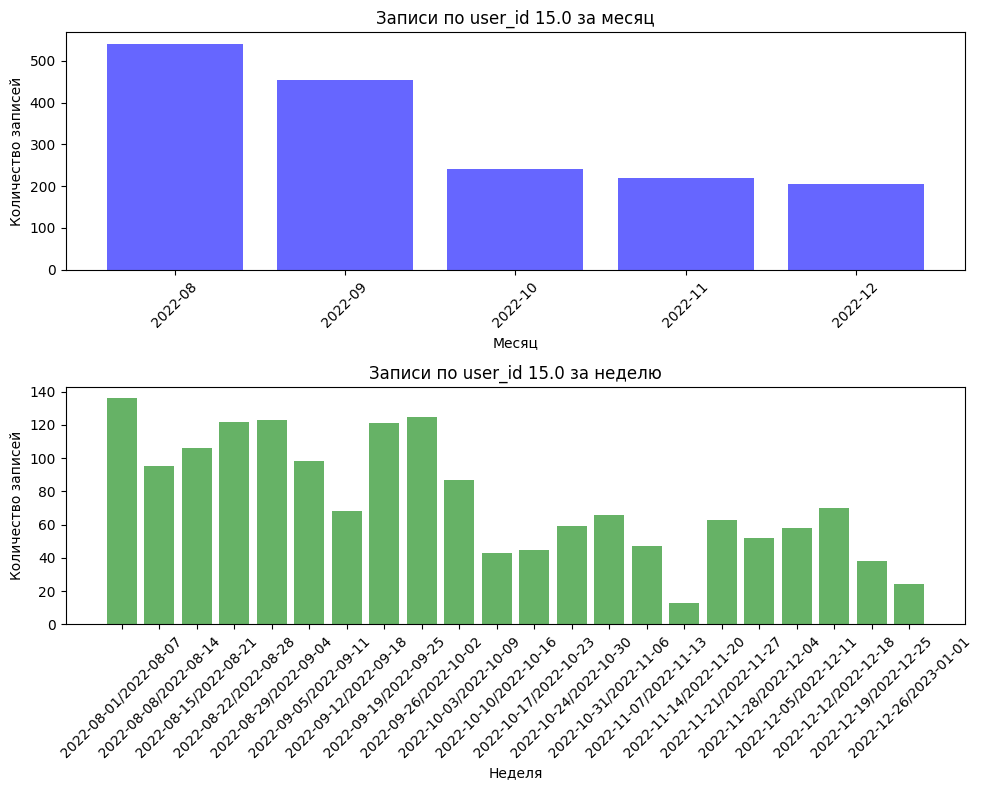

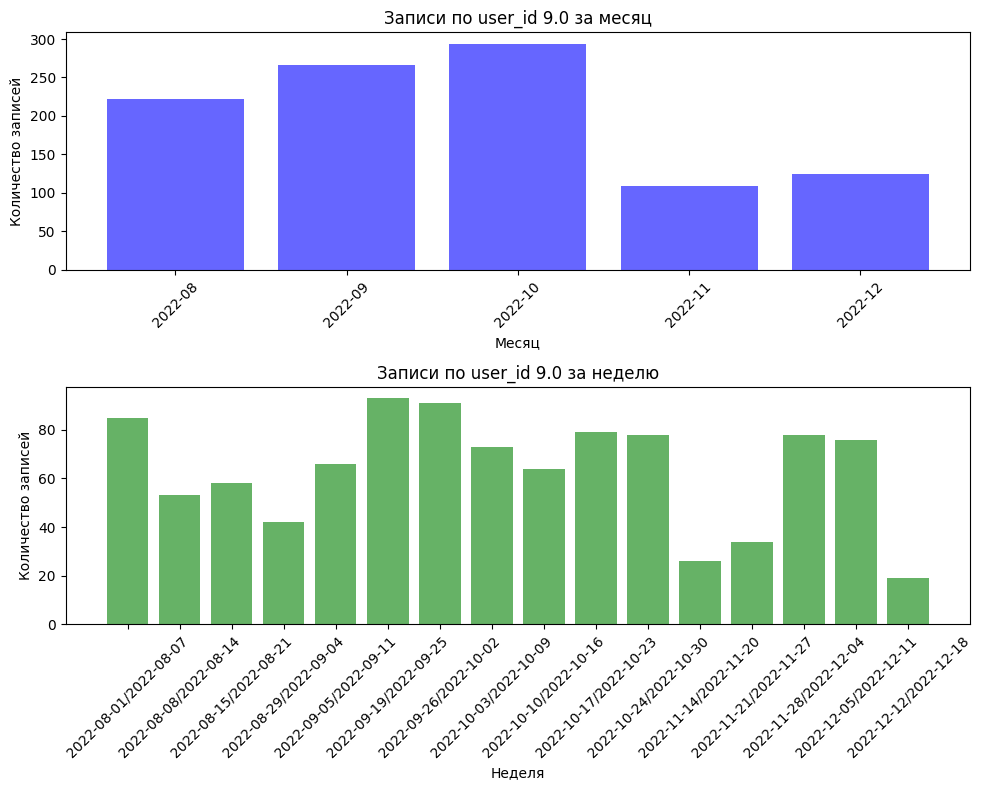

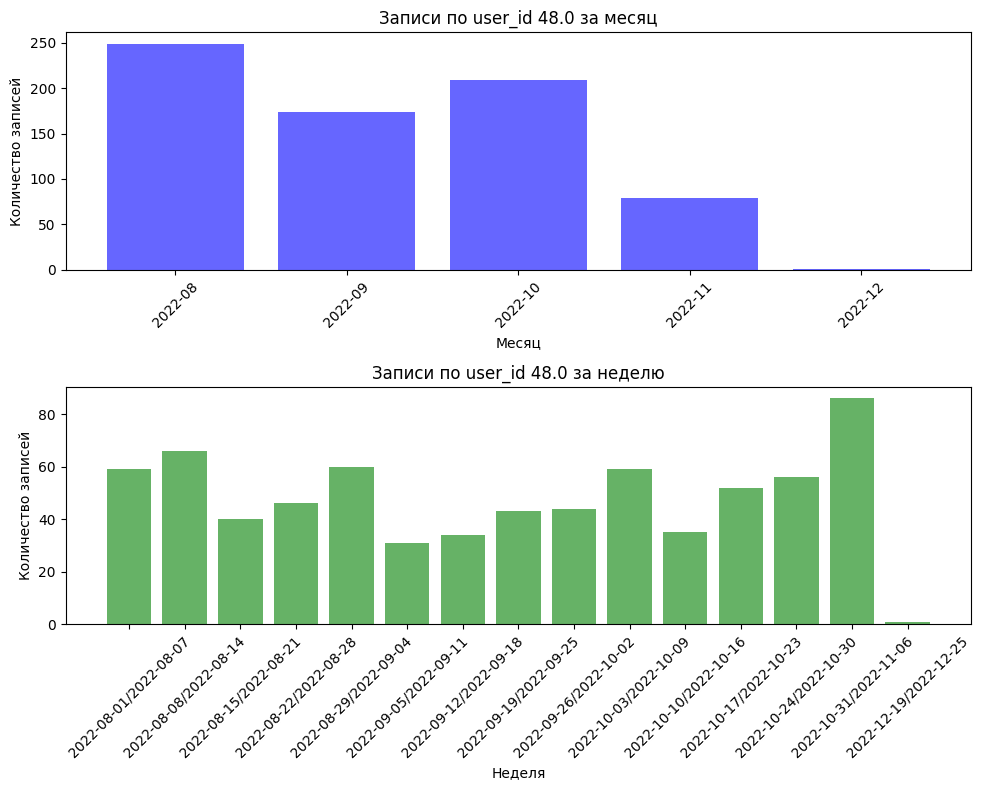

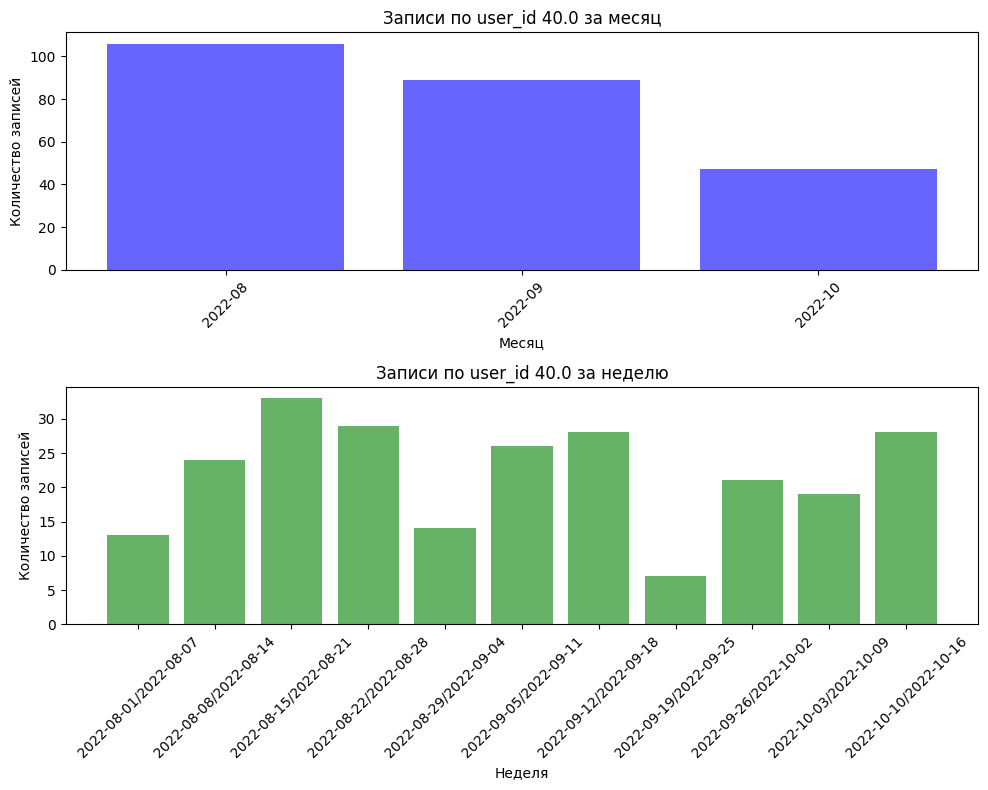

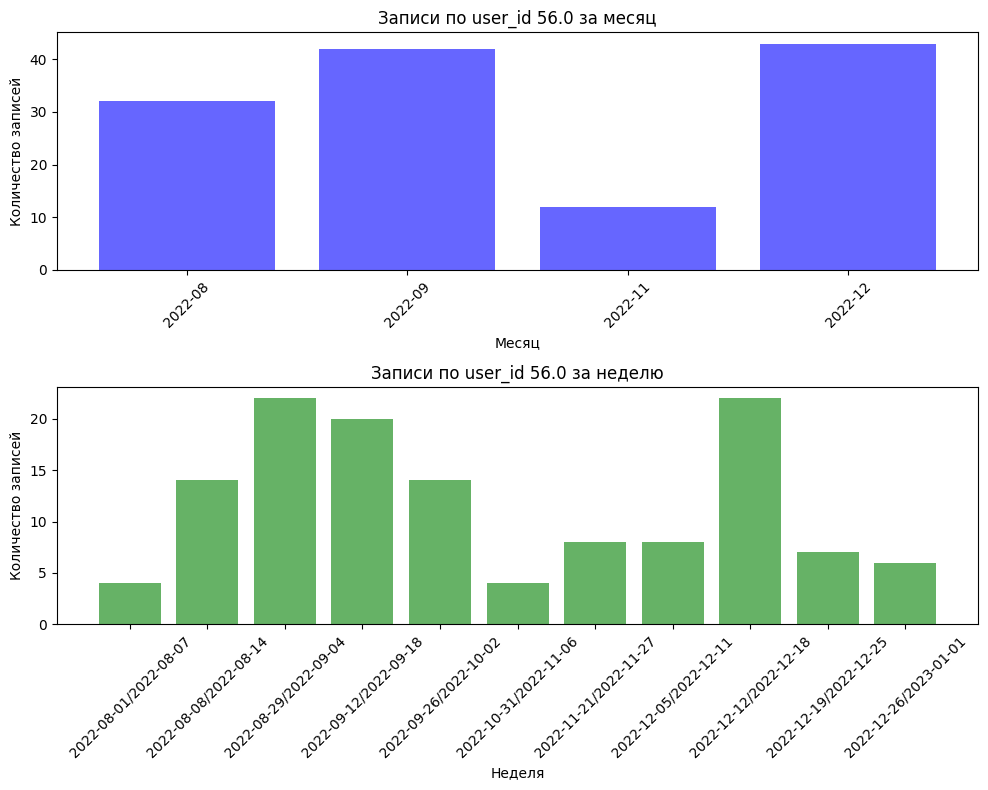

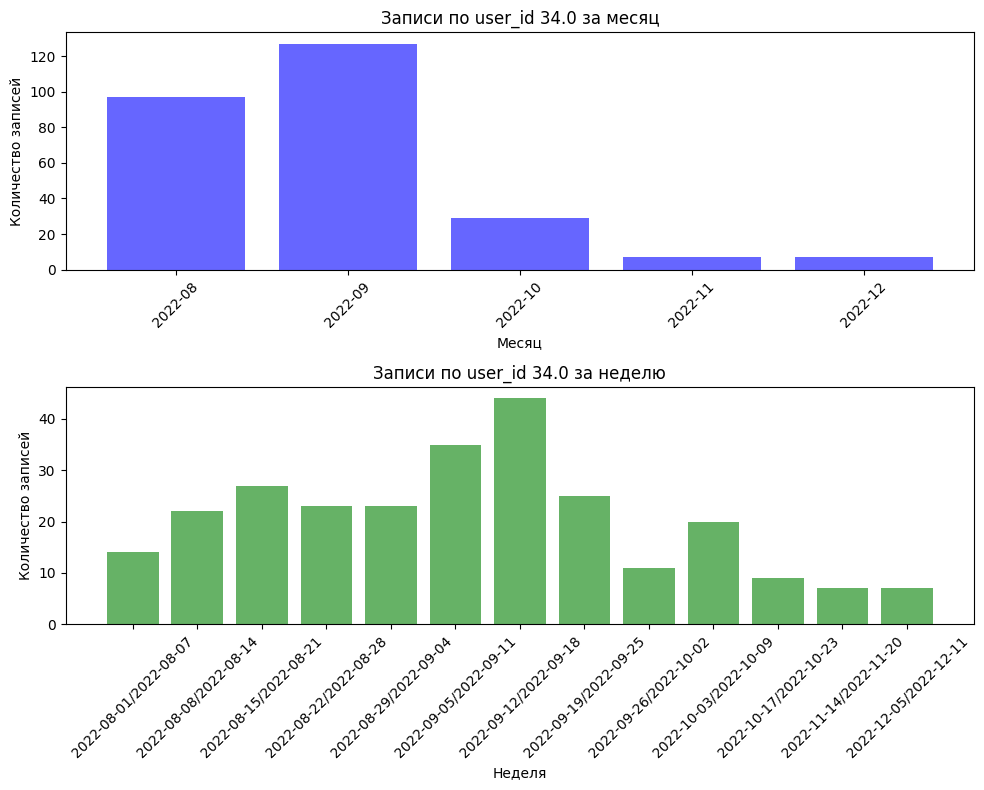

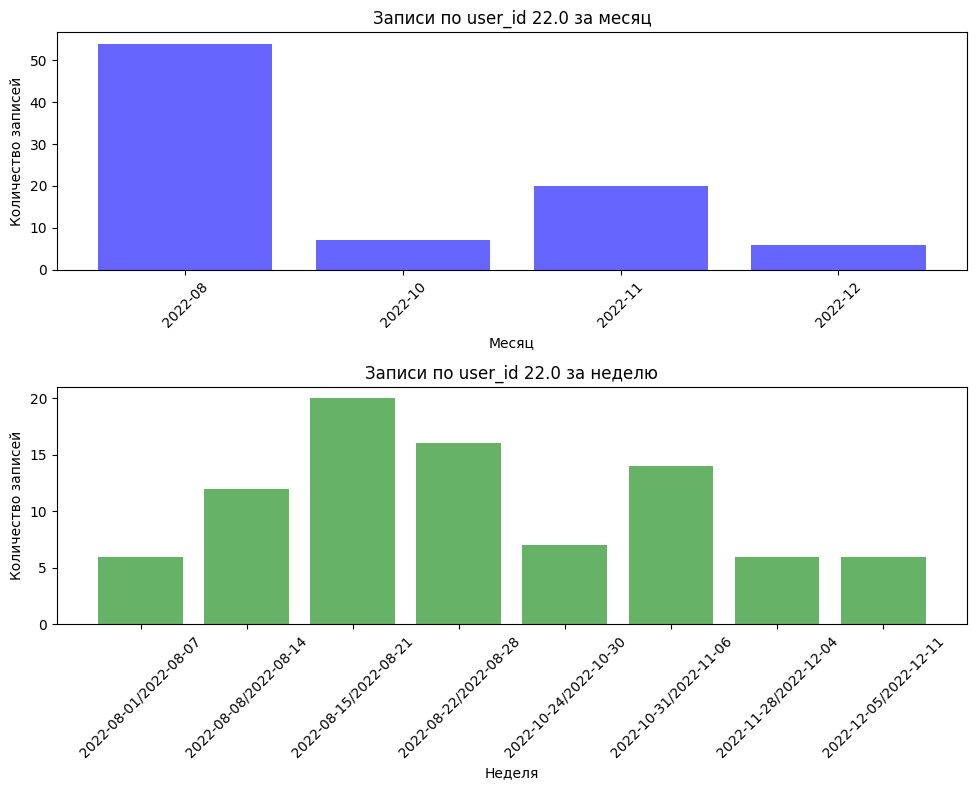

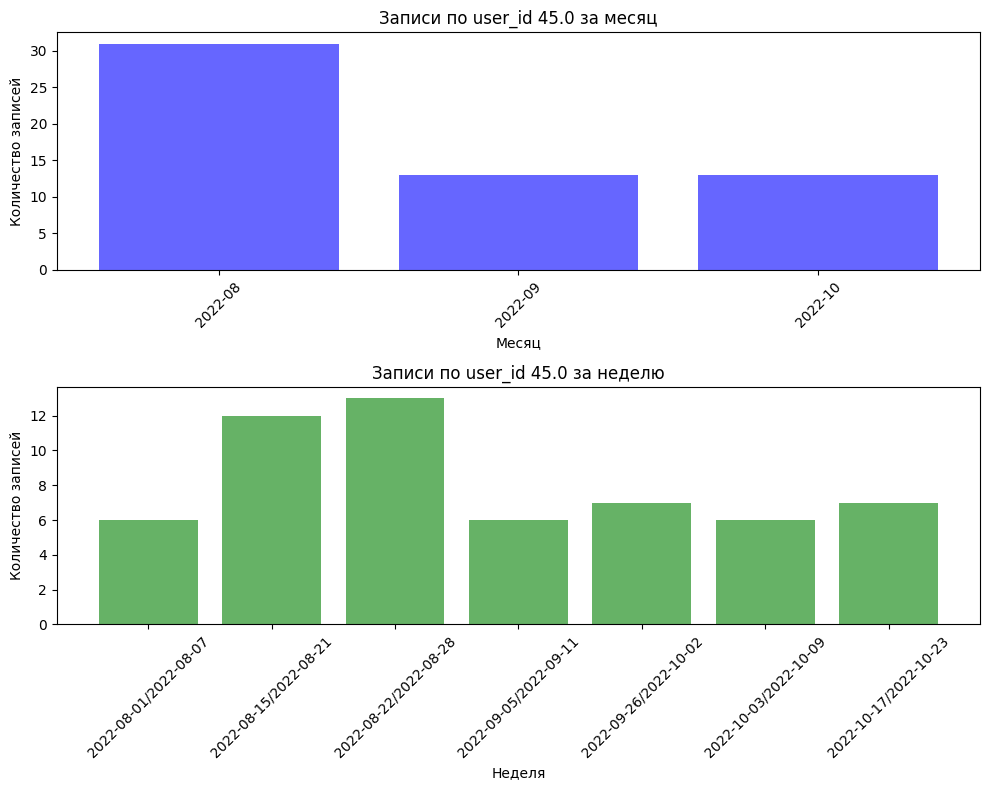

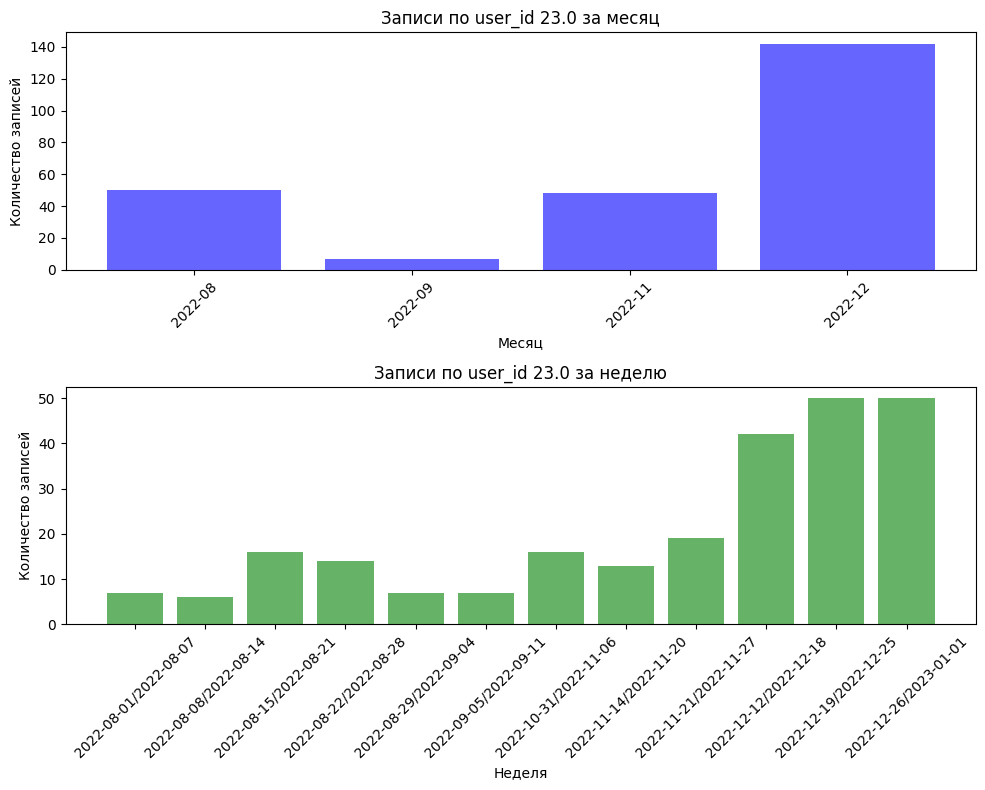

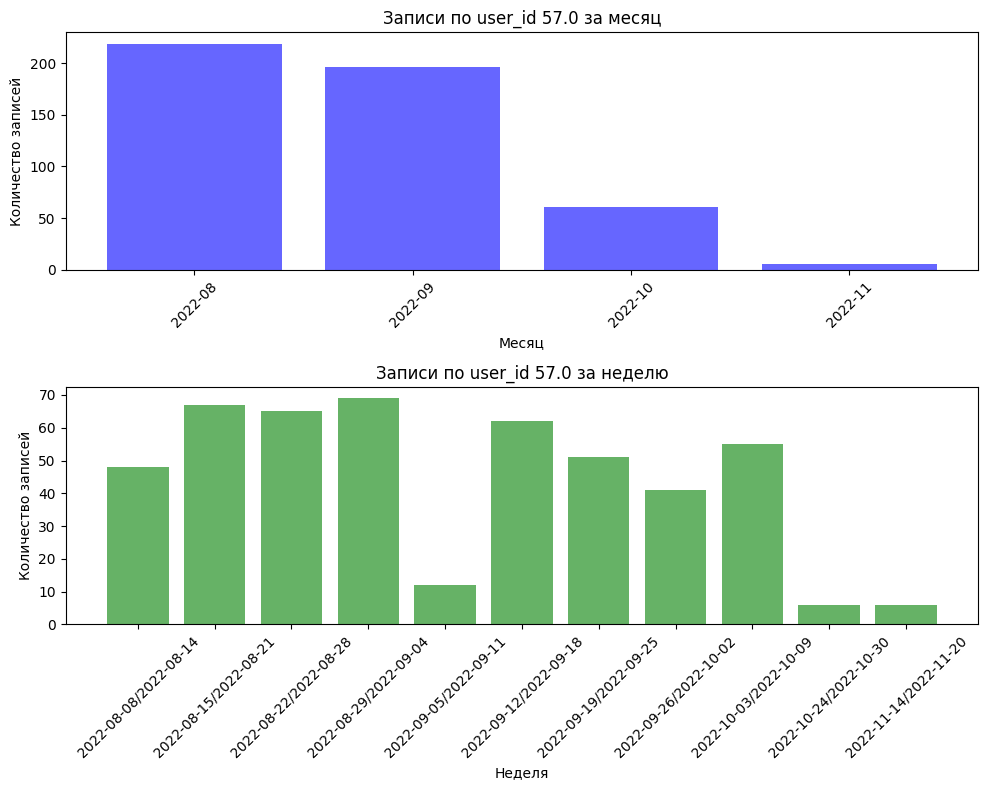

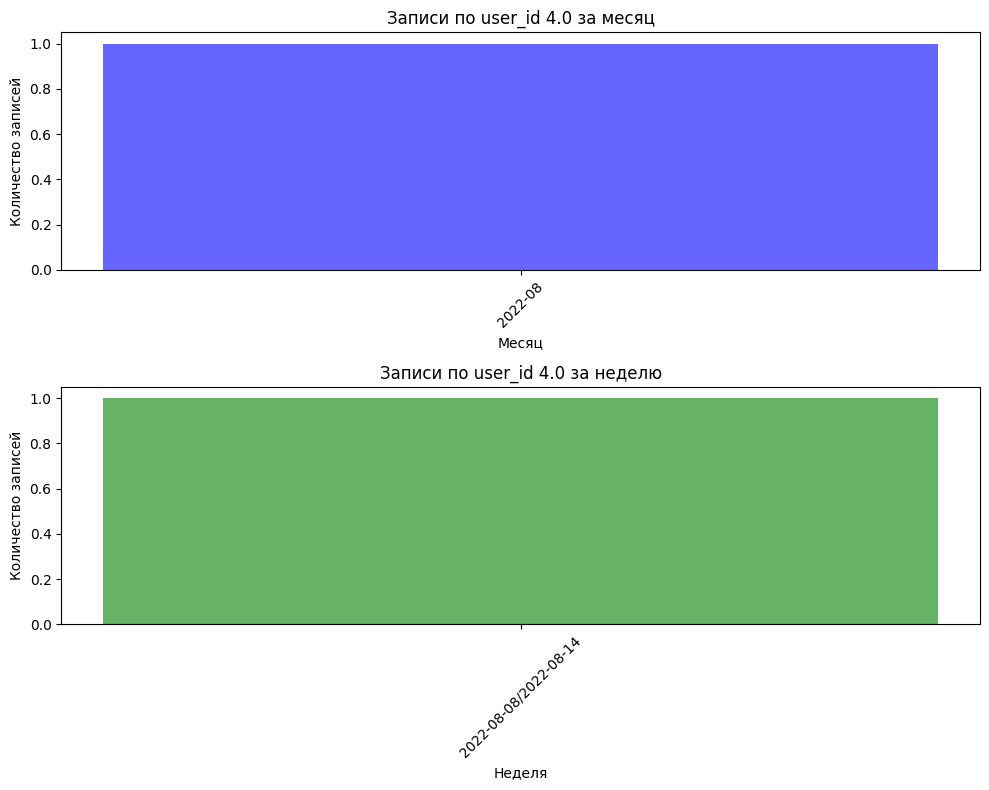

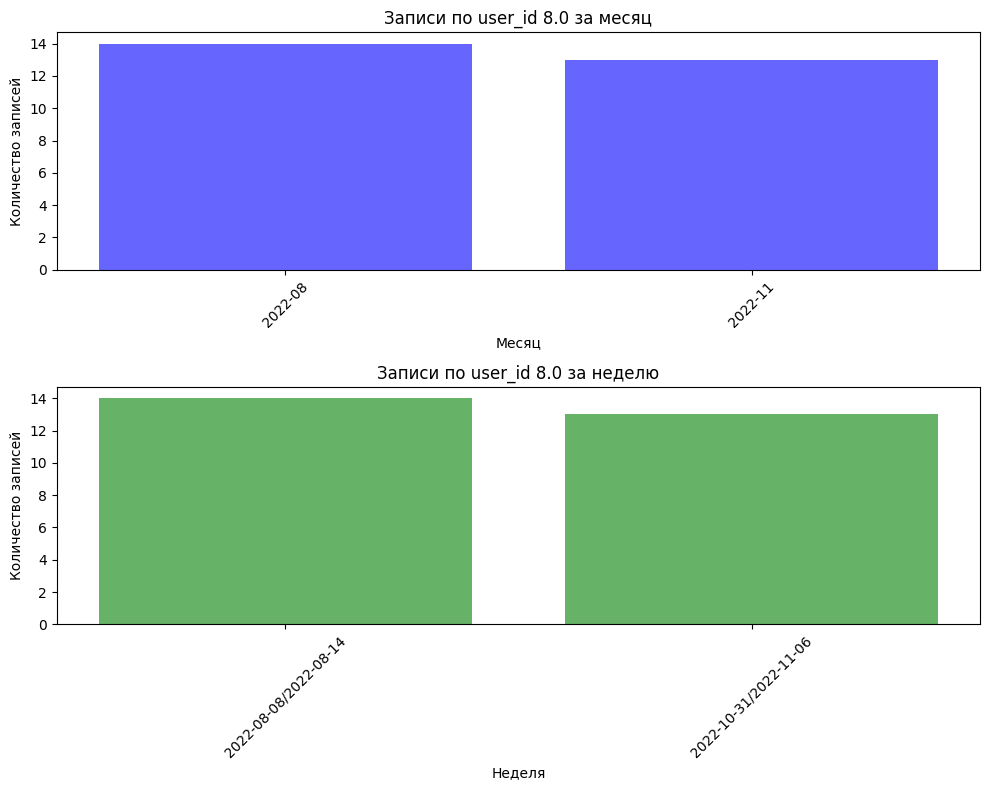

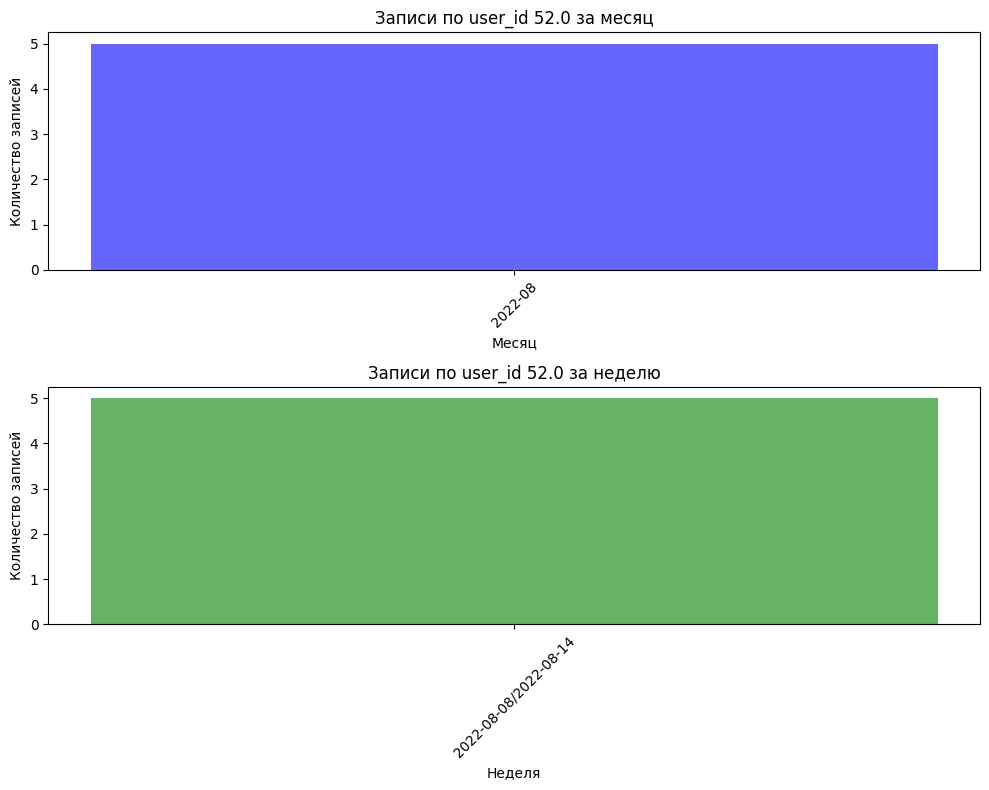

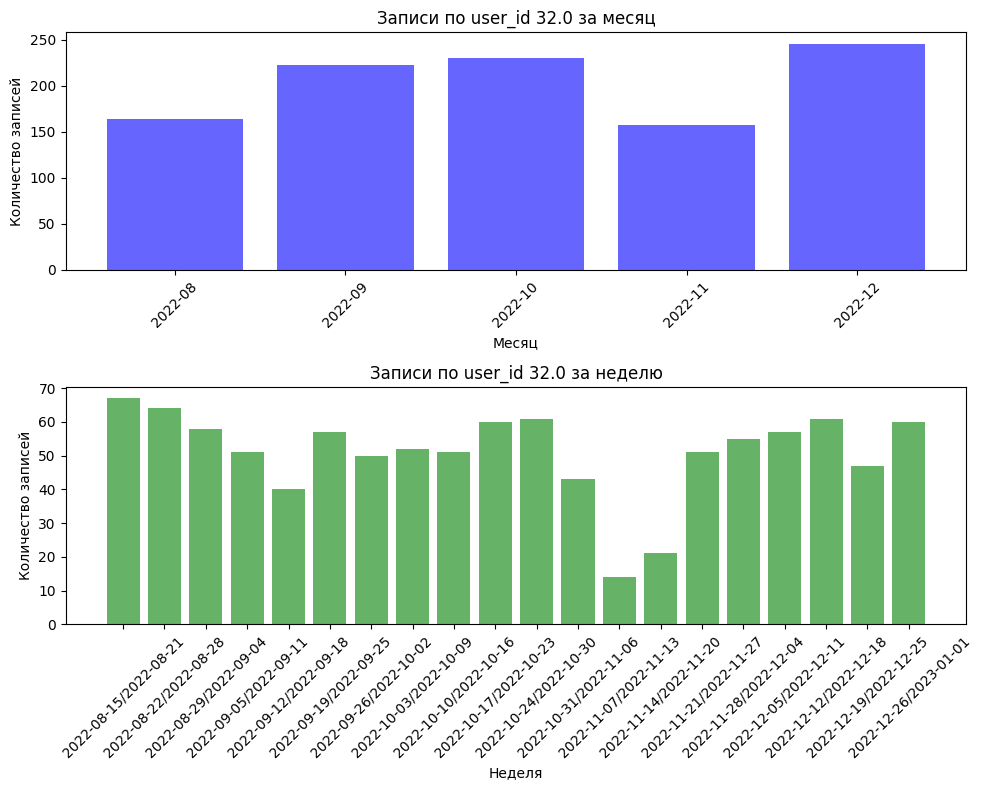

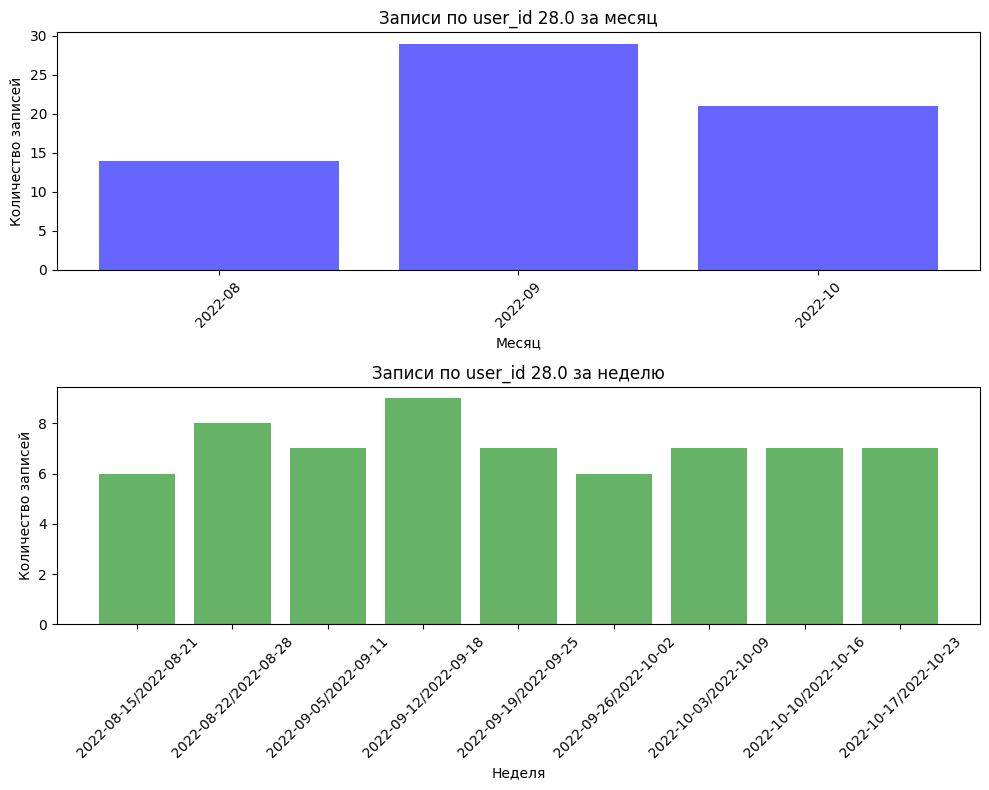

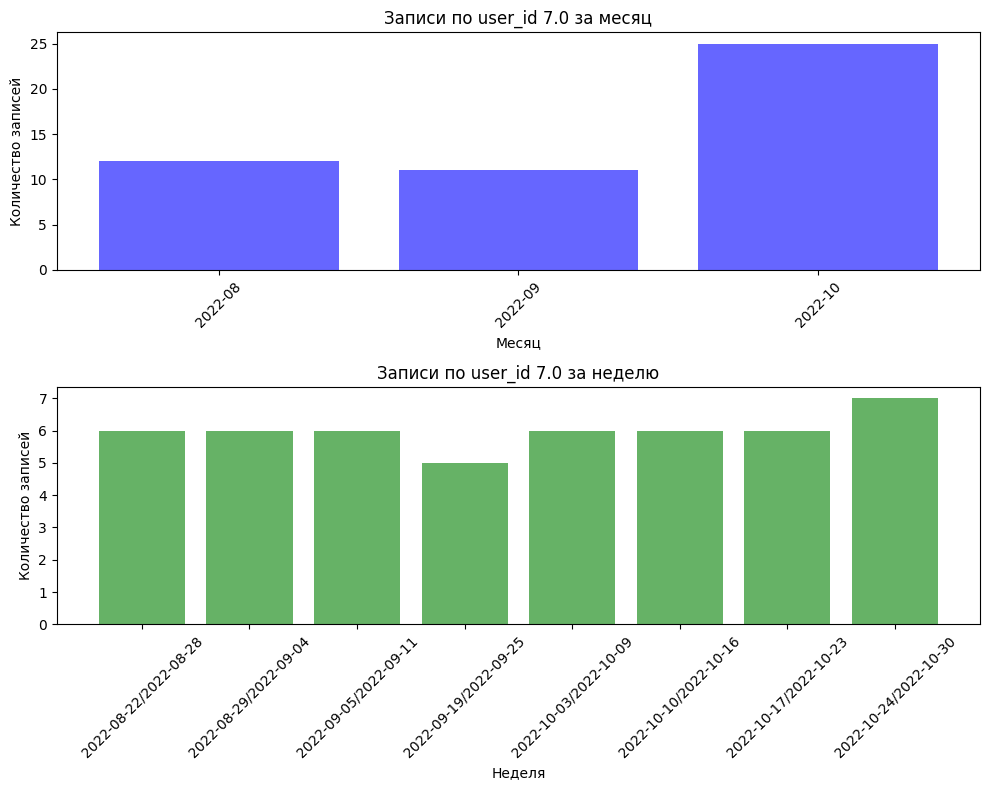

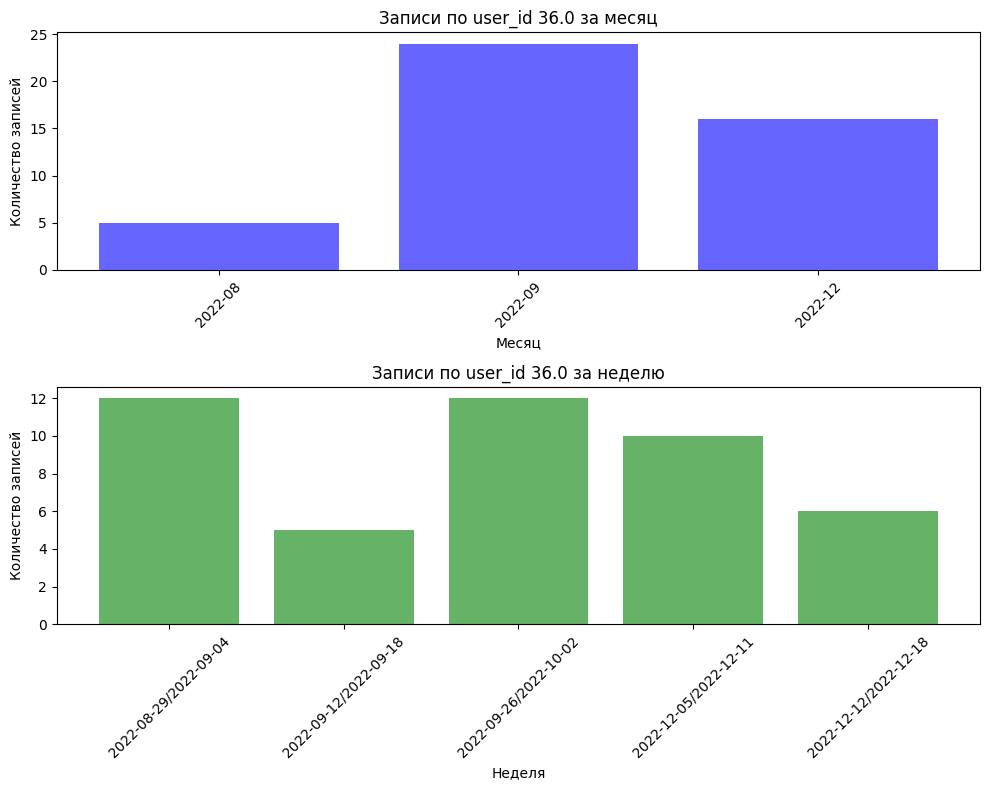

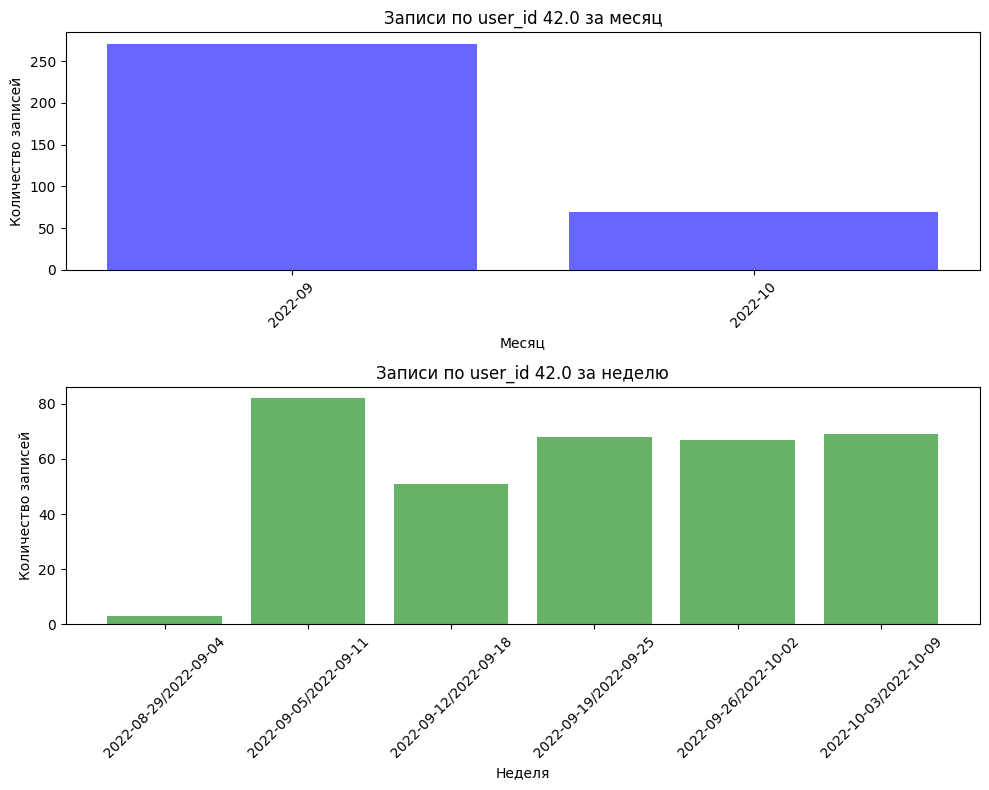

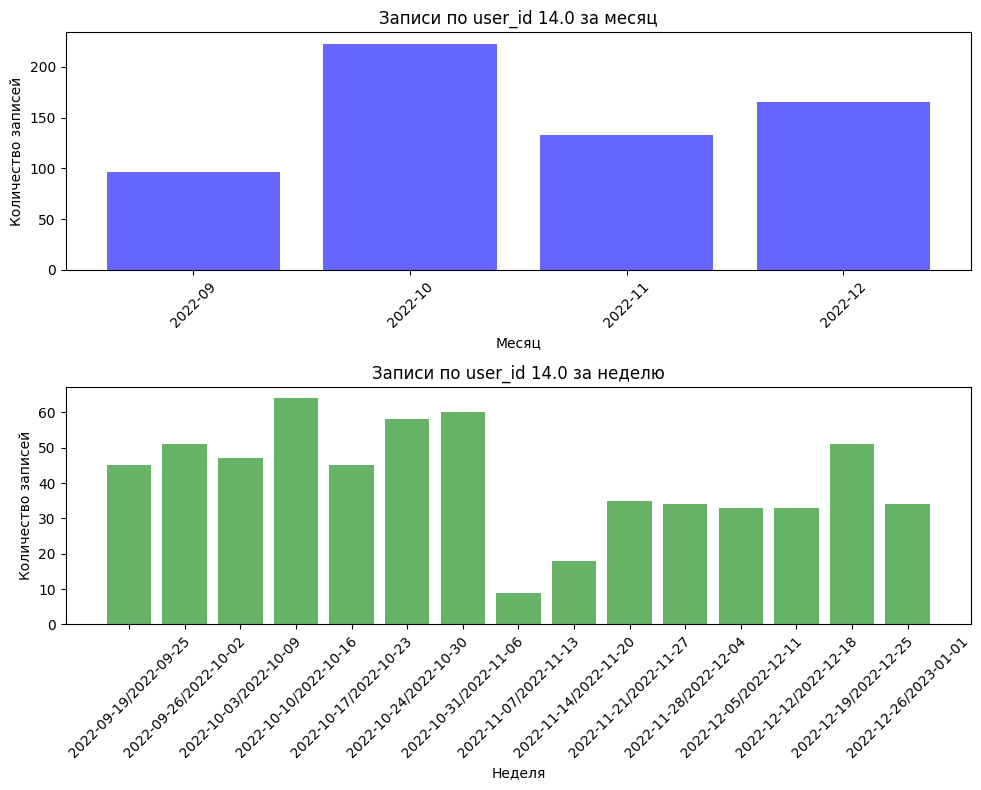

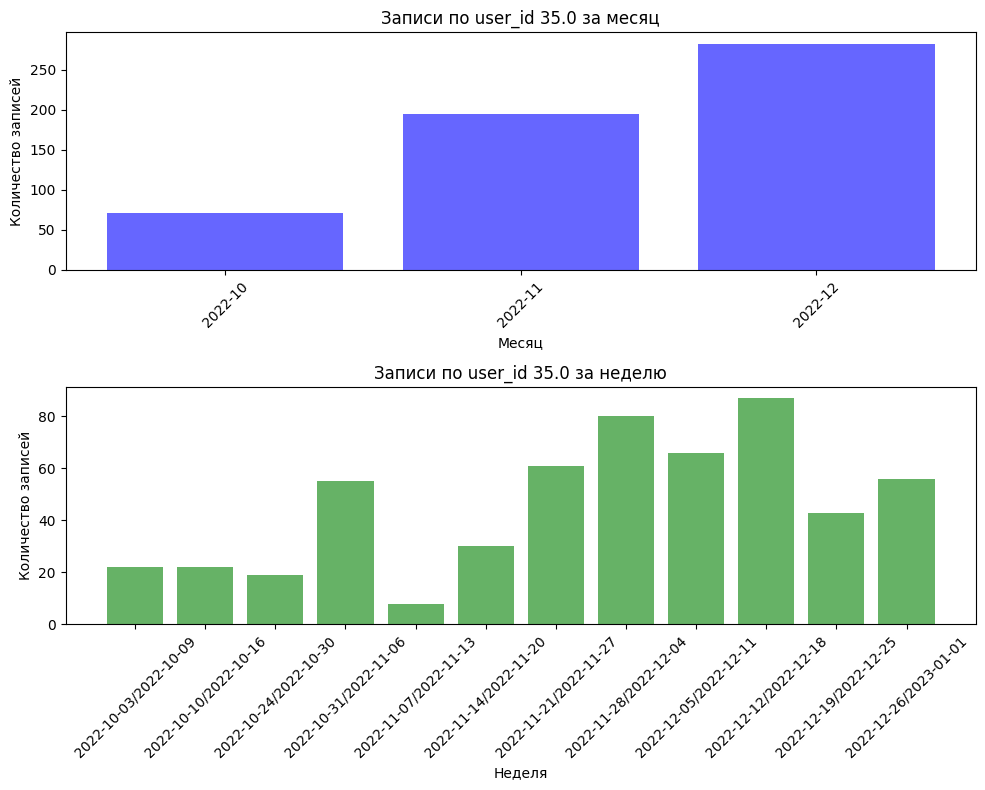

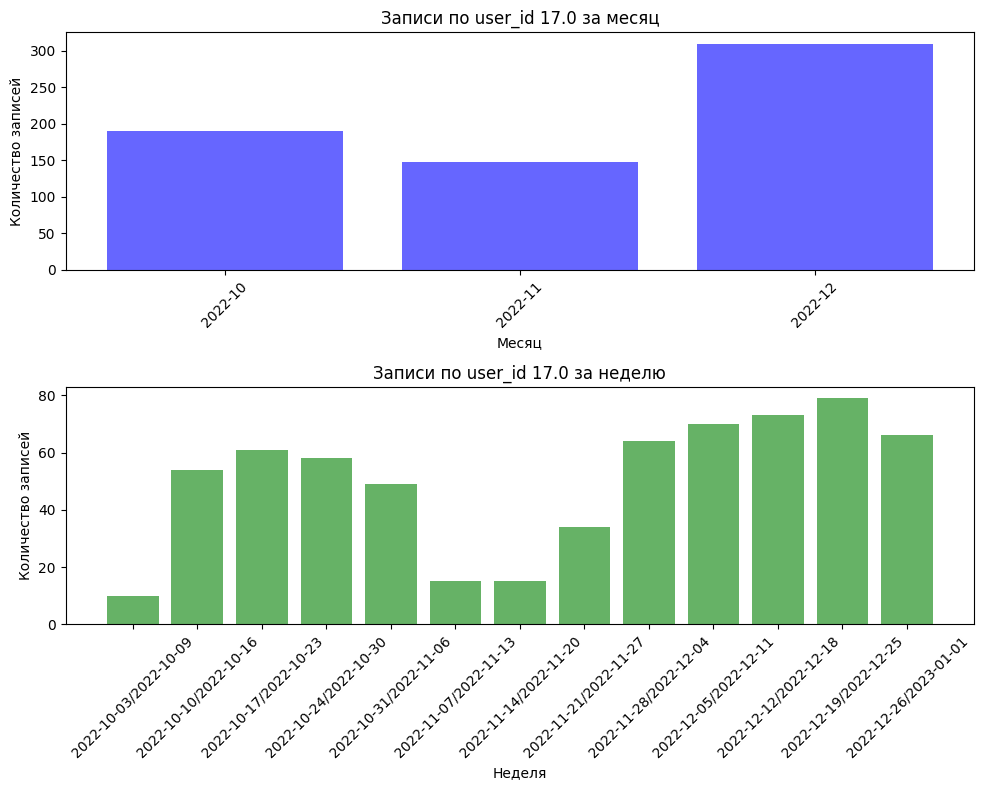

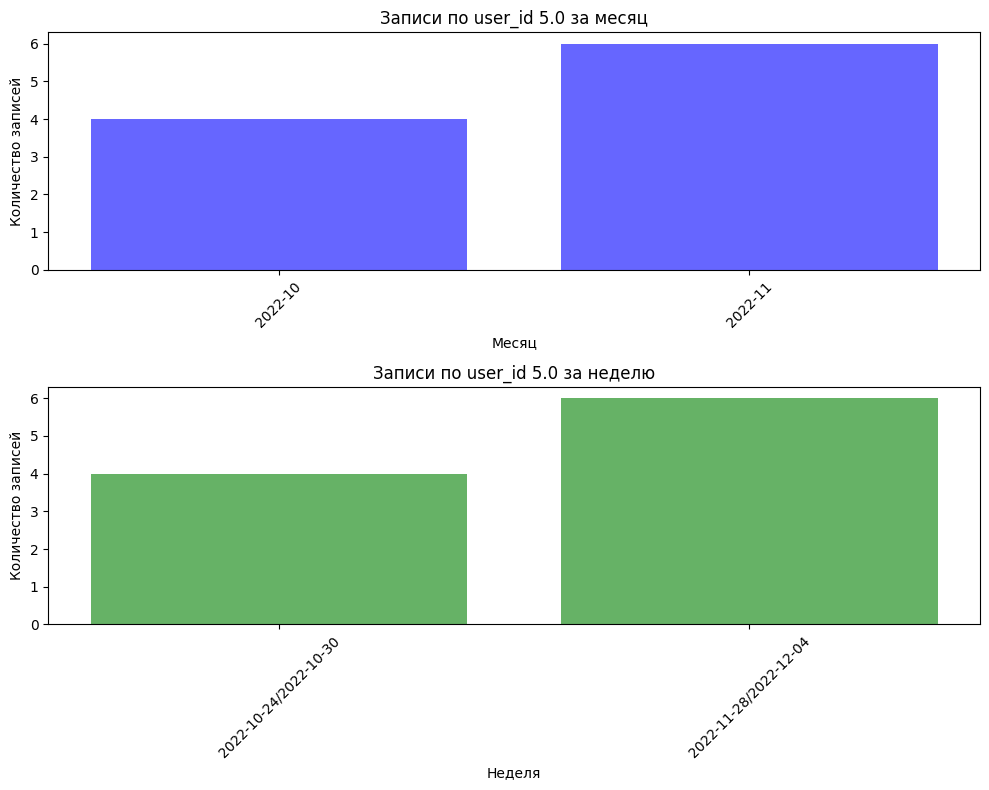

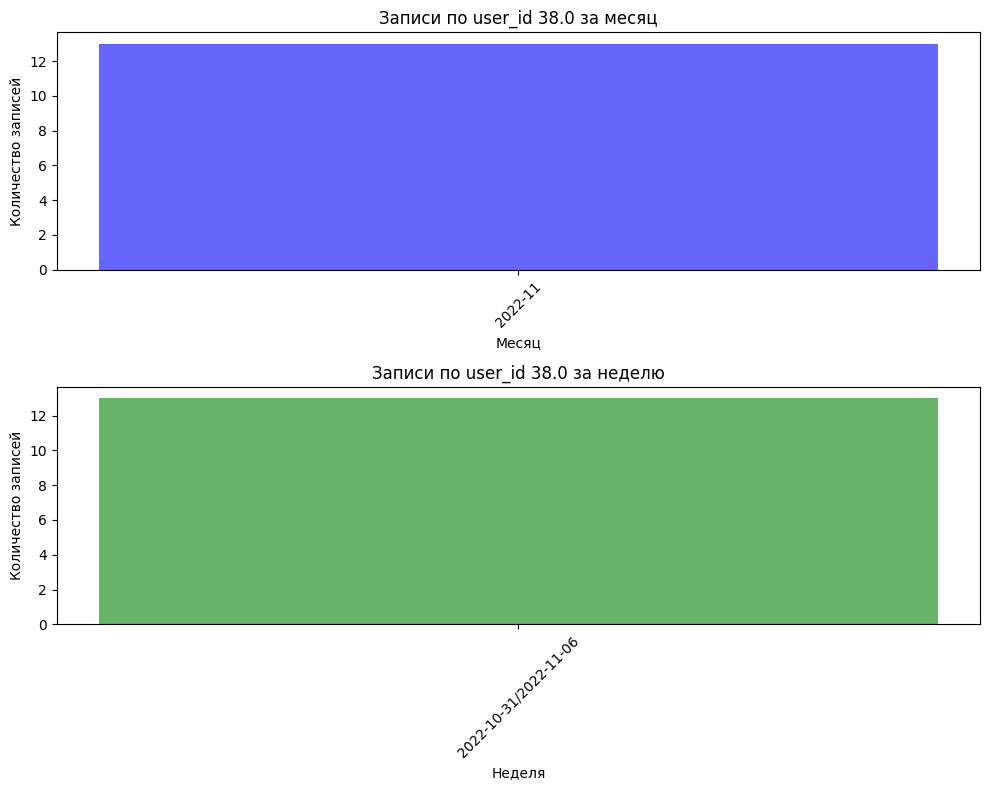

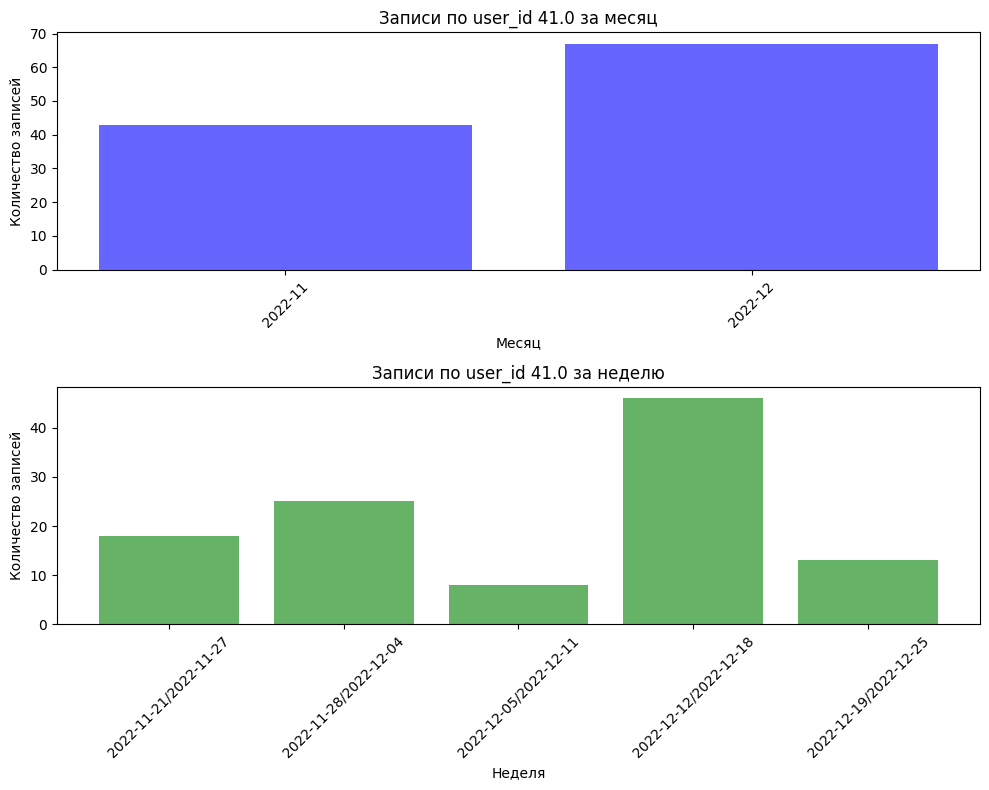

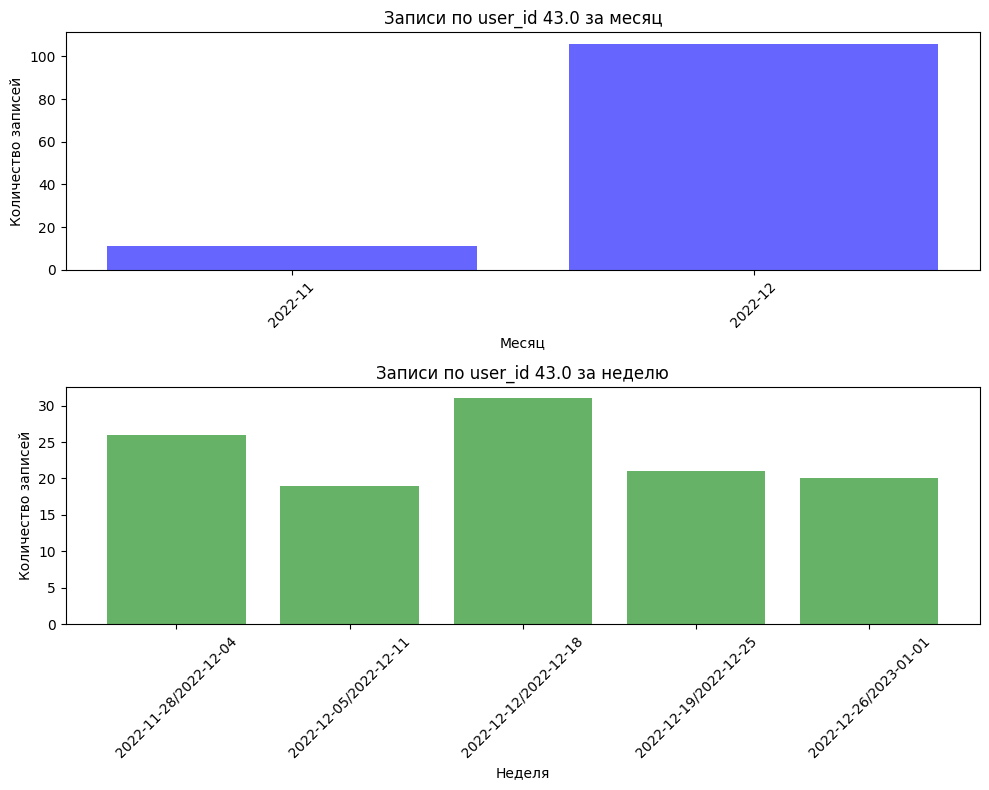

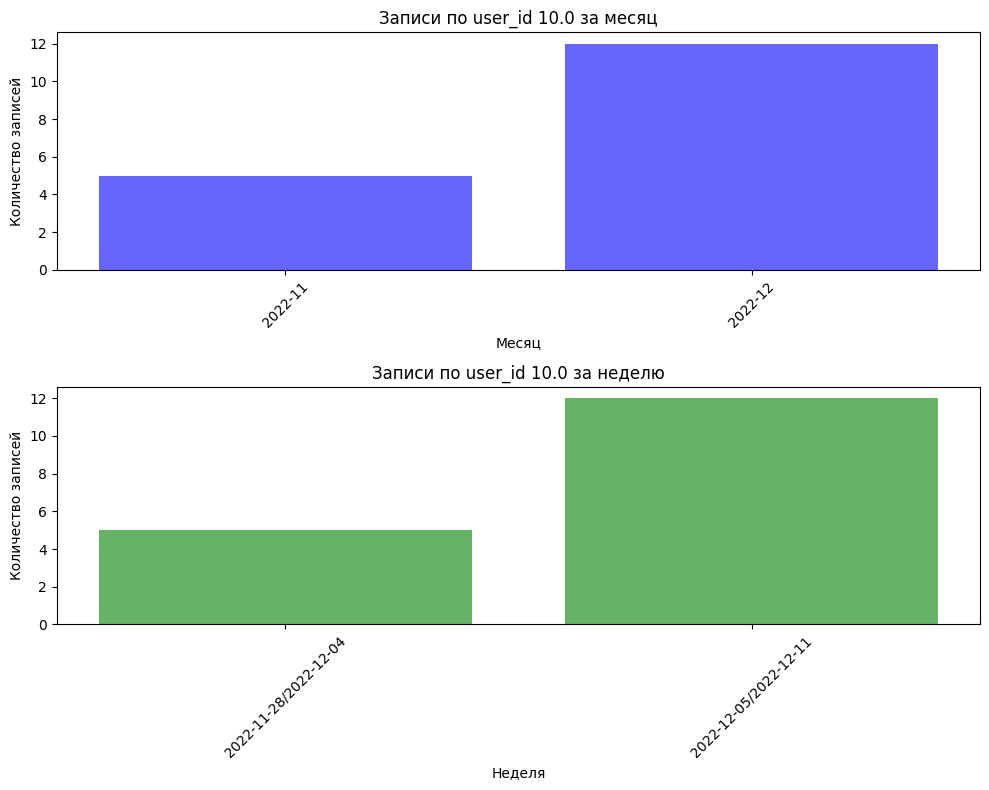

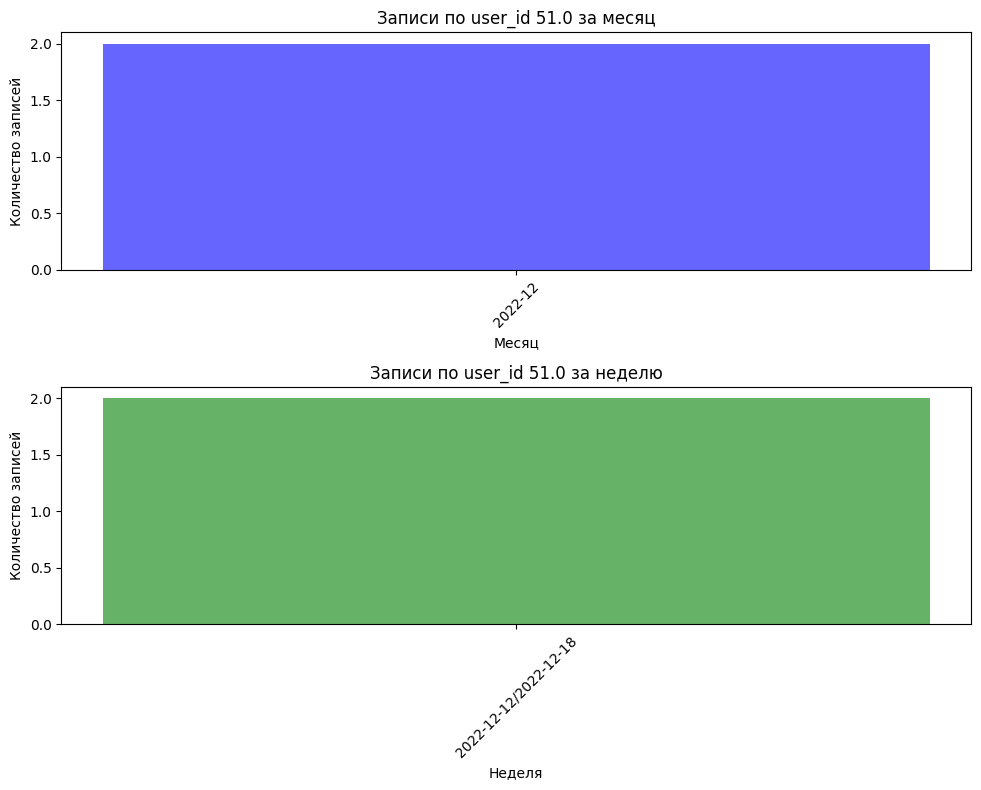

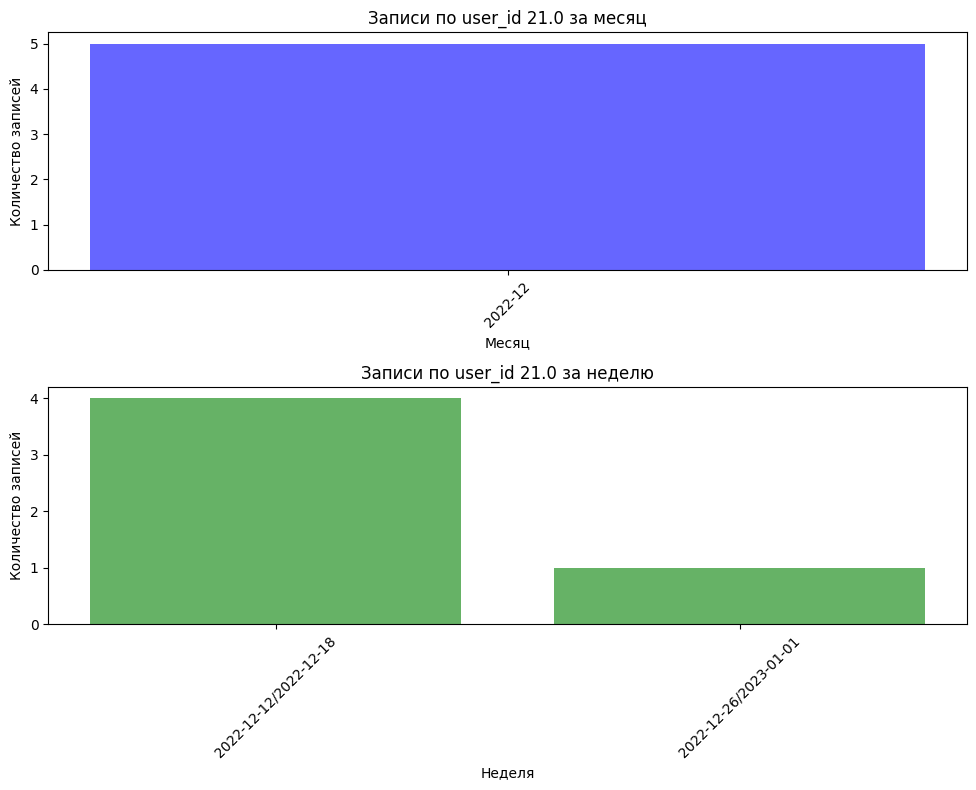

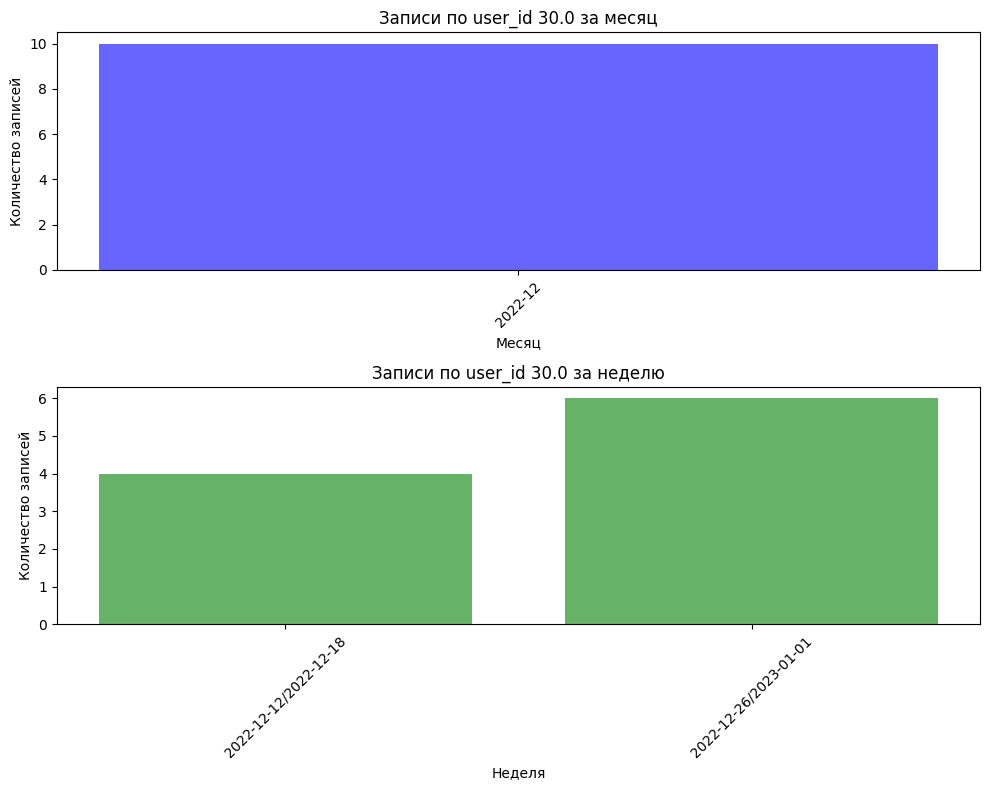

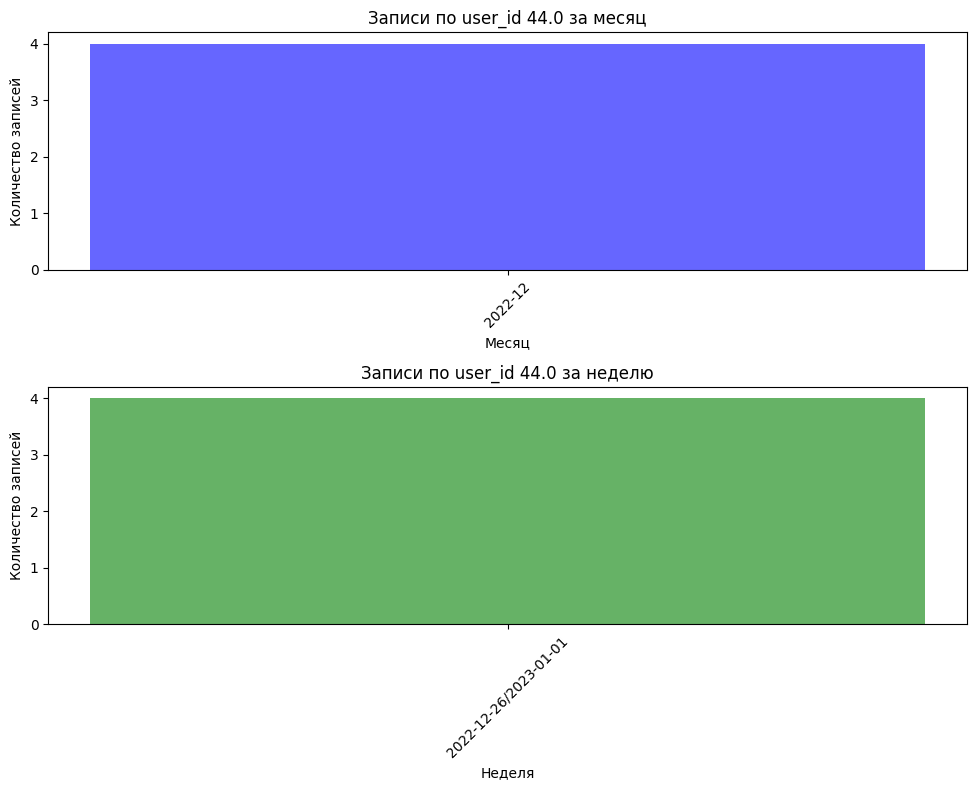

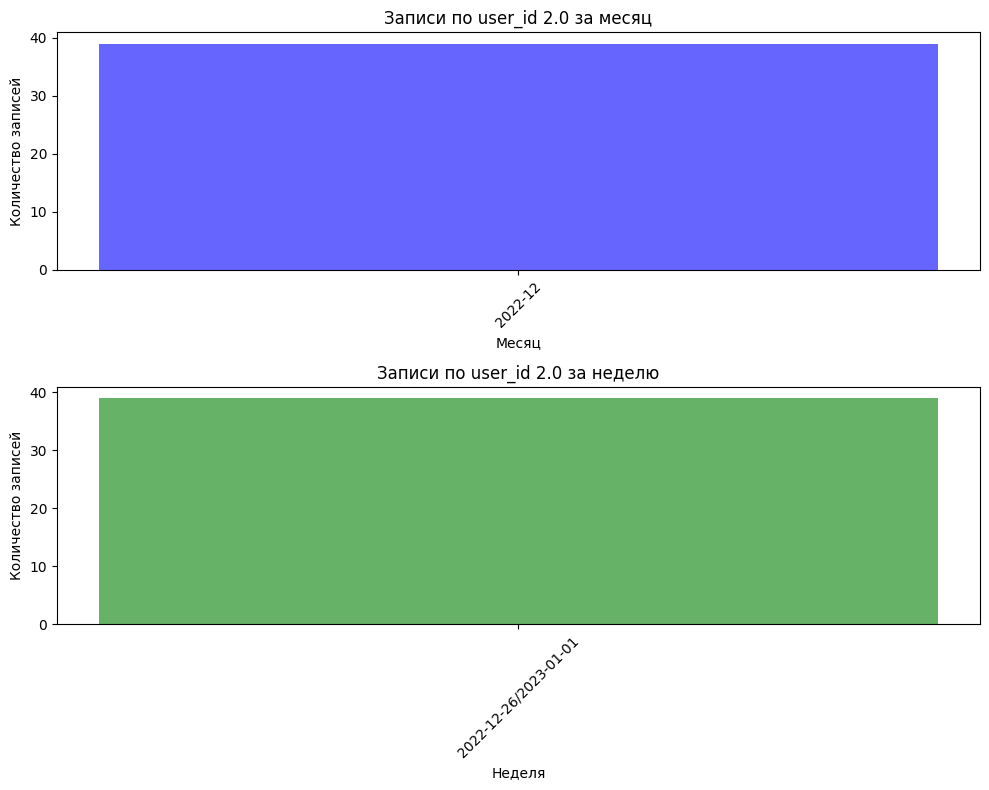

In [ ]:
# Исследуем user_id на постоянство расписаний. Построим столбчатые диаграммы с количеством переходов через gate_id каждого пользователя в месяц/неделю.

all_data_with_time = all_data.copy()

# Добавляем столбцы для года-месяца и года-недели
all_data_with_time['month'] = all_data_with_time['ts'].dt.to_period('M')  # Группировка по месяцам
all_data_with_time['week'] = all_data_with_time['ts'].dt.to_period('W')  # Группировка по неделям

for user in all_data['user_id'].unique():
    # Фильтруем данные по конкретному пользователю
    user_data = all_data_with_time[all_data_with_time['user_id'] == user]

    if user_data.empty:  # Если данных нет, пропускаем пользователя
        continue

    # Считаем количество записей по месяцам и неделям
    monthly_counts = user_data.groupby('month').size()
    weekly_counts = user_data.groupby('week').size()

    # Создаём фигуру с двумя графиками
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Гистограмма за месяц
    axes[0].bar(monthly_counts.index.astype(str), monthly_counts.values, color='blue', alpha=0.6)
    axes[0].set_xlabel("Месяц")
    axes[0].set_ylabel("Количество записей")
    axes[0].set_title(f"Записи по user_id {user} за месяц")
    axes[0].tick_params(axis='x', rotation=45)

    # Гистограмма за неделю
    axes[1].bar(weekly_counts.index.astype(str), weekly_counts.values, color='green', alpha=0.6)
    axes[1].set_xlabel("Неделя")
    axes[1].set_ylabel("Количество записей")
    axes[1].set_title(f"Записи по user_id {user} за неделю")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()





Количество посещений ворот в течение месяца и недели различное практически для каждого пользователя в разные периоды времени. Считаю, что выделять новую аггрегирующую фичу не стоит

## Исследование gate_id

In [ ]:
all_data['gate_id'].value_counts()

gate_id
 4     9411
 3     6113
 10    5682
 5     5407
 11    4852
 7     3566
 9     2123
 6     2023
 13    1397
 12     739
 15     400
 8       34
-1       26
 1        7
 16       4
 2        4
 0        2
 14       2
Name: count, dtype: int64

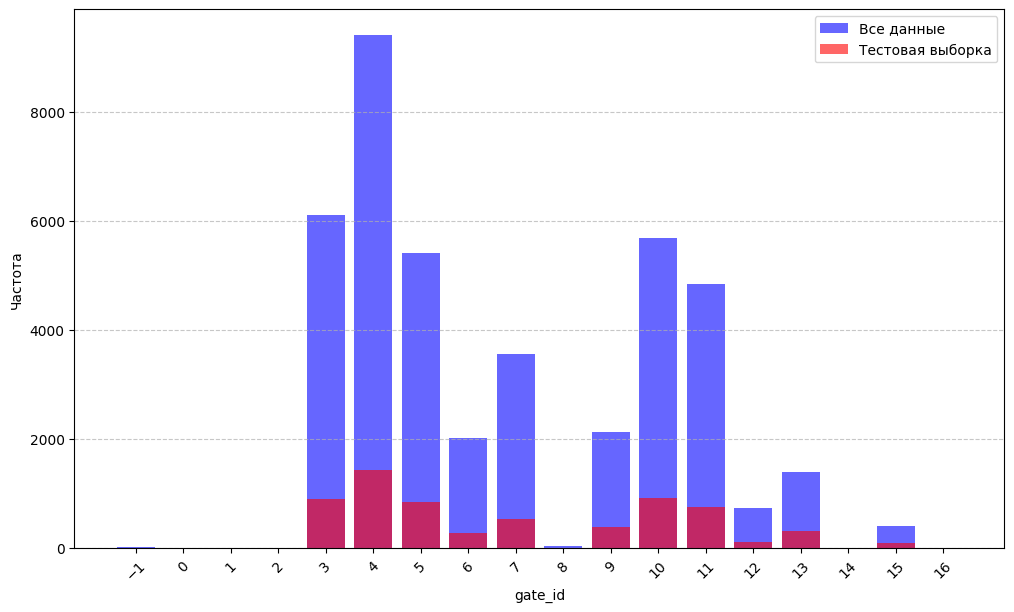

In [ ]:
# Считаем частоты для gate_id в основной и тестовой выборках
counts_all = all_data['gate_id'].value_counts().sort_index()
counts_test = test['gate_id'].value_counts().sort_index()

plt.figure(figsize=(12, 7))

# Строим гистограммы с наложением
plt.bar(counts_all.index, counts_all.values, color='blue', alpha=0.6, label='Все данные')
plt.bar(counts_test.index, counts_test.values, color='red', alpha=0.6, label='Тестовая выборка')

# Устанавливаем метки оси X для всех значений
xticks = np.arange(min(counts_all.index.min(), counts_test.index.min()),
                   max(counts_all.index.max(), counts_test.index.max()) + 1)
plt.xticks(xticks, rotation=45)

# Добавляем подписи и легенду
plt.xlabel('gate_id')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
# Нарисуем столбчатую диаграмму для каждого user id

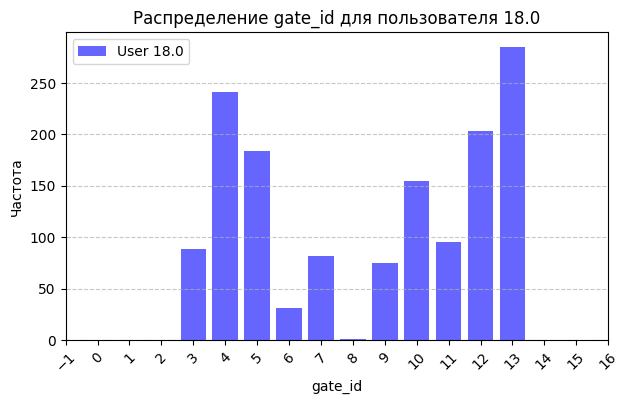

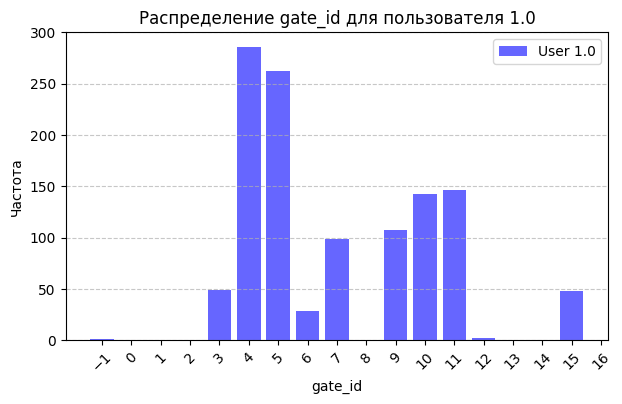

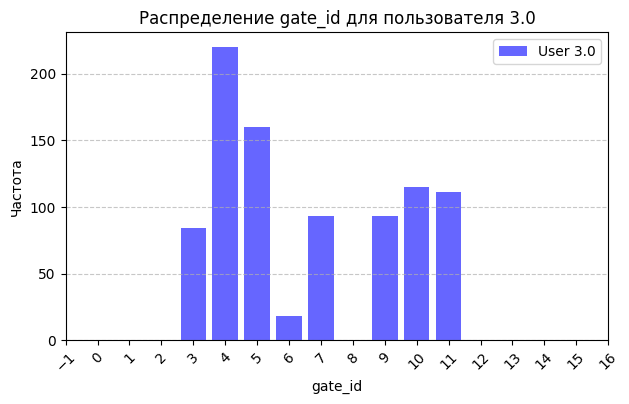

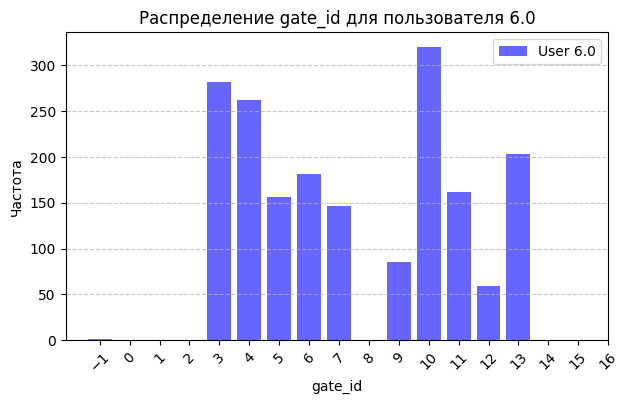

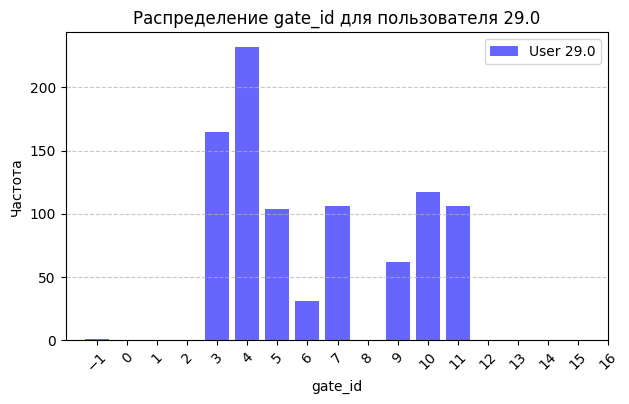

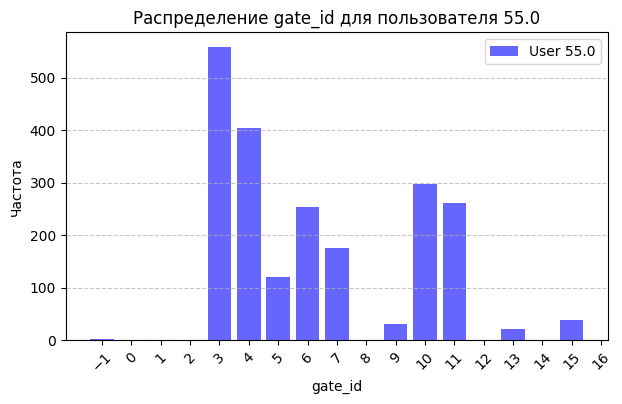

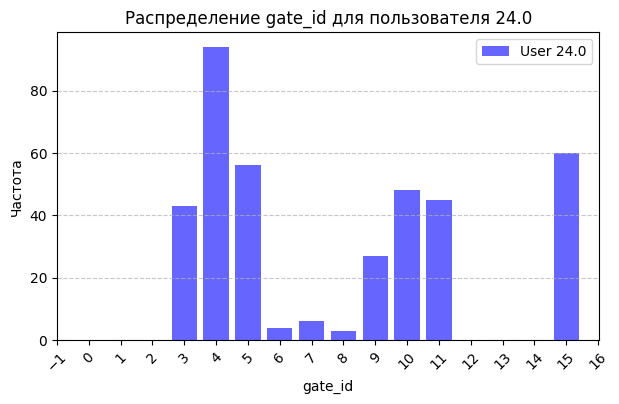

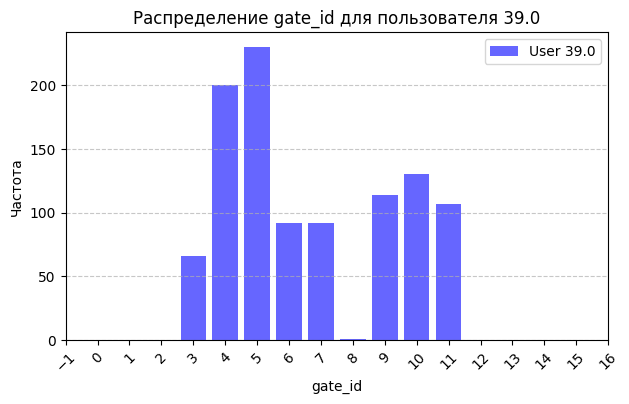

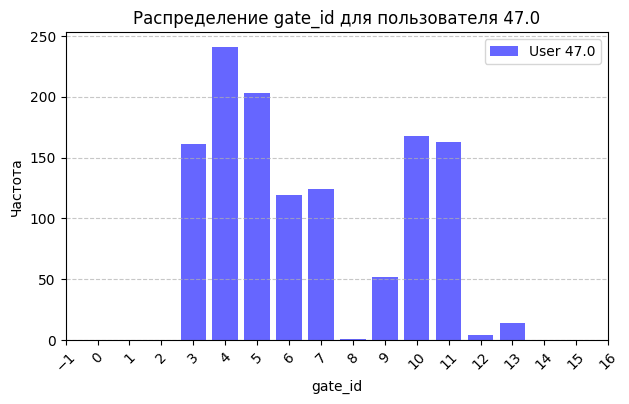

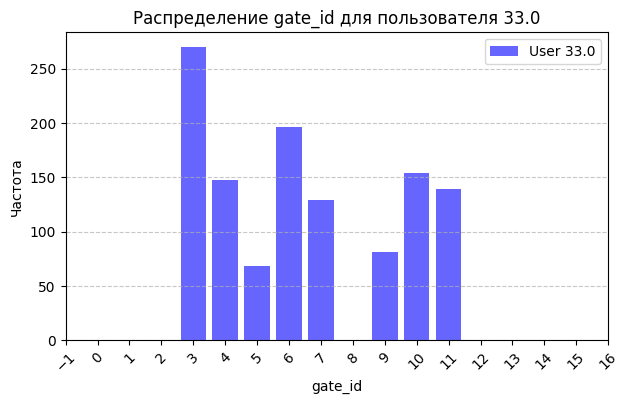

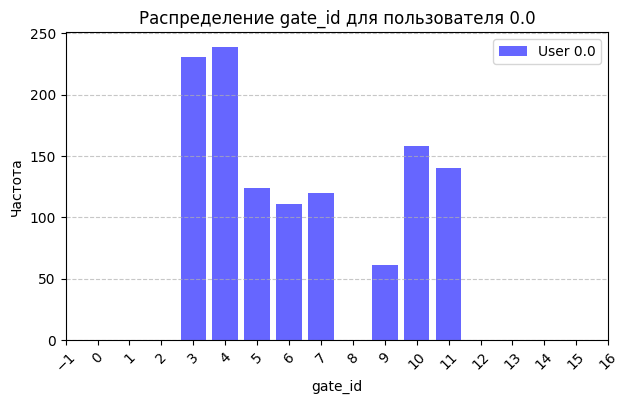

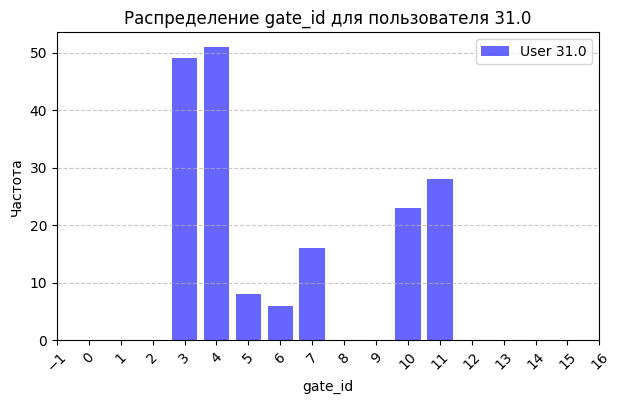

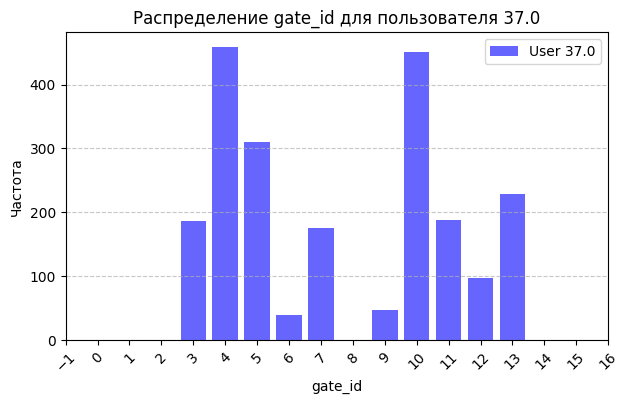

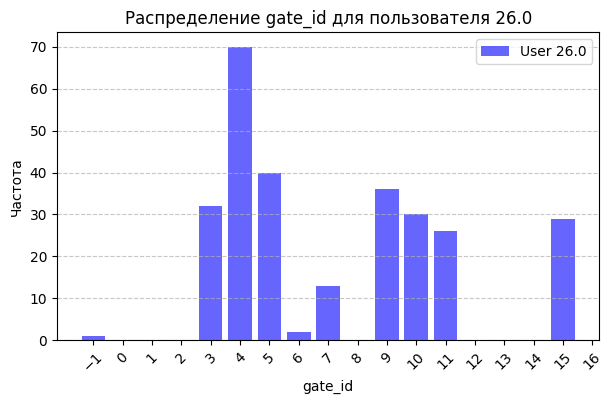

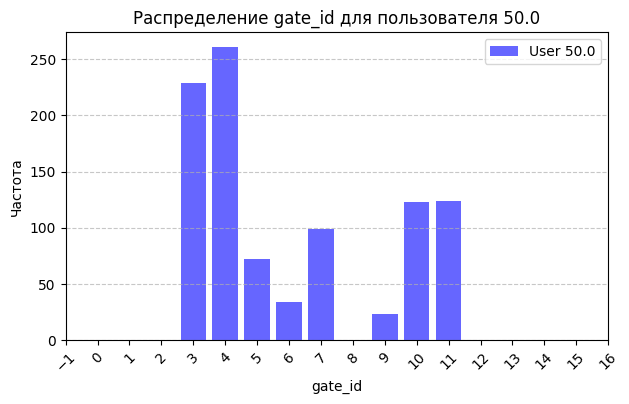

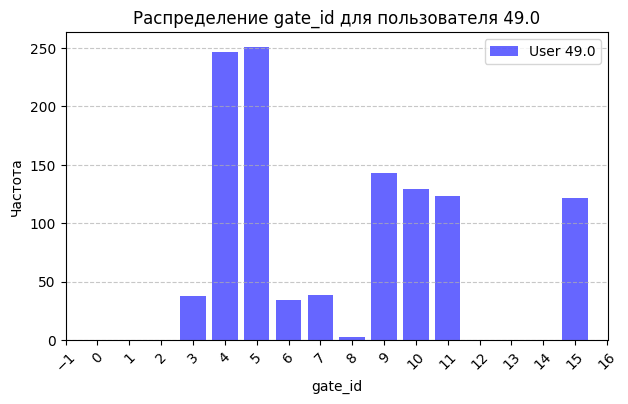

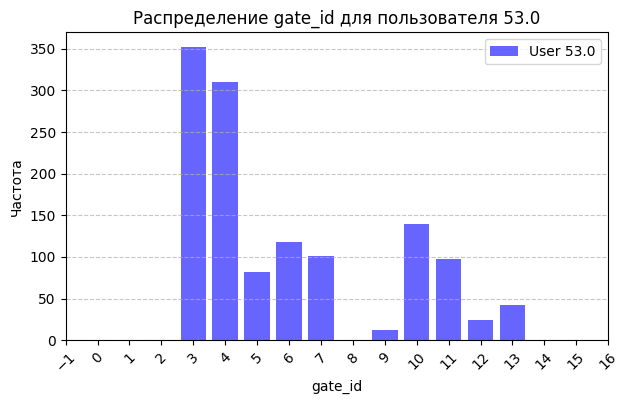

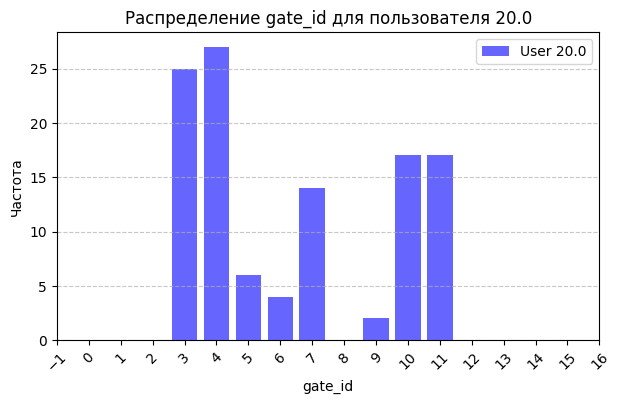

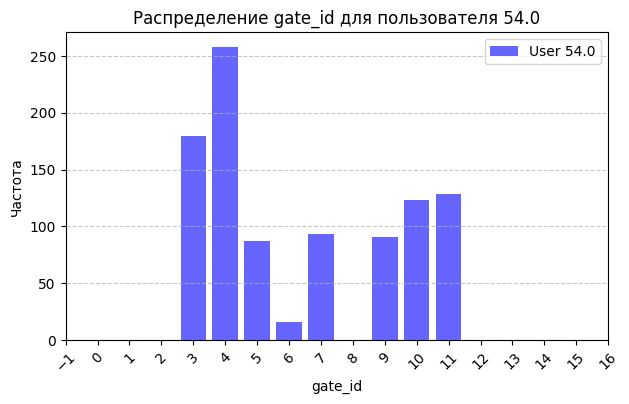

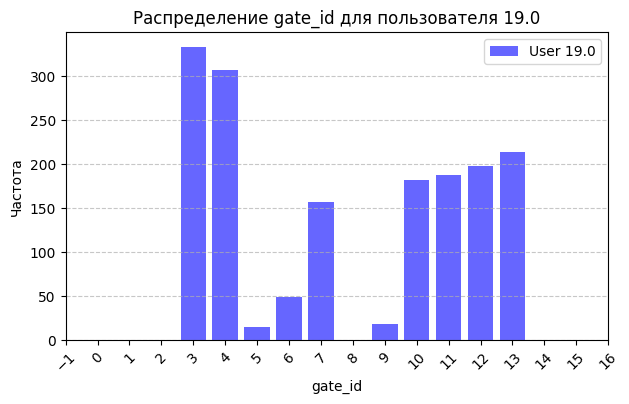

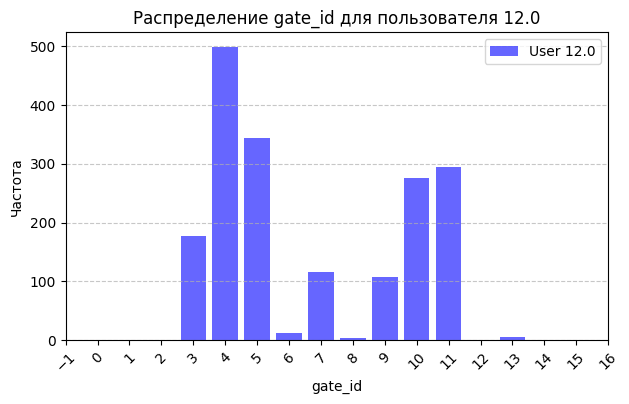

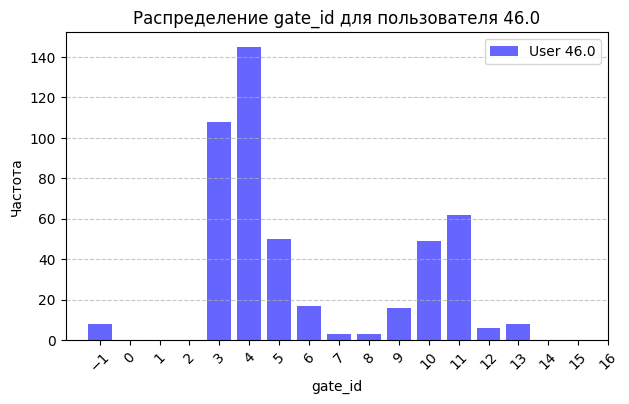

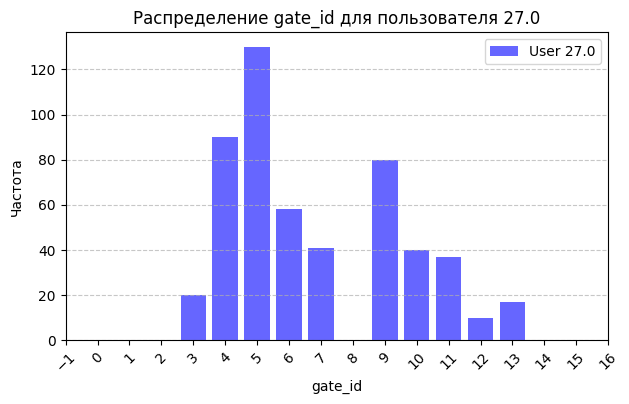

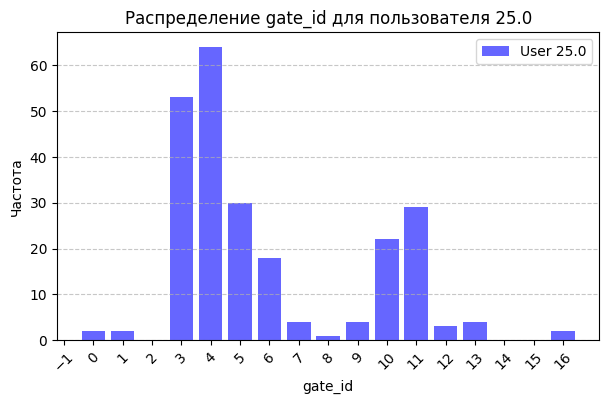

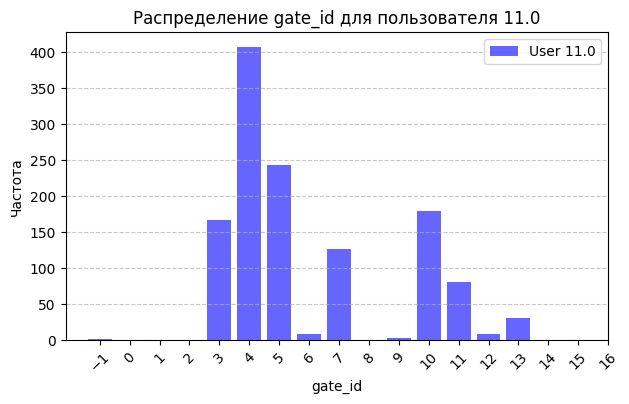

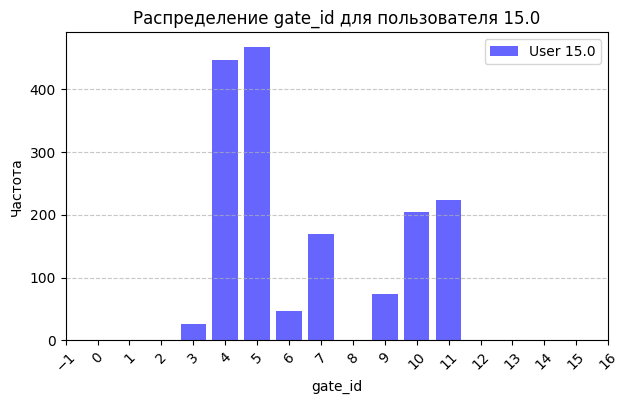

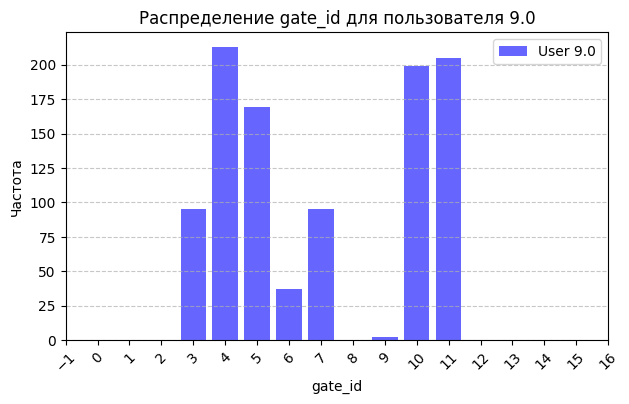

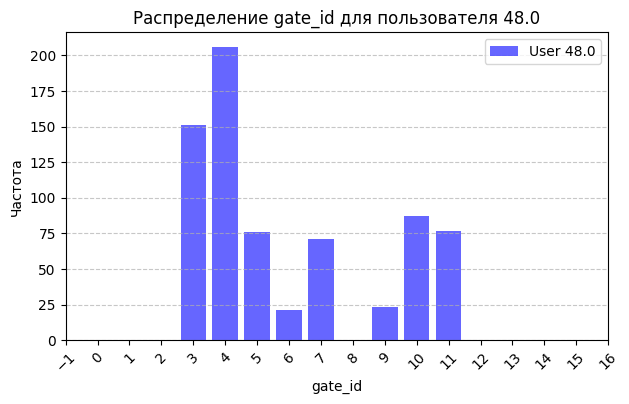

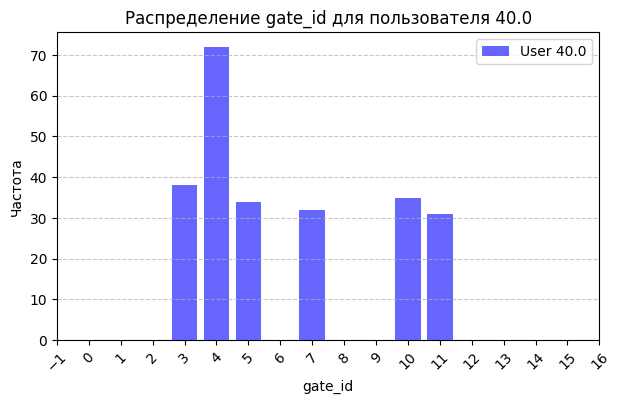

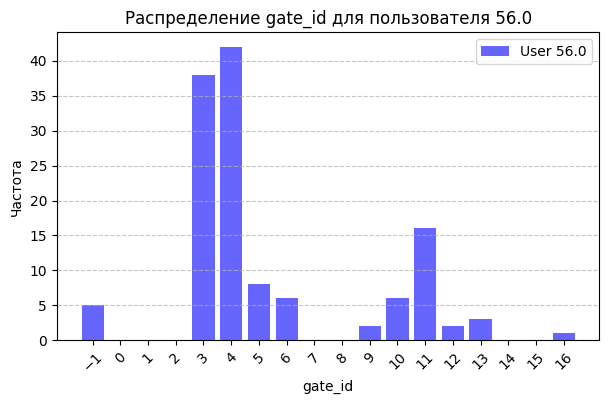

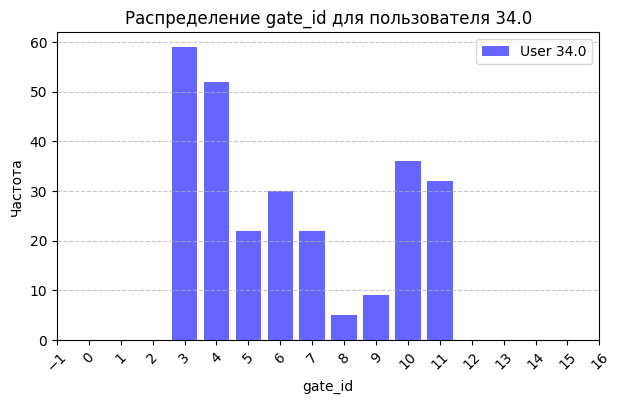

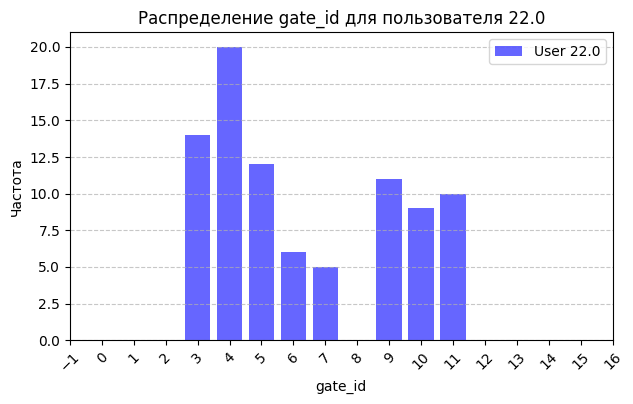

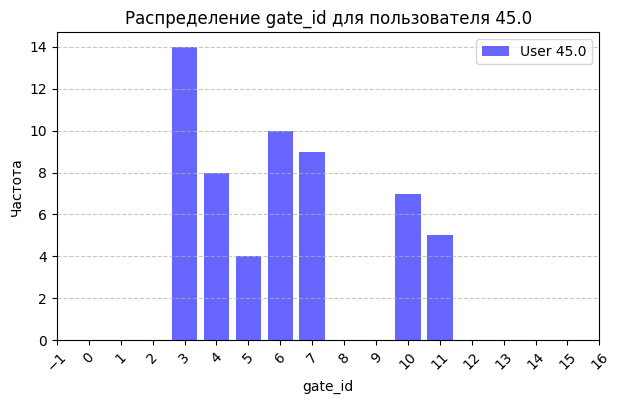

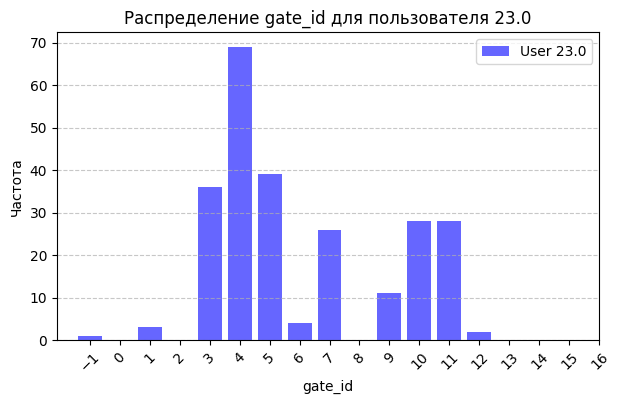

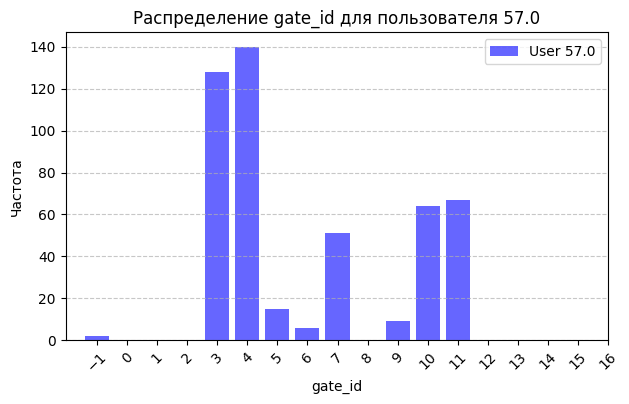

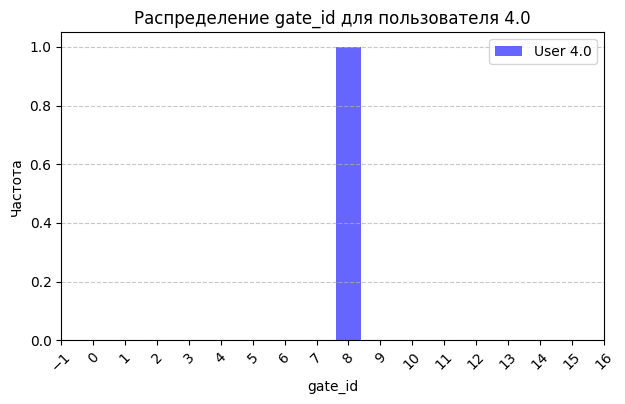

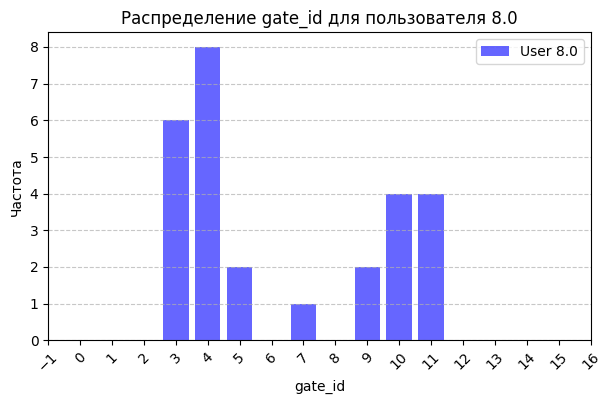

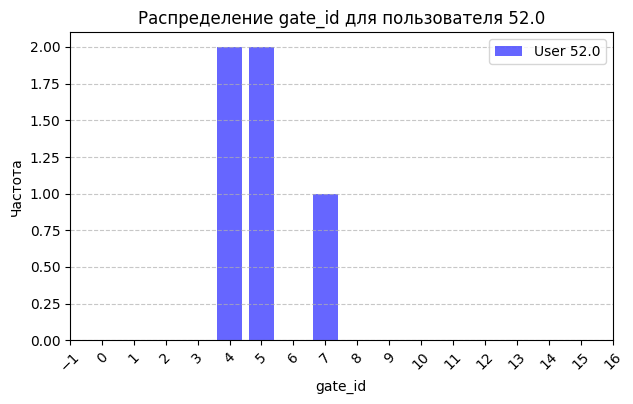

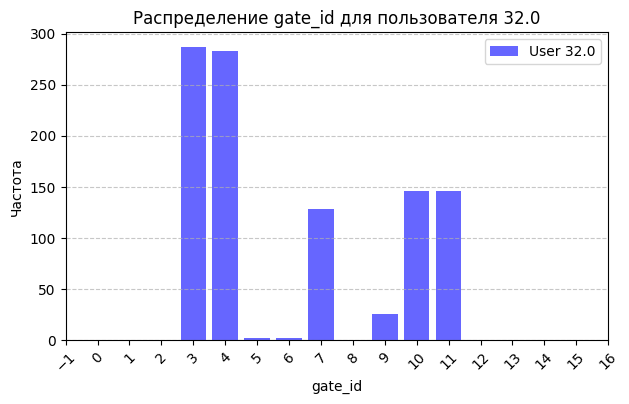

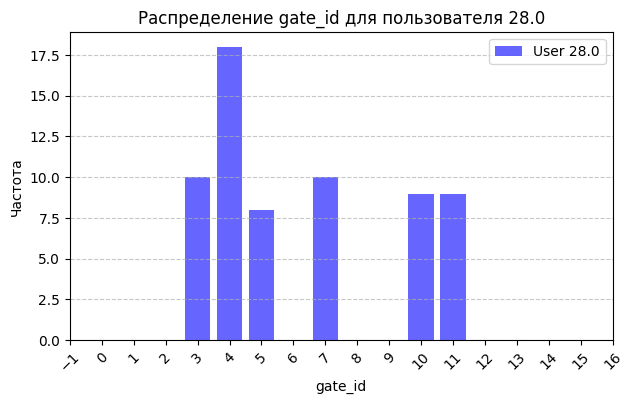

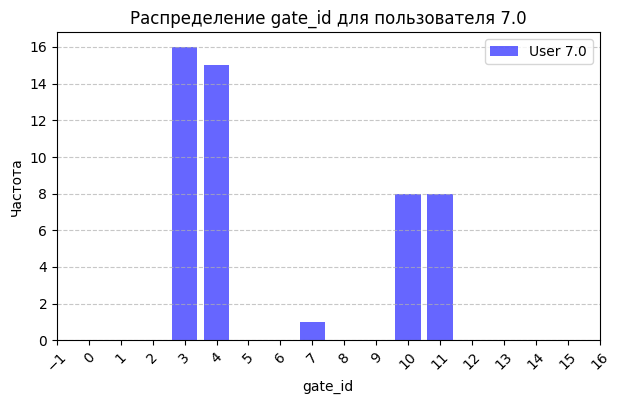

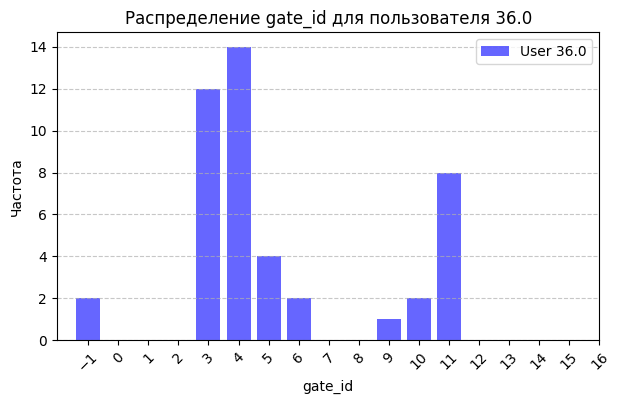

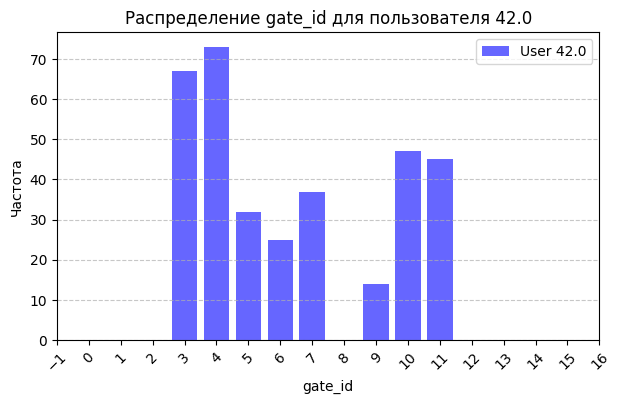

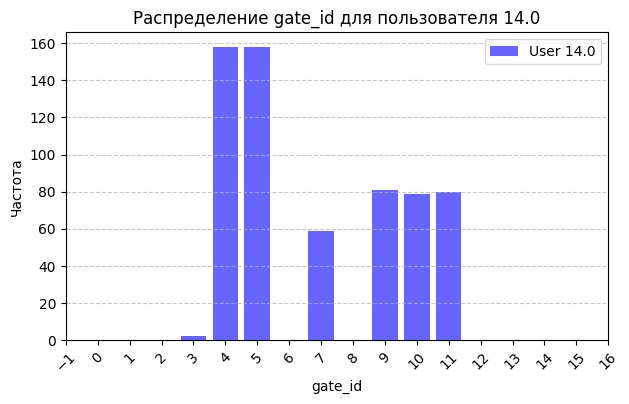

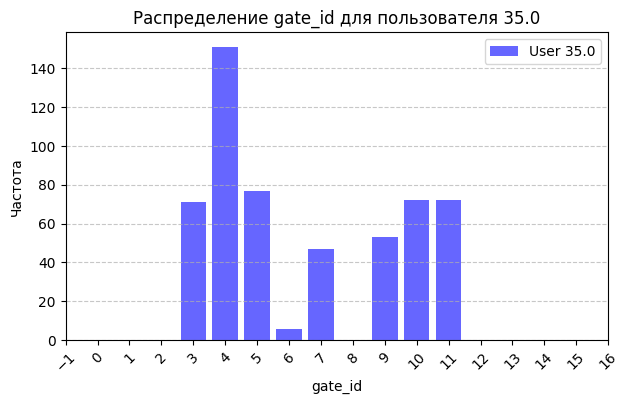

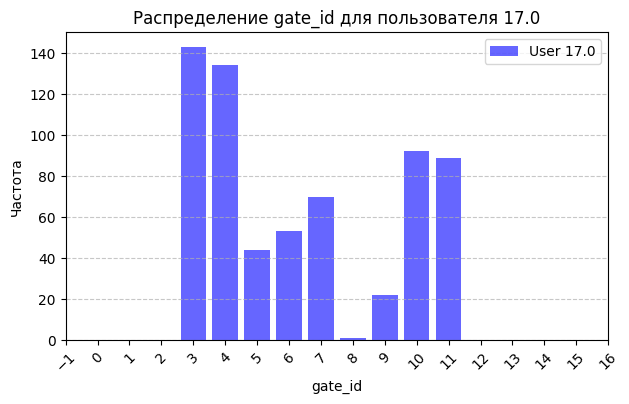

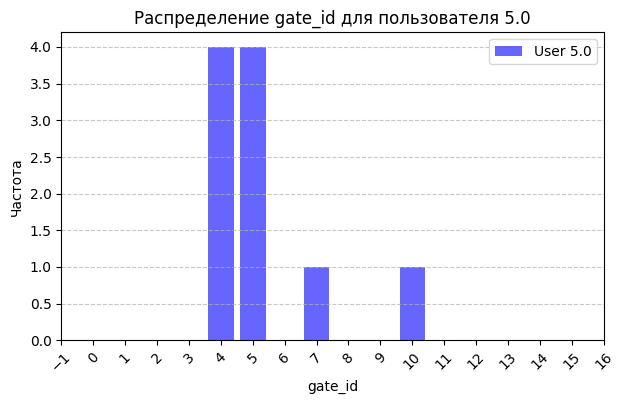

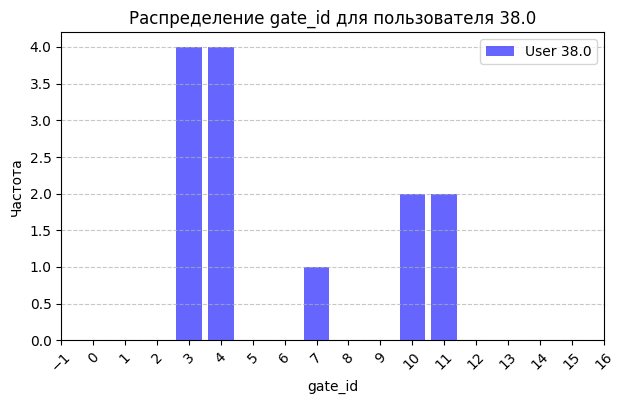

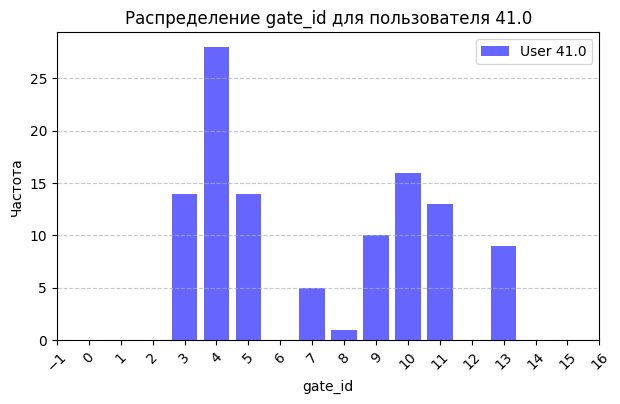

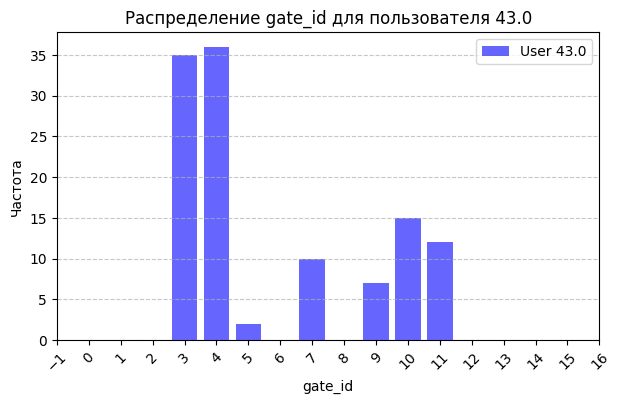

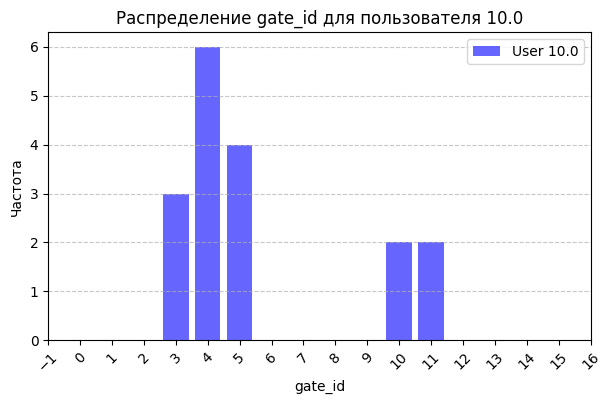

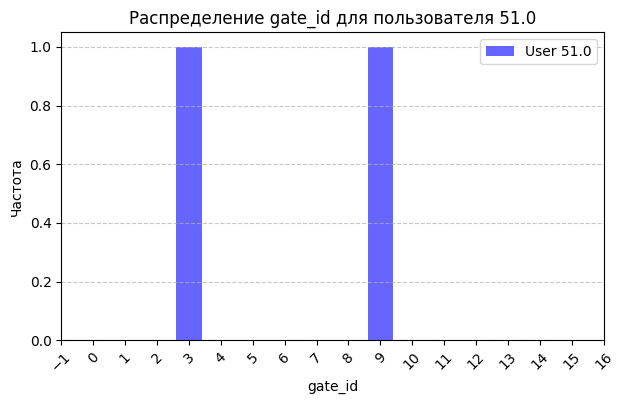

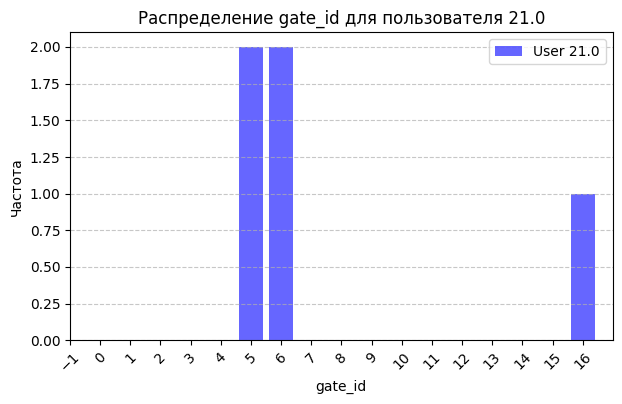

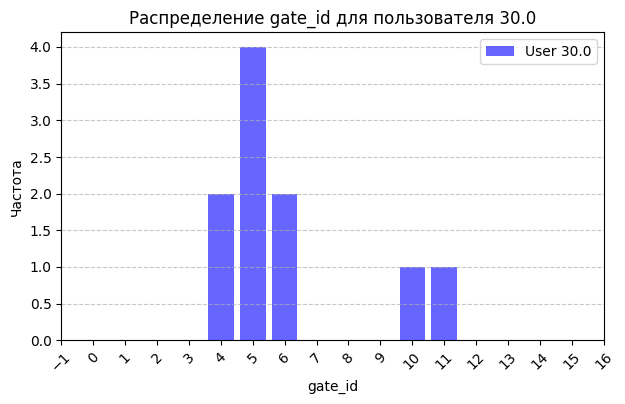

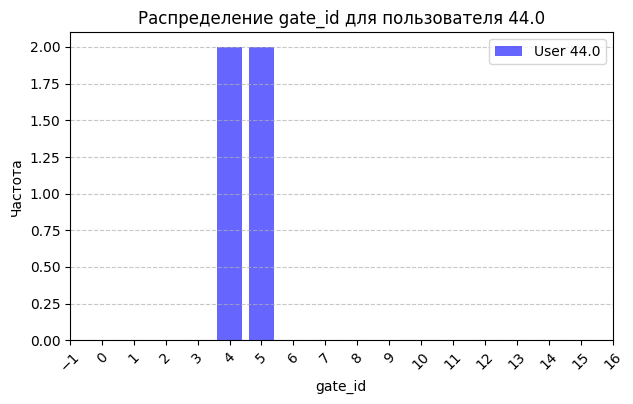

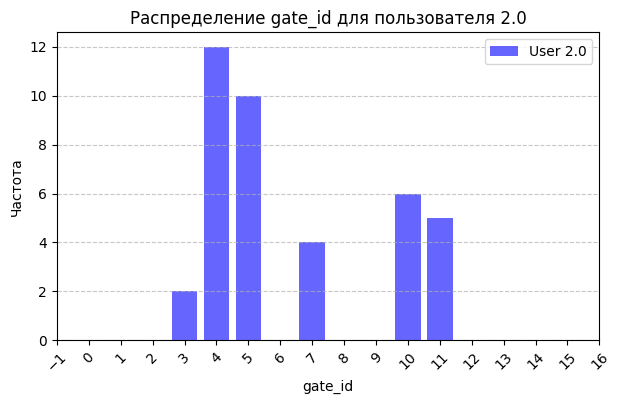

In [ ]:
for user in all_data['user_id'].unique():
    # Фильтруем данные по конкретному пользователю
    user_data = train[train['user_id'] == user]

    if user_data.empty:  # Если данных нет, пропускаем пользователя
        continue

    # Считаем частоту встречаемости gate_id
    counts_user = user_data['gate_id'].value_counts().sort_index()

    plt.figure(figsize=(7, 4))

    # Строим столбчатую диаграмму
    plt.bar(counts_user.index, counts_user.values, color='blue', alpha=0.6, label=f'User {user}')

    # Устанавливаем метки оси X
    xticks = np.arange(counts_all.index.min(), counts_all.index.max() + 1)
    plt.xticks(xticks, rotation=45)

    # Добавляем подписи и легенду
    plt.xlabel('gate_id')
    plt.ylabel('Частота')
    plt.title(f'Распределение gate_id для пользователя {user}')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

Некоторые ворота посещают часто, некоторые практически не посещаются

In [ ]:
train_gate_list = sorted(list(train['gate_id'].unique()))
test_gate_list = sorted(list(test['gate_id'].unique()))
only_test = [gate for gate in test_gate_list if gate not in train_gate_list]

In [ ]:
only_test

[2]

In [ ]:
test[test['gate_id']==2]

ts  gate_id  lost_id
39911 2023-01-13 16:49:52        2       33
39912 2023-01-13 16:49:54        2       33
39928 2023-01-13 18:21:16        2       33
39929 2023-01-13 18:21:19        2       33

## Выделение признаков

Протестируем работу модели CatBoostClassifier. Поставленную задачу стоит отнести к задаче классификации, а не регрессии

### Переменные для каждого турникета

CatBoost внутренне обрабатывает категориальные переменные, так что one-hot-encoding лучше не использовать, на практике это показывает лучший результат

In [ ]:
# all_gates = sorted(list(all_data['gate_id'].unique()))
# all_gates

In [ ]:
# # Составим список турникетов вида "gate_номер"

# list_gate_vars = ['gate_'+str(i) for i in all_gates]
# list_gate_vars

In [ ]:
# # Теперь: cделаем бинарные переменные

# new_vals = pd.get_dummies(all_data['gate_id']).values

In [ ]:
# # Припишем новые бинарные переменные "турникет" к полной выборке

# all_data[list_gate_vars] = new_vals

In [ ]:
# all_data

### Новый признак - день недели

Необходимо выделить ценную информацию из столбцы ts, однако нет необходимости применять one-hot-encoding по вышеуказанной причине

In [ ]:
# Список дней недели

#list_dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# Припишем новые бинарные переменные "день недели" к полной выборке

#all_data[list_dow] = pd.get_dummies(all_data['ts'].dt.day_name())[list_dow].values

In [ ]:

all_data['day_name'] = all_data['ts'].dt.day_name()

In [ ]:
all_data

user_id                  ts  gate_id  lost_id day_name
0         18.0 2022-07-29 09:08:54        7      NaN   Friday
1         18.0 2022-07-29 09:09:54        9      NaN   Friday
3         18.0 2022-07-29 09:10:06        5      NaN   Friday
4         18.0 2022-07-29 09:10:08        5      NaN   Friday
5         18.0 2022-07-29 09:10:34       10      NaN   Friday
...        ...                 ...      ...      ...      ...
44637      NaN 2023-02-24 17:08:57       10     15.0   Friday
44638      NaN 2023-02-24 19:43:36       11     15.0   Friday
44639      NaN 2023-02-24 19:44:00        4     15.0   Friday
44640      NaN 2023-02-24 19:44:01        4     15.0   Friday
44641      NaN 2023-02-24 19:44:09        9     15.0   Friday

[41792 rows x 5 columns]

In [ ]:
all_data['ts'].dt.day_name().value_counts()

ts
Friday       8894
Thursday     8371
Wednesday    8066
Monday       7809
Tuesday      7642
Saturday      687
Sunday        323
Name: count, dtype: int64

### Новый признак - выходной или праздник

In [ ]:
holidays = [
    "2022-07-30", "2022-07-31",  # Суббота и воскресенье
    "2022-08-06", "2022-08-07",
    "2022-08-13", "2022-08-14",
    "2022-08-20", "2022-08-21",
    "2022-08-27", "2022-08-28",
    "2022-09-03", "2022-09-04",
    "2022-09-10", "2022-09-11",
    "2022-09-17", "2022-09-18",
    "2022-09-24", "2022-09-25",
    "2022-10-01", "2022-10-02",
    "2022-10-08", "2022-10-09",
    "2022-10-15", "2022-10-16",
    "2022-10-22", "2022-10-23",
    "2022-10-29", "2022-10-30",
    "2022-11-04",  # День народного единства (официальный праздник)
    "2022-11-05", "2022-11-06",
    "2022-11-12", "2022-11-13",
    "2022-11-19", "2022-11-20",
    "2022-11-26", "2022-11-27",
    "2022-12-03", "2022-12-04",
    "2022-12-10", "2022-12-11",
    "2022-12-17", "2022-12-18",
    "2022-12-24", "2022-12-25",
    "2022-12-31",  # Новый год (выходной день)
    "2023-01-01", "2023-01-02", "2023-01-03", "2023-01-04",
    "2023-01-05", "2023-01-06", "2023-01-07", "2023-01-08",  # Новогодние праздники и Рождество
    "2023-01-14", "2023-01-15",
    "2023-01-21", "2023-01-22",
    "2023-01-28", "2023-01-29",
    "2023-02-04", "2023-02-05",
    "2023-02-11", "2023-02-12",
    "2023-02-18", "2023-02-19",
    "2023-02-23",  # День защитника Отечества (официальный праздник)
    "2023-02-25", "2023-02-26"
]


In [ ]:
all_data['holiday'] = all_data['ts'].dt.strftime('%Y-%m-%d').isin(holidays)

In [ ]:
all_data

user_id                  ts  gate_id  lost_id day_name  holiday
0         18.0 2022-07-29 09:08:54        7      NaN   Friday    False
1         18.0 2022-07-29 09:09:54        9      NaN   Friday    False
3         18.0 2022-07-29 09:10:06        5      NaN   Friday    False
4         18.0 2022-07-29 09:10:08        5      NaN   Friday    False
5         18.0 2022-07-29 09:10:34       10      NaN   Friday    False
...        ...                 ...      ...      ...      ...      ...
44637      NaN 2023-02-24 17:08:57       10     15.0   Friday    False
44638      NaN 2023-02-24 19:43:36       11     15.0   Friday    False
44639      NaN 2023-02-24 19:44:00        4     15.0   Friday    False
44640      NaN 2023-02-24 19:44:01        4     15.0   Friday    False
44641      NaN 2023-02-24 19:44:09        9     15.0   Friday    False

[41792 rows x 6 columns]

### Новый признак - выходной

### Новый бинарный признак - час дня

In [ ]:
all_data['hour'] = all_data['ts'].dt.hour.values

In [ ]:
all_data

user_id                  ts  gate_id  lost_id day_name  holiday  hour
0         18.0 2022-07-29 09:08:54        7      NaN   Friday    False     9
1         18.0 2022-07-29 09:09:54        9      NaN   Friday    False     9
3         18.0 2022-07-29 09:10:06        5      NaN   Friday    False     9
4         18.0 2022-07-29 09:10:08        5      NaN   Friday    False     9
5         18.0 2022-07-29 09:10:34       10      NaN   Friday    False     9
...        ...                 ...      ...      ...      ...      ...   ...
44637      NaN 2023-02-24 17:08:57       10     15.0   Friday    False    17
44638      NaN 2023-02-24 19:43:36       11     15.0   Friday    False    19
44639      NaN 2023-02-24 19:44:00        4     15.0   Friday    False    19
44640      NaN 2023-02-24 19:44:01        4     15.0   Friday    False    19
44641      NaN 2023-02-24 19:44:09        9     15.0   Friday    False    19

[41792 rows x 7 columns]

In [ ]:
# # Список переменных вида "hour_час в полной выборке"

# list_hours = ['hour_'+str(i) for i in sorted(list(all_data['ts'].dt.hour.unique()))]

In [ ]:
# # Добавим бинарные переменные для месяца

# all_data[list_hours] = pd.get_dummies(all_data['ts'].dt.hour.values).values

### Новый признак - минута

In [ ]:
all_data['min'] = all_data['ts'].dt.minute.values

### Новый признак - день

In [ ]:
all_data['day'] = all_data['ts'].dt.day.values

### Новый признак - месяц

In [ ]:
all_data['month'] = all_data['ts'].dt.month.values

### Новый признак - день недели

In [ ]:
all_data['dayofweek'] = all_data['ts'].dt.dayofweek.values

### Новый признак - номер недели в месяце

In [ ]:
all_data['week_of_month'] = all_data['ts'].dt.day.apply(lambda d: (d - 1) // 7 + 1)

In [ ]:
all_data

user_id                  ts  gate_id  lost_id day_name  holiday  hour  \
0         18.0 2022-07-29 09:08:54        7      NaN   Friday    False     9   
1         18.0 2022-07-29 09:09:54        9      NaN   Friday    False     9   
3         18.0 2022-07-29 09:10:06        5      NaN   Friday    False     9   
4         18.0 2022-07-29 09:10:08        5      NaN   Friday    False     9   
5         18.0 2022-07-29 09:10:34       10      NaN   Friday    False     9   
...        ...                 ...      ...      ...      ...      ...   ...   
44637      NaN 2023-02-24 17:08:57       10     15.0   Friday    False    17   
44638      NaN 2023-02-24 19:43:36       11     15.0   Friday    False    19   
44639      NaN 2023-02-24 19:44:00        4     15.0   Friday    False    19   
44640      NaN 2023-02-24 19:44:01        4     15.0   Friday    False    19   
44641      NaN 2023-02-24 19:44:09        9     15.0   Friday    False    19   

       min  day  month  dayofweek  week_of_month  
0        8   29      7          4              5  
1        9   29      7          4              5  
3       10   29      7          4              5  
4       10   29      7          4              5  
5       10   29      7          4              5  
...    ...  ...    ...        ...            ...  
44637    8   24      2          4              4  
44638   43   24      2          4              4  
44639   44   24      2          4              4  
44640   44   24      2          4              4  
44641   44   24      2          4              4  

[41792 rows x 12 columns]

### Новый признак - четный или нечетный день

In [ ]:
all_data['is_even_day'] = (all_data['ts'].dt.day % 2 == 0).astype(int)

### Новый признак - время первого появления в течение дня

In [ ]:
# Сортируем данные по пользователю или lost_id и времени
all_data_sorted = all_data.sort_values(by=['user_id', 'ts'])

# Группируем по user_id и дню, чтобы выбрать первую запись для каждого дня
first_entries = all_data_sorted.groupby(['user_id', 'day']).first().reset_index()

# Группируем по lost_id и дню, чтобы выбрать первую запись для каждого дня
first_entries2 = all_data_sorted.groupby(['lost_id', 'day']).first().reset_index()

# Создаем серию с временем первого появления для каждого user_id
user_first_entries = first_entries[['user_id', 'day', 'hour']].set_index(['user_id', 'day'])['hour']

# Создаем серию с временем первого появления для каждого lost_id
lost_first_entries = first_entries2[['lost_id', 'day', 'hour']].set_index(['lost_id', 'day'])['hour']

# Функция для добавления времени первого появления к записи
def add_first_entry_time(row):
    # Если user_id существует, добавляем время первого появления
    if pd.notnull(row['user_id']):
        return user_first_entries.get((row['user_id'], row['day']), None)
    # Если user_id нет, ищем по lost_id
    elif pd.notnull(row['lost_id']):
        return lost_first_entries.get((row['lost_id'], row['day']), None)
    return None

# Добавляем новый признак в основной DataFrame
all_data['first_entry_hour'] = all_data.apply(add_first_entry_time, axis=1)



In [ ]:

all_data[all_data['user_id'] == 1]['first_entry_hour'].value_counts()


first_entry_hour
9    1084
8      87
Name: count, dtype: int64

### Новый признак - время последнего появления в течение дня

In [ ]:
# Группируем по user_id и дню, чтобы выбрать последнюю запись для каждого дня
last_entries = all_data_sorted.groupby(['user_id', 'day']).last().reset_index()

# Группируем по lost_id и дню, чтобы выбрать последнюю запись для каждого дня
last_entries2 = all_data_sorted.groupby(['lost_id', 'day']).last().reset_index()

# Создаем серию с временем последнего появления для каждого user_id
user_last_entries = last_entries[['user_id', 'day', 'hour']].set_index(['user_id', 'day'])['hour']

# Создаем серию с временем последнего появления для каждого lost_id
lost_last_entries = last_entries2[['lost_id', 'day', 'hour']].set_index(['lost_id', 'day'])['hour']

# Функция для добавления времени последнего появления к записи
def add_last_entry_time(row):
    # Если user_id существует, добавляем время последнего появления
    if pd.notnull(row['user_id']):
        return user_last_entries.get((row['user_id'], row['day']), None)
    # Если user_id нет, ищем по lost_id
    elif pd.notnull(row['lost_id']):
        return lost_last_entries.get((row['lost_id'], row['day']), None)
    return None

# Добавляем новый признак в основной DataFrame
all_data['last_entry_hour'] = all_data.apply(add_last_entry_time, axis=1)



In [ ]:
all_data[all_data['user_id'] == 14]['last_entry_hour'].value_counts()

last_entry_hour
19    483
18    116
20     18
Name: count, dtype: int64

### Новый признак - время, проведенное в здании в день

In [ ]:
all_data['hours_in_building'] = all_data['last_entry_hour'] - all_data['first_entry_hour']

### Новый признак - тип времени

In [ ]:
def get_day_type(hour):
    if 0 <= hour < 6:
        return 'night'  # Ночь
    elif 6 <= hour < 12:
        return 'morning'  # Утро
    elif 12 <= hour < 14:
        return 'lunch'  # Обед
    elif 14 <= hour < 18:
        return 'day'  # День
    else:
        return 'evening'  # Вечер

all_data['day_type'] = all_data['hour'].apply(get_day_type)



### Новый признак - последний ли это день в месяце

In [ ]:
all_data['is_last_day_of_month'] = all_data['ts'].dt.is_month_end

### Первый день в месяце


In [ ]:
all_data['is_first_day_of_month'] = (all_data['ts'].dt.day == 1).astype(int)

### Новый признак - id прошлого пройденного турникета

In [ ]:
# # Добавляем предыдущий gate_id по user_id
# all_data_sorted['prev_gate_id'] = all_data_sorted.groupby('user_id')['gate_id'].shift(1)

# # Заполняем prev_gate_id для записей, у которых user_id отсутствует, используя lost_id
# all_data_sorted['prev_gate_id'] = all_data_sorted.groupby('lost_id')['prev_gate_id'].fillna(
#     all_data_sorted.groupby('lost_id')['gate_id'].shift(1)
# )

# # Обновляем all_data новым признаком из all_data_sorted
# all_data['prev_gate_id'] = all_data_sorted['prev_gate_id']

### Новый признак - количество посещений в день/неделю/месяц

In [ ]:
# # Считаем количество посещений за день
# daily_visits = all_data_sorted.groupby(['user_id', 'day'])['gate_id'].count().rename('daily_visits')
# daily_visits_lost = all_data_sorted.groupby(['lost_id', 'day'])['gate_id'].count().rename('daily_visits')

# # Считаем количество посещений за неделю
# weekly_visits = all_data_sorted.groupby(['user_id', 'week_of_month'])['gate_id'].count().rename('weekly_visits')
# weekly_visits_lost = all_data_sorted.groupby(['lost_id', 'week_of_month'])['gate_id'].count().rename('weekly_visits')

# # Считаем количество посещений за месяц
# monthly_visits = all_data_sorted.groupby(['user_id', 'month'])['gate_id'].count().rename('monthly_visits')
# monthly_visits_lost = all_data_sorted.groupby(['lost_id', 'month'])['gate_id'].count().rename('monthly_visits')

# # Функция для добавления количества посещений
# def add_visit_counts(row):
#     if pd.notnull(row['user_id']):
#         return (
#             daily_visits.get((row['user_id'], row['day']), None),
#             weekly_visits.get((row['user_id'], row['week_of_month']), None),
#             monthly_visits.get((row['user_id'], row['month']), None)
#         )
#     elif pd.notnull(row['lost_id']):
#         return (
#             daily_visits_lost.get((row['lost_id'], row['day']), None),
#             weekly_visits_lost.get((row['lost_id'], row['week_of_month']), None),
#             monthly_visits_lost.get((row['lost_id'], row['month']), None)
#         )
#     return None, None, None

# # Добавляем новые признаки в основной DataFrame
# all_data[['daily_visits', 'weekly_visits', 'monthly_visits']] = all_data.apply(
#     lambda row: add_visit_counts(row), axis=1, result_type='expand'
# )



### Новый признак - наиболее часто посещаемый турникет

In [ ]:
# # Определяем наиболее частый gate_id для каждого user_id
# most_frequent_gate_user = all_data_sorted.groupby('user_id')['gate_id'].agg(lambda x: x.mode()[0]).rename('most_frequent_gate_id')

# # Определяем наиболее частый gate_id для каждого lost_id
# most_frequent_gate_lost = all_data_sorted.groupby('lost_id')['gate_id'].agg(lambda x: x.mode()[0]).rename('most_frequent_gate_id')

# # Функция для добавления наиболее часто посещаемого gate_id
# def add_most_frequent_gate(row):
#     if pd.notnull(row['user_id']):
#         return most_frequent_gate_user.get(row['user_id'], None)
#     elif pd.notnull(row['lost_id']):
#         return most_frequent_gate_lost.get(row['lost_id'], None)
#     return None

# # Добавляем новый признак в основной DataFrame
# all_data['most_frequent_gate_id'] = all_data.apply(add_most_frequent_gate, axis=1)




### Новый признак - последний пользователь, вышедший из здания за день

In [ ]:
# # Группируем по дню, находим user_id (или lost_id), который ушел последним
# last_to_leave = all_data_sorted.loc[all_data_sorted.groupby('day')['ts'].idxmax(), ['day', 'user_id', 'lost_id']]
# last_to_leave['is_last_to_leave'] = True  # Отмечаем этих пользователей

# # Объединяем с all_data, добавляя признак is_last_to_leave
# all_data = all_data.merge(last_to_leave, on=['day', 'user_id', 'lost_id'], how='left')

# # Заменяем NaN на False (остальные пользователи не последние)
# all_data['is_last_to_leave'] = all_data['is_last_to_leave'].fillna(False)



### Новый признак Число уникальных посещенных дней, месяцев

In [ ]:
# unique_days = all_data.groupby('user_id')['day'].nunique().rename('unique_days')
# all_data = all_data.merge(unique_days, on='user_id', how='left')


# unique_months = all_data.groupby('user_id')['month'].nunique().rename('unique_months')
# all_data = all_data.merge(unique_months, on='user_id', how='left')

### Среднее время первого/последнего входа и разница между ними

In [ ]:

# first_entry = all_data.sort_values('ts').groupby(['user_id', 'day']).first().reset_index()
# first_entry['first_hour'] = pd.to_datetime(first_entry['ts']).dt.hour
# first_entry_hour_mean = first_entry.groupby('user_id')['first_hour'].mean().rename('first_entry_hour_mean')
# all_data = all_data.merge(first_entry_hour_mean, on='user_id', how='left')


# last_entry = all_data.sort_values('ts').groupby(['user_id', 'day']).last().reset_index()
# last_entry['last_hour'] = pd.to_datetime(last_entry['ts']).dt.hour
# last_entry_hour_mean = last_entry.groupby('user_id')['last_hour'].mean().rename('last_entry_hour_mean')
# all_data = all_data.merge(last_entry_hour_mean, on='user_id', how='left')


# daily_entries = all_data.sort_values('ts').groupby(['user_id', 'day'])['ts'].agg(['first', 'last']).reset_index()
# daily_entries['daily_duration'] = (pd.to_datetime(daily_entries['last']) - pd.to_datetime(daily_entries['first'])).dt.total_seconds() / 3600
# avg_daily_duration = daily_entries.groupby('user_id')['daily_duration'].mean().rename('avg_daily_duration')
# all_data = all_data.merge(avg_daily_duration, on='user_id', how='left')

### Максимальный и минимальный интервал между визитами

In [ ]:
# all_data_sorted = all_data.sort_values(['user_id', 'day', 'ts'])
# all_data_sorted['prev_ts'] = all_data_sorted.groupby(['user_id', 'day'])['ts'].shift(1)
# all_data_sorted['gap'] = (pd.to_datetime(all_data_sorted['ts']) - pd.to_datetime(all_data_sorted['prev_ts'])).dt.total_seconds() / 60
# max_gap = all_data_sorted.groupby(['user_id', 'day'])['gap'].max().reset_index()
# max_gap_mean = max_gap.groupby('user_id')['gap'].mean().rename('max_gap_between_visits')
# all_data = all_data.merge(max_gap_mean, on='user_id', how='left')

# min_gap = all_data_sorted.groupby(['user_id', 'day'])['gap'].min().reset_index()
# min_gap_mean = min_gap.groupby('user_id')['gap'].mean().rename('min_gap_between_visits')
# all_data = all_data.merge(min_gap_mean, on='user_id', how='left')

### Среднеквадратичное отклонение интервалов между визитами

In [ ]:
# std_gap = all_data_sorted.groupby(['user_id', 'day'])['gap'].std().reset_index()
# std_gap_mean = std_gap.groupby('user_id')['gap'].mean().rename('std_gap_between_visits')
# all_data = all_data.merge(std_gap_mean, on='user_id', how='left')

### Число визитов утров, в обед, днем, вечером и ночью

In [ ]:
# # число визитов с 6:00 до 11:59
# all_data['morning_flag'] = all_data['ts'].dt.hour.between(6, 11)
# morning_visits = all_data.groupby('user_id')['morning_flag'].sum().rename('morning_visits_count')
# all_data = all_data.merge(morning_visits, on='user_id', how='left')

# #  число визитов с 12:00 до 13:59
# all_data['lunch_flag'] = all_data['ts'].dt.hour.between(12, 13)
# lunch_visits = all_data.groupby('user_id')['lunch_flag'].sum().rename('lunch_visits_count')
# all_data = all_data.merge(lunch_visits, on='user_id', how='left')

# #  число визитов с 14:00 до 17:59
# all_data['afternoon_flag'] = all_data['ts'].dt.hour.between(14, 17)
# afternoon_visits = all_data.groupby('user_id')['afternoon_flag'].sum().rename('afternoon_visits_count')
# all_data = all_data.merge(afternoon_visits, on='user_id', how='left')

# #  число визитов с 18:00 до 23:59
# all_data['evening_flag'] = all_data['ts'].dt.hour.between(18, 23)
# evening_visits = all_data.groupby('user_id')['evening_flag'].sum().rename('evening_visits_count')
# all_data = all_data.merge(evening_visits, on='user_id', how='left')

# #  число визитов с 00:00 до 05:59
# all_data['night_flag'] = all_data['ts'].dt.hour.between(0, 5)
# night_visits = all_data.groupby('user_id')['night_flag'].sum().rename('night_visits_count')
# all_data = all_data.merge(night_visits, on='user_id', how='left')

### Количество посещений по дням недели/выходным/праздникам

In [ ]:


# #  доля посещений в будние (Пн–Пт)
# all_data['is_weekday'] = (all_data['dayofweek'] < 5).astype(int)
# weekday_visits = all_data.groupby('user_id')['is_weekday'].sum()
# weekday_visit_ratio = (weekday_visits / total_visits).rename('weekday_visit_ratio')
# all_data = all_data.merge(weekday_visit_ratio.reset_index(), on='user_id', how='left')

# # – доля посещений в выходные (Сб-Вс)
# all_data['is_weekend'] = (all_data['dayofweek'] >= 5).astype(int)
# weekend_visits = all_data.groupby('user_id')['is_weekend'].sum()
# weekend_visit_ratio = (weekend_visits / total_visits).rename('weekend_visit_ratio')
# all_data = all_data.merge(weekend_visit_ratio.reset_index(), on='user_id', how='left')

# #  доля посещений в праздничные дни
# holiday_visits = all_data.groupby('user_id')['holiday'].sum()
# holiday_visit_ratio = (holiday_visits / total_visits).rename('holiday_visit_ratio')
# all_data = all_data.merge(holiday_visit_ratio.reset_index(), on='user_id', how='left')

### Число уникальный турникетов

In [ ]:
# gate_diversity = all_data.groupby('user_id')['gate_id'].nunique().rename('gate_diversity')
# all_data = all_data.merge(gate_diversity.reset_index(), on='user_id', how='left')

### Средний пик посещений за день, месяц

In [ ]:
# # средний пик посещений по часам за день
# daily_peak_hour = all_data.groupby(['user_id', 'day'])['hour'] \
#     .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
# daily_peak_hour_mean = daily_peak_hour.groupby('user_id')['hour'].mean().rename('daily_visit_peak_hour')
# all_data = all_data.merge(daily_peak_hour_mean.reset_index(), on='user_id', how='left')


# #  аналогично по месяцам
# monthly_peak_hour = all_data.groupby(['user_id', 'month'])['hour'] \
#     .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()
# monthly_peak_hour_mean = monthly_peak_hour.groupby('user_id')['hour'].mean().rename('monthly_visit_peak_hour')
# all_data = all_data.merge(monthly_peak_hour_mean.reset_index(), on='user_id', how='left')

### Результат

In [ ]:
all_data.columns

Index(['user_id', 'ts', 'gate_id', 'lost_id', 'day_name', 'holiday', 'hour',
       'min', 'day', 'month', 'dayofweek', 'week_of_month', 'is_even_day',
       'first_entry_hour', 'last_entry_hour', 'hours_in_building', 'day_type',
       'is_last_day_of_month', 'is_first_day_of_month'],
      dtype='object')

In [ ]:
all_data

user_id                  ts  gate_id  lost_id day_name  holiday  hour  \
0         18.0 2022-07-29 09:08:54        7      NaN   Friday    False     9   
1         18.0 2022-07-29 09:09:54        9      NaN   Friday    False     9   
3         18.0 2022-07-29 09:10:06        5      NaN   Friday    False     9   
4         18.0 2022-07-29 09:10:08        5      NaN   Friday    False     9   
5         18.0 2022-07-29 09:10:34       10      NaN   Friday    False     9   
...        ...                 ...      ...      ...      ...      ...   ...   
44637      NaN 2023-02-24 17:08:57       10     15.0   Friday    False    17   
44638      NaN 2023-02-24 19:43:36       11     15.0   Friday    False    19   
44639      NaN 2023-02-24 19:44:00        4     15.0   Friday    False    19   
44640      NaN 2023-02-24 19:44:01        4     15.0   Friday    False    19   
44641      NaN 2023-02-24 19:44:09        9     15.0   Friday    False    19   

       min  day  month  dayofweek  week_of_month  is_even_day  \
0        8   29      7          4              5            0   
1        9   29      7          4              5            0   
3       10   29      7          4              5            0   
4       10   29      7          4              5            0   
5       10   29      7          4              5            0   
...    ...  ...    ...        ...            ...          ...   
44637    8   24      2          4              4            1   
44638   43   24      2          4              4            1   
44639   44   24      2          4              4            1   
44640   44   24      2          4              4            1   
44641   44   24      2          4              4            1   

       first_entry_hour  last_entry_hour  hours_in_building day_type  \
0                     9               14                  5  morning   
1                     9               14                  5  morning   
3                     9               14                  5  morning   
4                     9               14                  5  morning   
5                     9               14                  5  morning   
...                 ...              ...                ...      ...   
44637                10               19                  9      day   
44638                10               19                  9  evening   
44639                10               19                  9  evening   
44640                10               19                  9  evening   
44641                10               19                  9  evening   

       is_last_day_of_month  is_first_day_of_month  
0                     False                      0  
1                     False                      0  
3                     False                      0  
4                     False                      0  
5                     False                      0  
...                     ...                    ...  
44637                 False                      0  
44638                 False                      0  
44639                 False                      0  
44640                 False                      0  
44641                 False                      0  

[41792 rows x 19 columns]

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41792 entries, 0 to 44641
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                35172 non-null  float64       
 1   ts                     41792 non-null  datetime64[ns]
 2   gate_id                41792 non-null  int64         
 3   lost_id                6620 non-null   float64       
 4   day_name               41792 non-null  object        
 5   holiday                41792 non-null  bool          
 6   hour                   41792 non-null  int32         
 7   min                    41792 non-null  int32         
 8   day                    41792 non-null  int32         
 9   month                  41792 non-null  int32         
 10  dayofweek              41792 non-null  int32         
 11  week_of_month          41792 non-null  int64         
 12  is_even_day            41792 non-null  int64         
 13  first_

### Анализ диапазона временных меток

In [ ]:
train['ts'].agg(['max' ,'count'])

max      2022-12-31 20:39:31
count                  35172
Name: ts, dtype: object

In [ ]:
test['ts'].agg(['min','max','count'])

min      2023-01-03 08:21:00
max      2023-02-24 19:44:09
count                   6620
Name: ts, dtype: object

## Построение модели

### Разделение полученного набора на обучающую, тестовую и валидационную

При выделении валидационной выборки для задачи классификации необходимо участь тот факт, что в обучающей и валидационной выборке в примерно равном соотношении должны присутствовать представители каждого класса

In [ ]:
# val_index = train['ts'] > '2022-11-30'

In [ ]:
# sum(val_index) / val_index.shape[0]

Предполагается, что в объединённом наборе строки, где lost_id отсутствует (null), относятся к обучающему набору, а те, где lost_id присутствует — к тестовому

In [ ]:
prepared_data = X = all_data.drop(columns=["ts"])

prepared_data['min'] = round(prepared_data['min'], -1) # Округлим минуты до десятков

In [ ]:
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41792 entries, 0 to 44641
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                35172 non-null  float64
 1   gate_id                41792 non-null  int64  
 2   lost_id                6620 non-null   float64
 3   day_name               41792 non-null  object 
 4   holiday                41792 non-null  bool   
 5   hour                   41792 non-null  int32  
 6   min                    41792 non-null  int32  
 7   day                    41792 non-null  int32  
 8   month                  41792 non-null  int32  
 9   dayofweek              41792 non-null  int32  
 10  week_of_month          41792 non-null  int64  
 11  is_even_day            41792 non-null  int64  
 12  first_entry_hour       41792 non-null  int32  
 13  last_entry_hour        41792 non-null  int32  
 14  hours_in_building      41792 non-null  int32  
 15  day_typ

In [ ]:
train_idx = prepared_data['lost_id'].isnull()
# train = prepared_data[train_idx]
# test = prepared_data[~train_idx]

In [ ]:
X_train = prepared_data.loc[train_idx].drop(columns=["user_id", "lost_id"])
y_train = prepared_data.loc[train_idx]["user_id"]

In [ ]:
y_train

0        18.0
1        18.0
3        18.0
4        18.0
5        18.0
         ... 
37512     6.0
37513     6.0
37514     6.0
37515     6.0
37516     6.0
Name: user_id, Length: 35172, dtype: float64

In [ ]:

X_test = prepared_data.loc[~train_idx].drop(columns=["user_id", "lost_id"])
y_test = prepared_data.loc[~train_idx]["lost_id"]


In [ ]:
display(X_train.tail(1), X_test.head(1))

gate_id  day_name  holiday  hour  min  day  month  dayofweek  \
37516        9  Saturday     True    20   40   31     12          5   

       week_of_month  is_even_day  first_entry_hour  last_entry_hour  \
37516              5            0                10               20   

       hours_in_building day_type  is_last_day_of_month  is_first_day_of_month  
37516                 10  evening                  True                      0

gate_id day_name  holiday  hour  min  day  month  dayofweek  \
37518        9  Tuesday     True     8   20    3      1          1   

       week_of_month  is_even_day  first_entry_hour  last_entry_hour  \
37518              1            0                 8               17   

       hours_in_building day_type  is_last_day_of_month  is_first_day_of_month  
37518                  9  morning                 False                      0

In [ ]:
cat_features = list(X_train.columns)
print('Признаки, всего', len(cat_features))
print(list(cat_features))

Признаки, всего 16
['gate_id', 'day_name', 'holiday', 'hour', 'min', 'day', 'month', 'dayofweek', 'week_of_month', 'is_even_day', 'first_entry_hour', 'last_entry_hour', 'hours_in_building', 'day_type', 'is_last_day_of_month', 'is_first_day_of_month']


In [ ]:
cat_features = ['gate_id', 'day_name', 'holiday', 'dayofweek', 'day_type']
for cat in cat_features:
  X_train[cat] = X_train[cat].astype(str)

In [ ]:
# Временное решение: удалим класс, который встречается всего один раз в тестовой выборке - а именно класс user_id 4. Это нужно для пропорционального разделения валидационной и обучающей выборок
y_train_filtered = y_train[y_train.isin(y_train.value_counts()[y_train.value_counts() > 1].index)]
X_train_filtered = X_train.loc[y_train_filtered.index]


In [ ]:
# Выделение валидационной выборки
X_train, X_val, y_train, y_val = train_test_split(X_train_filtered, y_train_filtered, test_size=0.35, stratify=y_train_filtered, random_state=3) # параметр stratify обеспечит соотношение классов в выборках

### Сравнение выборок

In [ ]:
y_train.value_counts()

user_id
37.0    1420
55.0    1408
6.0     1207
12.0    1194
19.0    1080
15.0    1078
18.0     937
53.0     831
11.0     816
47.0     812
0.0      770
33.0     770
1.0      761
49.0     734
39.0     671
32.0     663
9.0      660
54.0     635
50.0     627
29.0     601
3.0      581
48.0     463
17.0     421
14.0     401
35.0     357
27.0     340
57.0     313
46.0     309
24.0     251
42.0     221
26.0     181
34.0     173
23.0     161
40.0     157
25.0     155
31.0     118
56.0      84
43.0      76
20.0      73
41.0      71
22.0      57
28.0      42
45.0      37
7.0       31
36.0      29
2.0       25
8.0       18
10.0      11
38.0       8
30.0       6
5.0        6
52.0       3
44.0       3
21.0       3
51.0       1
Name: count, dtype: int64

In [ ]:
y_val.value_counts()

user_id
37.0    764
55.0    758
6.0     650
12.0    643
19.0    581
15.0    581
18.0    504
53.0    448
11.0    439
47.0    438
0.0     414
33.0    414
1.0     410
49.0    395
39.0    361
32.0    357
9.0     355
54.0    342
50.0    338
29.0    323
3.0     313
48.0    249
17.0    227
14.0    216
35.0    192
27.0    183
57.0    169
46.0    166
24.0    135
42.0    119
26.0     98
34.0     94
23.0     86
40.0     85
25.0     83
31.0     63
56.0     45
43.0     41
20.0     39
41.0     39
22.0     30
28.0     22
45.0     20
7.0      17
36.0     16
2.0      14
8.0       9
10.0      6
38.0      5
30.0      4
5.0       4
21.0      2
52.0      2
51.0      1
44.0      1
Name: count, dtype: int64

### Подготовка данных для обучения модели

In [ ]:
# X = train[~val_index].copy()
# X_val = train[val_index].copy()

# y = X['user_id'].astype(int)
# y_val = X_val['user_id'].astype(int)

In [ ]:
# cols_cat = list(all_data.columns[4:]) # Исключаем первые 4 признака, которые мы обработали

In [ ]:
# X = X[cols_cat].astype(int)
# X_val = X_val[cols_cat].astype(int)

In [ ]:
# X

In [ ]:
# # Нормируем данные. Здесь применяется отдельное масштабирование для обучающей
# # выборки и валидационной, поскольку предполагается, что будущие данные могут
# # иметь другую статистику.

# scaler_X = StandardScaler()
# scaler_X_val = StandardScaler()

# scaler_X.fit(X)
# scaler_X_val.fit(X_val)

# X_scaled = scaler_X.transform(X)
# X_val_scaled = scaler_X_val.transform(X_val)

In [ ]:
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)


### Обучение модели

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22861 entries, 33301 to 921
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   gate_id                22861 non-null  object
 1   day_name               22861 non-null  object
 2   holiday                22861 non-null  object
 3   hour                   22861 non-null  int32 
 4   min                    22861 non-null  int32 
 5   day                    22861 non-null  int32 
 6   month                  22861 non-null  int32 
 7   dayofweek              22861 non-null  object
 8   week_of_month          22861 non-null  int64 
 9   is_even_day            22861 non-null  int64 
 10  first_entry_hour       22861 non-null  int32 
 11  last_entry_hour        22861 non-null  int32 
 12  hours_in_building      22861 non-null  int32 
 13  day_type               22861 non-null  object
 14  is_last_day_of_month   22861 non-null  bool  
 15  is_first_day_of_month 

In [ ]:
# model = CatBoostClassifier(
#     iterations=100,               # Уменьшаем количество деревьев
#     depth=6,                      # Делаем деревья мельче
#     l2_leaf_reg=3,                # Регуляризация (ускоряет обучение)
#     border_count=16,              # Оптимизация категориальных признаков
#     early_stopping_rounds=50,    # Останавливаемся раньше, если модель не улучшается
# )

model = CatBoostClassifier(iterations=100, early_stopping_rounds=50, depth=5)

model.fit(train_data)

Learning rate set to 0.5
0:	learn: 3.2481164	total: 19.4s	remaining: 31m 58s
1:	learn: 2.8676251	total: 35.2s	remaining: 28m 45s
2:	learn: 2.6506490	total: 46.1s	remaining: 24m 50s
3:	learn: 2.5132168	total: 57s	remaining: 22m 47s
4:	learn: 2.4711787	total: 1m 6s	remaining: 21m 5s
5:	learn: 2.3810539	total: 1m 16s	remaining: 20m 2s
6:	learn: 2.3000545	total: 1m 27s	remaining: 19m 23s
7:	learn: 2.2661691	total: 1m 38s	remaining: 18m 47s
8:	learn: 2.2426638	total: 1m 47s	remaining: 18m 6s
9:	learn: 2.2038506	total: 1m 58s	remaining: 17m 47s
10:	learn: 2.1484948	total: 2m 9s	remaining: 17m 27s
11:	learn: 2.1227700	total: 2m 18s	remaining: 16m 55s
12:	learn: 2.0952496	total: 2m 29s	remaining: 16m 38s
13:	learn: 2.0843473	total: 2m 40s	remaining: 16m 23s
14:	learn: 2.0782833	total: 2m 47s	remaining: 15m 46s
15:	learn: 2.0650848	total: 2m 57s	remaining: 15m 34s
16:	learn: 2.0401266	total: 3m 8s	remaining: 15m 21s
17:	learn: 1.9987766	total: 3m 17s	remaining: 15m
18:	learn: 1.9061079	total: 3

## Результаты обучения

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

Text(0.5, 1.0, 'Feature Importance')

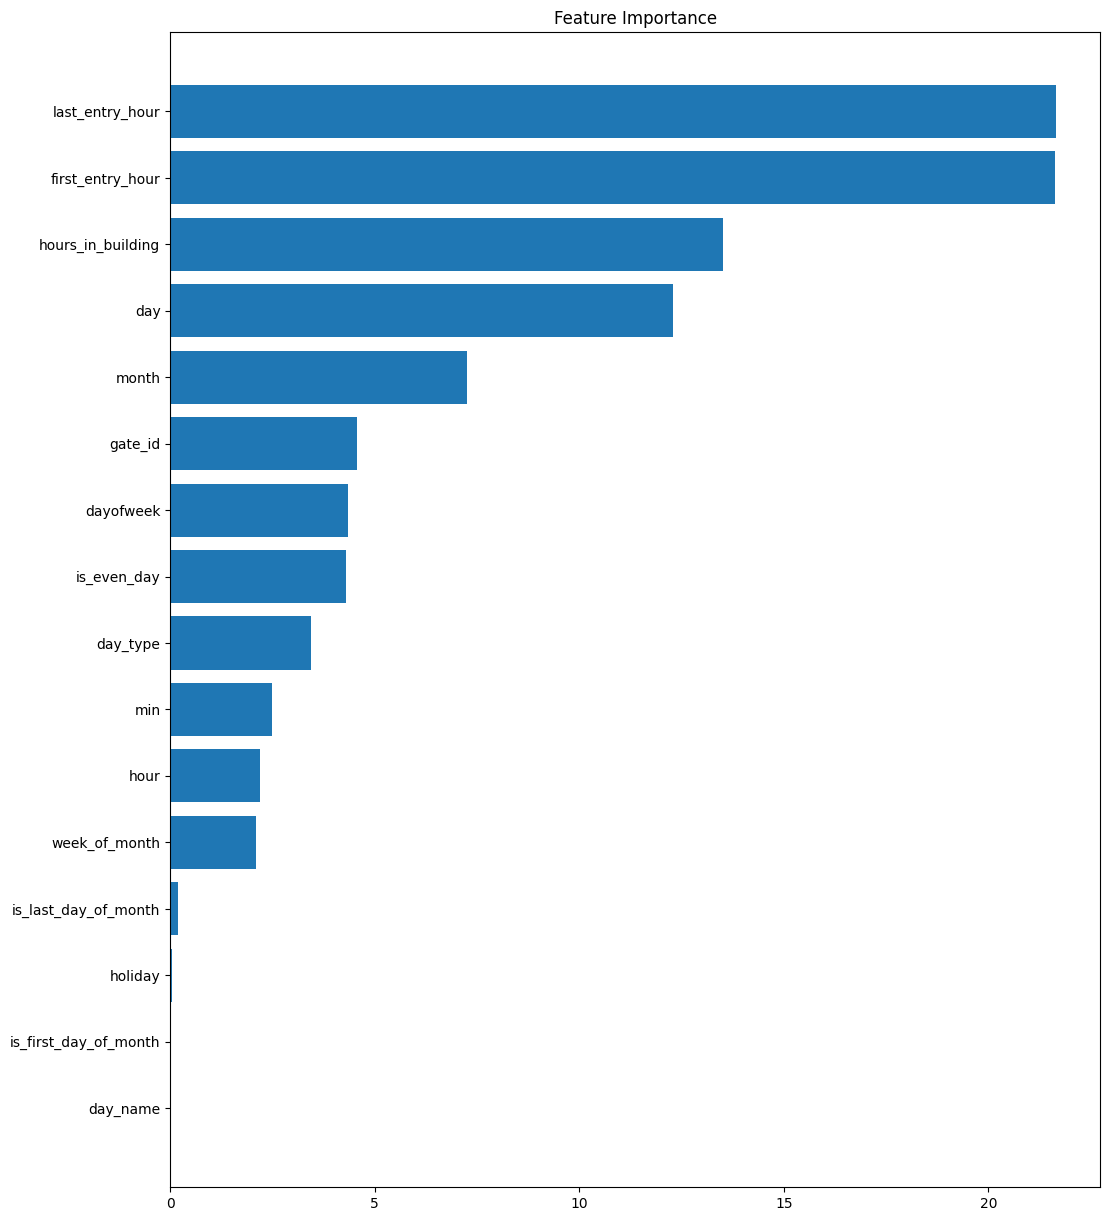

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

### Результаты на валидационной выборке


In [ ]:
results = pd.DataFrame(y_val)
results['pred'] = y_pred_val
results # Датафрейм с истинными значениями и предсказанными

user_id  pred
24703     37.0  37.0
6702      29.0  29.0
31476     15.0   0.0
20362     37.0  37.0
14631     55.0  55.0
...        ...   ...
20136      9.0   9.0
1039      53.0  53.0
6837      11.0  11.0
6337      53.0  19.0
19979     11.0   0.0

[12310 rows x 2 columns]

In [ ]:
results['user_id'].unique().shape

(55,)

In [ ]:
import numpy as np

In [ ]:
# Предскажем самым частотным user_id на val
# Для каждой группы (каждого user_id) считается мода предсказаний (наиболее частое предсказание) и количество записей.

def mode_1(x):
    return x.mode().iloc[0]

res = results.groupby('user_id')['pred'].agg([mode_1, 'count'])
display(res)

res = res.reset_index(); del res['count'] # Датайрейм с истинным значением, самым часто предсказанным и его частотой

mode_1  count
user_id               
0.0         0.0    414
1.0         1.0    410
2.0         2.0     14
3.0         3.0    313
5.0         5.0      4
6.0         6.0    650
7.0         7.0     17
8.0         8.0      9
9.0         9.0    355
10.0       10.0      6
11.0       11.0    439
12.0       12.0    643
14.0       14.0    216
15.0       15.0    581
17.0       17.0    227
18.0       18.0    504
19.0       19.0    581
20.0       20.0     39
21.0       46.0      2
22.0       22.0     30
23.0       23.0     86
24.0       24.0    135
25.0       25.0     83
26.0       26.0     98
27.0       27.0    183
28.0       28.0     22
29.0       29.0    323
30.0       46.0      4
31.0       31.0     63
32.0       32.0    357
33.0       33.0    414
34.0       34.0     94
35.0       35.0    192
36.0       36.0     16
37.0       37.0    764
38.0       38.0      5
39.0       39.0    361
40.0       40.0     85
41.0       41.0     39
42.0       42.0    119
43.0       43.0     41
44.0       44.0      1
45.0       45.0     20
46.0       46.0    166
47.0       47.0    438
48.0       48.0    249
49.0       49.0    395
50.0       50.0    338
51.0       56.0      1
52.0       52.0      2
53.0       53.0    448
54.0       54.0    342
55.0       55.0    758
56.0       56.0     45
57.0       57.0    169

In [ ]:
# Подсчитывается, сколько раз мода предсказаний совпадает с истинным user_id
print('correct', (res['user_id'] == res['mode_1']).sum())
print('out of', res.shape[0])
print('or', int((res['user_id'] == res['mode_1']).sum()*100 / res.shape[0]), '%')
# 1.
# 2. correct 5
# 3. correct 34
# 4. correct 46

correct 52
out of 55
or 94 %


In [ ]:
# Вычисляем метрики для валидационной выборки
accuracy = accuracy_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val, average='micro')
precision = precision_score(y_val, y_pred_val, average='micro')
recall = recall_score(y_val, y_pred_val, average='micro')

# Выводим результаты
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

#

Accuracy: 0.6575142160844841
F1 Score: 0.6575142160844841
Precision: 0.6575142160844841
Recall: 0.6575142160844841


Запуск 2: количество итераций увеличено до 100

Accuracy: 0.2228855721393035

F1 Score: 0.2228855721393035

Precision: 0.2228855721393035

Recall: 0.2228855721393035

correct 34 out of 54 or 62 %



---


Запуск 3: количество итераций увеличено до 200

Accuracy: 0.49438521677327646
F1 Score: 0.49438521677327646
Precision: 0.49438521677327646
Recall: 0.4943852167732764

correct 46
out of 54
or 85 %

### Результаты на обучающей выборке

In [ ]:
# Вычисляем метрики для обучающей выборки
accuracy = accuracy_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train, average='micro')
precision = precision_score(y_train, y_pred_train, average='micro')
recall = recall_score(y_train, y_pred_train, average='micro')

# Выводим результаты
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.7108175495385154
F1 Score: 0.7108175495385154
Precision: 0.7108175495385154
Recall: 0.7108175495385154


In [ ]:
# Train предсказуемо имеет более высокую метрику

results2 = pd.DataFrame(y_train)
results2['pred'] = y_pred_train
res2 = results2.groupby('user_id')['pred'].agg([mode_1]).reset_index()

print('correct', (res2['user_id'] == res2['mode_1']).sum())
print('out of', res2.shape[0])
print('or', int((res2['user_id'] == res2['mode_1']).sum()*100 / res2.shape[0]), '%')
# 1.
# 2. correct 6
# 3. correct 46
# correcr 51

correct 54
out of 55
or 98 %


# Итоговое решение

## Подготовка данных

In [ ]:
test_orig = pd.read_csv(data_path + 'test.csv', index_col=0)
test_orig

ts  gate_id  lost_id
37518  2023-01-03 08:21:00        9        1
37520  2023-01-03 08:21:18        5        1
37521  2023-01-03 08:21:19        5        1
37522  2023-01-03 08:21:39       10        1
37523  2023-01-03 08:32:49       15       19
...                    ...      ...      ...
44637  2023-02-24 17:08:57       10       15
44638  2023-02-24 19:43:36       11       15
44639  2023-02-24 19:44:00        4       15
44640  2023-02-24 19:44:01        4       15
44641  2023-02-24 19:44:09        9       15

[6620 rows x 3 columns]

In [ ]:
X_test

gate_id day_name  holiday  hour  min  day  month  dayofweek  \
37518        9  Tuesday     True     8   20    3      1          1   
37520        5  Tuesday     True     8   20    3      1          1   
37521        5  Tuesday     True     8   20    3      1          1   
37522       10  Tuesday     True     8   20    3      1          1   
37523       15  Tuesday     True     8   30    3      1          1   
...        ...      ...      ...   ...  ...  ...    ...        ...   
44637       10   Friday    False    17   10   24      2          4   
44638       11   Friday    False    19   40   24      2          4   
44639        4   Friday    False    19   40   24      2          4   
44640        4   Friday    False    19   40   24      2          4   
44641        9   Friday    False    19   40   24      2          4   

       week_of_month  is_even_day  first_entry_hour  last_entry_hour  \
37518              1            0                 8               17   
37520              1            0                 8               17   
37521              1            0                 8               17   
37522              1            0                 8               17   
37523              1            0                 8               18   
...              ...          ...               ...              ...   
44637              4            1                10               19   
44638              4            1                10               19   
44639              4            1                10               19   
44640              4            1                10               19   
44641              4            1                10               19   

       hours_in_building day_type  is_last_day_of_month  is_first_day_of_month  
37518                  9  morning                 False                      0  
37520                  9  morning                 False                      0  
37521                  9  morning                 False                      0  
37522                  9  morning                 False                      0  
37523                 10  morning                 False                      0  
...                  ...      ...                   ...                    ...  
44637                  9      day                 False                      0  
44638                  9  evening                 False                      0  
44639                  9  evening                 False                      0  
44640                  9  evening                 False                      0  
44641                  9  evening                 False                      0  

[6620 rows x 16 columns]

In [ ]:
y_test

37518     1.0
37520     1.0
37521     1.0
37522     1.0
37523    19.0
         ... 
44637    15.0
44638    15.0
44639    15.0
44640    15.0
44641    15.0
Name: lost_id, Length: 6620, dtype: float64

In [ ]:
X = X_train_filtered.copy()
y = y_train_filtered.astype(int)
X_test = prepared_data.loc[~train_idx].drop(columns=["user_id", "lost_id"])
y_test = prepared_data.loc[~train_idx]["lost_id"]

In [ ]:
X

gate_id  day_name holiday  hour  min  day  month dayofweek  \
0           7    Friday   False     9   10   29      7         4   
1           9    Friday   False     9   10   29      7         4   
3           5    Friday   False     9   10   29      7         4   
4           5    Friday   False     9   10   29      7         4   
5          10    Friday   False     9   10   29      7         4   
...       ...       ...     ...   ...  ...  ...    ...       ...   
37512      10  Saturday    True    17   20   31     12         5   
37513      11  Saturday    True    20   40   31     12         5   
37514       6  Saturday    True    20   40   31     12         5   
37515       6  Saturday    True    20   40   31     12         5   
37516       9  Saturday    True    20   40   31     12         5   

       week_of_month  is_even_day  first_entry_hour  last_entry_hour  \
0                  5            0                 9               14   
1                  5            0                 9               14   
3                  5            0                 9               14   
4                  5            0                 9               14   
5                  5            0                 9               14   
...              ...          ...               ...              ...   
37512              5            0                10               20   
37513              5            0                10               20   
37514              5            0                10               20   
37515              5            0                10               20   
37516              5            0                10               20   

       hours_in_building day_type  is_last_day_of_month  is_first_day_of_month  
0                      5  morning                 False                      0  
1                      5  morning                 False                      0  
3                      5  morning                 False                      0  
4                      5  morning                 False                      0  
5                      5  morning                 False                      0  
...                  ...      ...                   ...                    ...  
37512                 10      day                  True                      0  
37513                 10  evening                  True                      0  
37514                 10  evening                  True                      0  
37515                 10  evening                  True                      0  
37516                 10  evening                  True                      0  

[35171 rows x 16 columns]

In [ ]:
# # # Сделаем нормирование отдельными скейлерами по X и по X_test, т.к. будущие данные скорее всего изменятся

# scaler_X = StandardScaler()
# scaler_X_test = StandardScaler()

# scaler_X.fit(X_train_filtered)
# scaler_X_test.fit(X_test)

# X_scaled = scaler_X.transform(X_train_filtered)
# X_test_scaled = scaler_X_test.transform(X_test)

In [ ]:
# print('Признаки, всего')
# print(len(X.columns))
# print(list(X.columns))

In [ ]:
train_data = Pool(data=X,
                  label=y,
                  cat_features=cat_features)

## Обучение модели

In [ ]:
model = CatBoostClassifier(iterations=100, early_stopping_rounds=50, depth=5)

# model = CatBoostClassifier(
#     iterations=100,               # Уменьшаем количество деревьев
#     depth=6,                      # Делаем деревья мельче
#     l2_leaf_reg=3,                # Регуляризация
#     border_count=16,              # Оптимизация категориальных признаков
#     early_stopping_rounds=50,    # Останавливаемся раньше, если модель не улучшается
# )




model.fit(train_data)

y_test_pred = model.predict(X_test)

Learning rate set to 0.5
0:	learn: 3.3161989	total: 15.8s	remaining: 26m 4s
1:	learn: 3.0093677	total: 31.5s	remaining: 25m 44s
2:	learn: 2.8315306	total: 47.1s	remaining: 25m 23s
3:	learn: 2.6215984	total: 1m 2s	remaining: 25m 7s
4:	learn: 2.5172923	total: 1m 18s	remaining: 24m 49s
5:	learn: 2.3411303	total: 1m 34s	remaining: 24m 33s
6:	learn: 2.2333629	total: 1m 50s	remaining: 24m 24s
7:	learn: 2.1784439	total: 2m 8s	remaining: 24m 40s
8:	learn: 2.1618369	total: 2m 24s	remaining: 24m 20s
9:	learn: 2.1129662	total: 2m 40s	remaining: 24m 1s
10:	learn: 2.0835535	total: 2m 55s	remaining: 23m 42s
11:	learn: 2.0489577	total: 3m 11s	remaining: 23m 23s
12:	learn: 2.0066734	total: 3m 27s	remaining: 23m 5s
13:	learn: 1.9413363	total: 3m 42s	remaining: 22m 47s
14:	learn: 1.9309442	total: 3m 58s	remaining: 22m 30s
15:	learn: 1.9198231	total: 4m 13s	remaining: 22m 12s
16:	learn: 1.9061381	total: 4m 29s	remaining: 21m 55s
17:	learn: 1.8690469	total: 4m 44s	remaining: 21m 38s
18:	learn: 1.8154352	t

## Результаты модели на тестовой выборке

answer = pd.DataFrame()

answer['lost_id'] = test['lost_id']
answer['preds'] = y_test_pred

In [ ]:
answer = pd.DataFrame()

answer['lost_id'] = test['lost_id']
answer['preds'] = y_test_pred

In [ ]:
answer

lost_id  preds
37518        1     18
37520        1     18
37521        1     18
37522        1     18
37523       19      3
...        ...    ...
44637       15     55
44638       15     55
44639       15     32
44640       15     32
44641       15     26

[6620 rows x 2 columns]

## Формирование итогового решения

In [ ]:
# Предскажем самым частотным user_id

submit = pd.DataFrame(answer.groupby('lost_id')['preds'].agg([mode_1]))

In [ ]:
submit.index = submit.index.astype(int)
submit.rename(columns={'mode_1':'preds'}, inplace=True)
submit

preds
lost_id       
0           48
1           15
3           11
6           12
9           53
11           3
12          12
14          12
15          53
17          48
18          19
19           3
23           8
24          53
25          23
26          24
27          40
29          37
32          55
33          40
34          18
35          53
37          37
39          54
42          50
46          34
47           3
48           9
49          37
50          54
53          55
54           3
55          19
57           0

In [ ]:
submit.shape[0]

34

In [ ]:
submit.to_csv('answer.csv')
! zip answer_base.zip answer.csv


updating: answer.csv (deflated 39%)
